In [1]:
# use hmark_env2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy.stats import spearmanr, pearsonr,mannwhitneyu
from sklearn.linear_model import ElasticNetCV, ElasticNet
from inmoose.pycombat import pycombat_norm
from pylr2 import regress2
import shap
import gseapy
import statsmodels.formula.api as smf
from xgboost import XGBRegressor

# turn on autoreload
%load_ext autoreload
%autoreload 2

source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
    
# read source files–––
from histone_mark_dataset import histoneMarkDataset
from methylation_dataset import methylationDataset
from read_data import DatasetLoader
from download_data import DatasetDownloader
from multi_dataset import MultiDataset

%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colorpalettes 
# import palettable
import palettable
# use Prism_10
from palettable.cartocolors.qualitative import Prism_10, Safe_10, Bold_10
dataset_colors = Safe_10.mpl_colors
hmark_colors = Prism_10.mpl_colors
tissue_colors = Bold_10.mpl_colors
from palettable.cartocolors.diverging import Fall_3
# create a mapping from datasets to colors
dataset_colors = {
    'encode-human': dataset_colors[0],
    'blueprint-human': dataset_colors[1],
    'encode-mouse': dataset_colors[2],
    'signal-mouse': dataset_colors[3],
    'yang-mouse': dataset_colors[4],
    'stubbs-mouse': dataset_colors[5],
    'hillje-mouse': dataset_colors[6],
    'ceehrc': dataset_colors[7],
    'meer-mouse': dataset_colors[8],
    'petkovich-mouse': dataset_colors[9]
}
# create a mapping from hmarks to colors
hmark_colors = {
    'H3K4me3': hmark_colors[0],
    'H3K36me3': hmark_colors[1],
    'H3K27ac': hmark_colors[2],
    'H3K27me3': hmark_colors[3],
    'H3K9me3': hmark_colors[4],
    'H3K4me1': hmark_colors[5],
    'H3K9ac': hmark_colors[6],
    'H4K20me1': hmark_colors[7],
    'H3K9/14ac':'black',
    'H2A.Zac':'black',
    'methylation':'black',
    'DNAm':'black'
}

# Set global plotting parameters
plt.rcParams.update({
    # Figure aesthetics
    'figure.facecolor': 'none',
    'axes.facecolor': 'none',
    'savefig.facecolor': 'none',
    'figure.dpi': 300,
    'savefig.dpi': 300,
    
    # Font sizes
    'font.size': 8,
    'axes.titlesize': 8,
    'axes.labelsize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    
    # use arial
    'font.family': 'sans-serif',
    
    # Ensure text is editable in illustrator
    'svg.fonttype': 'none',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    
    # Grid settings
    'axes.grid': False,
    
    # Legend settings
    'legend.frameon': False,
    
    'axes.spines.top': False, # Show top spine
    'axes.spines.right': False, # Show right spine
})

# Load data

In [2]:
# human
# methylation and histone
loader = DatasetLoader(dataset_name = 'CEEHRC')
methyl_ceehrc, hmark_ceehrc = loader.load_dataset()
# methylation and histone
loader = DatasetLoader(dataset_name = 'encode-human', load_methyl = True, load_histone = True)
methyl_human_encode, hmark_human_encode = loader.load_dataset()
# methylation and histone
loader = DatasetLoader(dataset_name = 'blueprint-human', load_methyl = True, load_histone = True)
human_blueprint_methyl, hmark_human_blueprint = loader.load_dataset()


# mouse 
# brain histone
loader = DatasetLoader(dataset_name = 'signal_2024')
signal = loader.load_dataset()
# liver and kidney histone
loader = DatasetLoader(dataset_name = 'yang_2023')
yang = loader.load_dataset()
# methylation and hisotne many tissues (4 mice)
#loader = DatasetLoader(dataset_name = 'encode-mouse', load_methyl = True, load_histone = True)
#methyl_mouse_encode, hmark_mouse_encode = loader.load_dataset()
# multi tissue methylation 
loader = DatasetLoader(dataset_name = 'stubbs_2017')
stubbs = loader.load_dataset()
# liver histone, w caloric restriction
loader = DatasetLoader(dataset_name = 'hillje_2022')
hillje = loader.load_dataset()
# mouse methylation
loader = DatasetLoader(dataset_name = 'meer')
meer = loader.load_dataset()
# mouse methylation and ipsc's
loader = DatasetLoader(dataset_name = 'petkovich')
petkovich = loader.load_dataset()

# drop duplicates index
methyl_human_encode.data_matrix_w_meta = methyl_human_encode.data_matrix_w_meta[~methyl_human_encode.data_matrix_w_meta.index.duplicated(keep = 'first')]

histone_datasets = [hmark_human_encode,hmark_human_blueprint, hmark_ceehrc, signal, yang, hillje] # hmark_mouse_encode
methyl_datasets = [methyl_human_encode, human_blueprint_methyl, methyl_ceehrc, stubbs, meer, petkovich] # methyl_mouse_encode

Loading dataset: CEEHRC
Reading cached data matrix from /cellar/users/zkoch/histone_mark_proj/data/CEEHRC/methyl_bed/data_matrix/CEEHRC_data_matrix_w_meta.parquet
Reading cached data matrix from /cellar/users/zkoch/histone_mark_proj/data/CEEHRC/bed_peaks/data_matrix/ceehrc_hmark_data_matrix_w_meta.parquet
Loading dataset: encode-human
Reading cached data matrix from /cellar/users/zkoch/histone_mark_proj/data/encode/human_bed_files/methyl/data_matrix/methyl_human_encode_data_matrix_w_meta.parquet
Reading cached data matrix from /cellar/users/zkoch/histone_mark_proj/data/encode/human_bed_files/histone/data_matrix/human_encode_hmark_data_matrix_w_meta.parquet
Loading dataset: blueprint-human
Reading cached data matrix from /cellar/users/zkoch/histone_mark_proj/data/blueprint/histone/data_matrix/human_blueprint_hmark_data_matrix_w_meta.parquet
Reading cached data matrix from /cellar/users/zkoch/histone_mark_proj/data/blueprint/methyl/data_matrix/human_blueprint_methyl_data_matrix_w_meta.pa

# Num samples each dataset

### Methylation

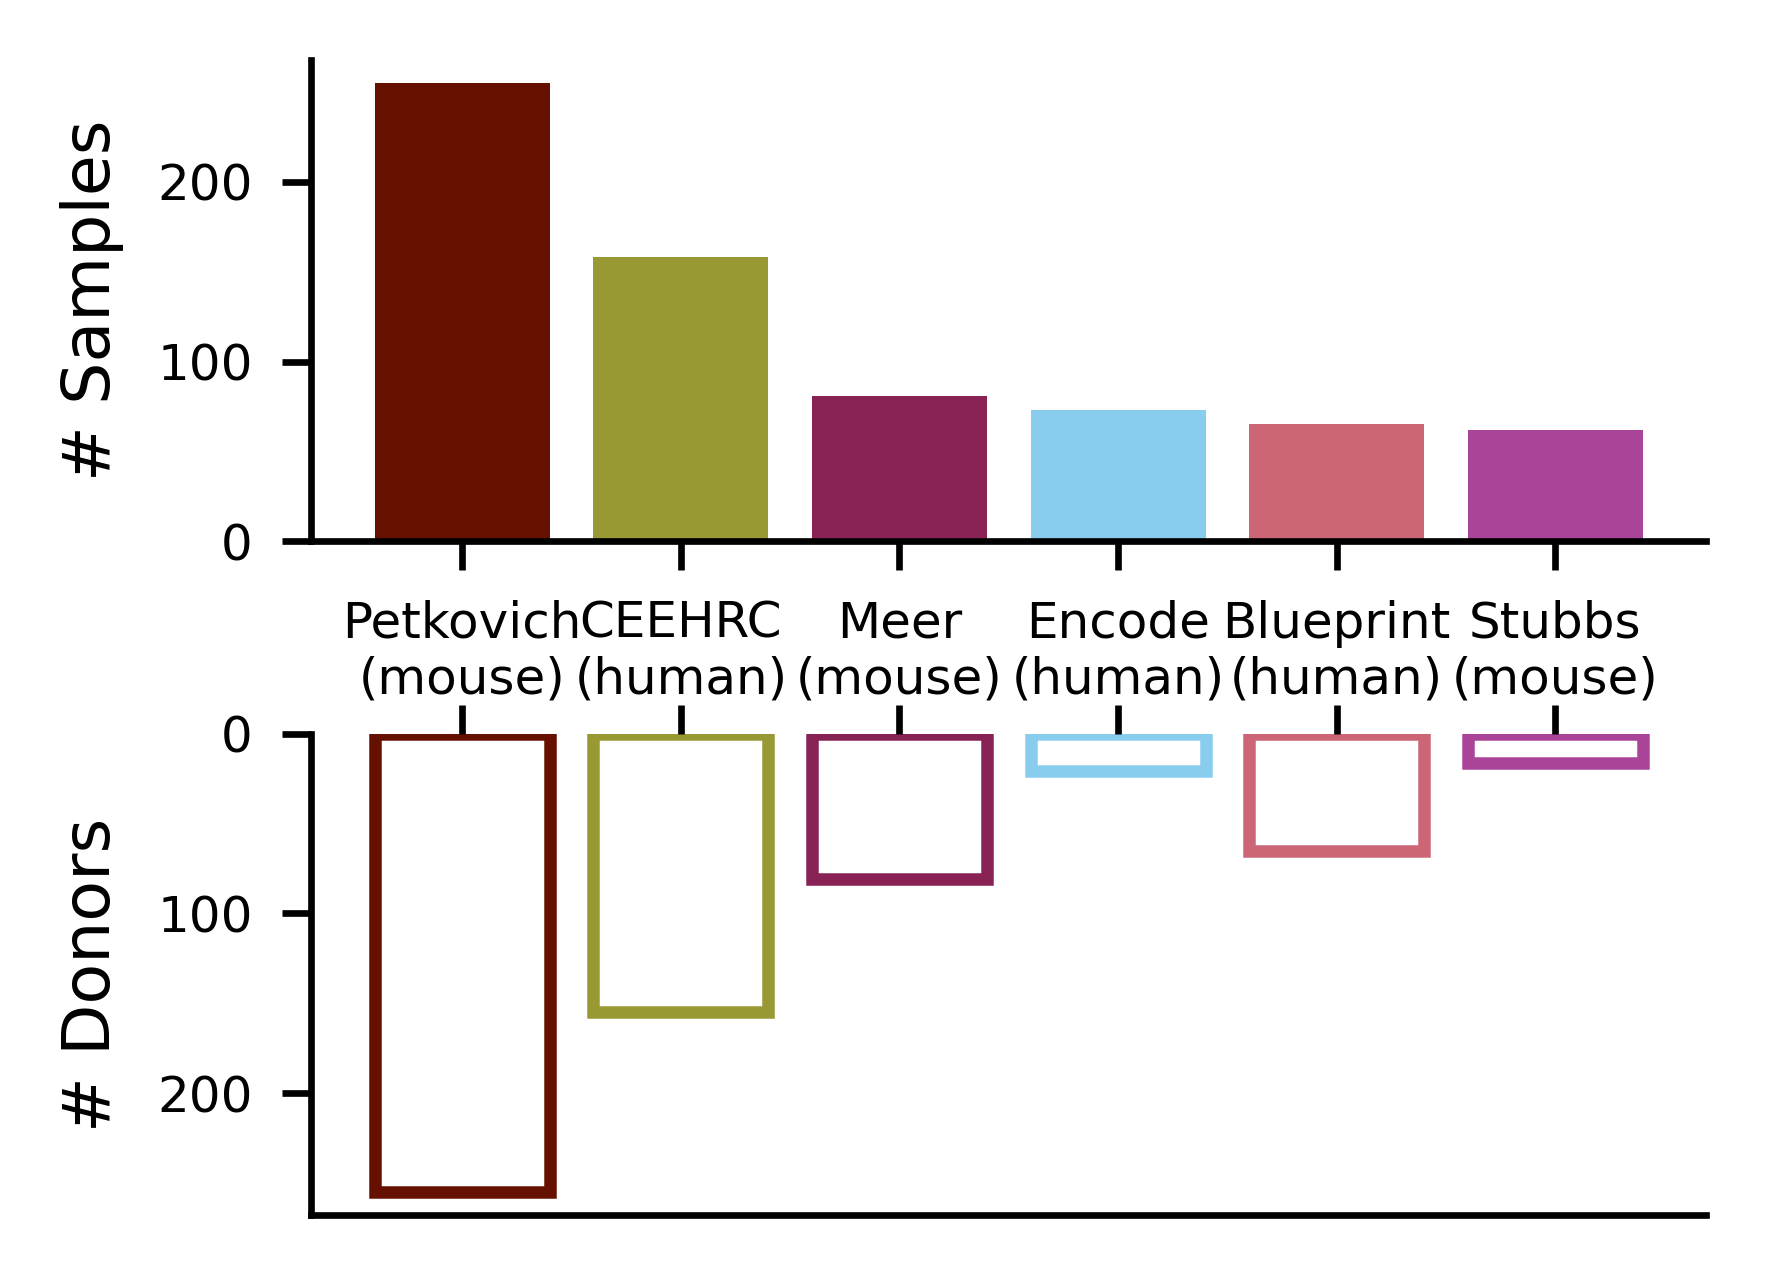

In [9]:
# count the number of samples and number of donors for each dataset

# methylation datasets
petkovich_samples = petkovich.data_matrix_w_meta.shape[0]
petkovich_donors = petkovich.data_matrix_w_meta['donor'].nunique()
methyl_human_encode_samples = methyl_human_encode.data_matrix_w_meta.shape[0]
methyl_human_encode_donors = methyl_human_encode.data_matrix_w_meta['donor'].nunique()
meer_samples = meer.data_matrix_w_meta.shape[0]
meer_donors = meer.data_matrix_w_meta['donor'].nunique()
ceehrc_methyl_samples = methyl_ceehrc.data_matrix_w_meta.shape[0]
ceehrc_methyl_donors = methyl_ceehrc.data_matrix_w_meta['donor'].nunique()
human_blueprint_methyl_samples = human_blueprint_methyl.data_matrix_w_meta.shape[0]
human_blueprint_methyl_donors = human_blueprint_methyl.data_matrix_w_meta['donor'].nunique()
stubbs_samples = stubbs.data_matrix_w_meta.shape[0]
stubbs_donors = stubbs.data_matrix_w_meta['donor'].nunique()


# plot as two bar plots facing in opposite vertical directions, samples on top, donors on bottom
fig, ax = plt.subplots(2,1,figsize = (3, 2.5))
ax[0].bar(
    ['Petkovich\n(mouse)','CEEHRC\n(human)',  'Meer\n(mouse)', 'Encode\n(human)', 'Blueprint\n(human)', 'Stubbs\n(mouse)'], 
    [petkovich_samples, ceehrc_methyl_samples, meer_samples, methyl_human_encode_samples, human_blueprint_methyl_samples, stubbs_samples],
    color = [dataset_colors[dataset] for dataset in ['petkovich-mouse', 'ceehrc', 'meer-mouse', 'encode-human', 'blueprint-human', 'stubbs-mouse']],
    linewidth = 1.5
)
ax[0].set_ylabel('# Samples')

ax[1].bar(
    [ 'Petkovich\n(mouse)','CEEHRC\n(human)', 'Meer\n(mouse)',  'Encode\n(human)', 'Blueprint\n(human)', 'Stubbs\n(mouse)'], 
    [ petkovich_donors, ceehrc_methyl_donors, meer_donors, methyl_human_encode_donors, human_blueprint_methyl_donors, stubbs_donors],
    color = 'white',
    edgecolor = [dataset_colors[dataset] for dataset in [ 'petkovich-mouse', 'ceehrc', 'meer-mouse', 'encode-human', 'blueprint-human', 'stubbs-mouse']],
    linewidth = 1.5
)
ax[1].set_ylabel('# Donors')
# reverse second y axis
ax[1].invert_yaxis()
# move x axis to top
ax[1].xaxis.tick_top()
# remove labels and tick labels
ax[1].set_xlabel('')
ax[1].set_xticklabels([])

ax[0].set_ylim(bottom = 0)
ax[1].set_ylim(top = 0, bottom = ax[0].get_ylim()[1])
# increase spacing between figures vertically
fig.subplots_adjust(hspace = .4)
fig.savefig('../figures/supplementary/data_characteristics/methyl_sample_donor_counts.svg', bbox_inches = 'tight', transparent = True)

### Histone

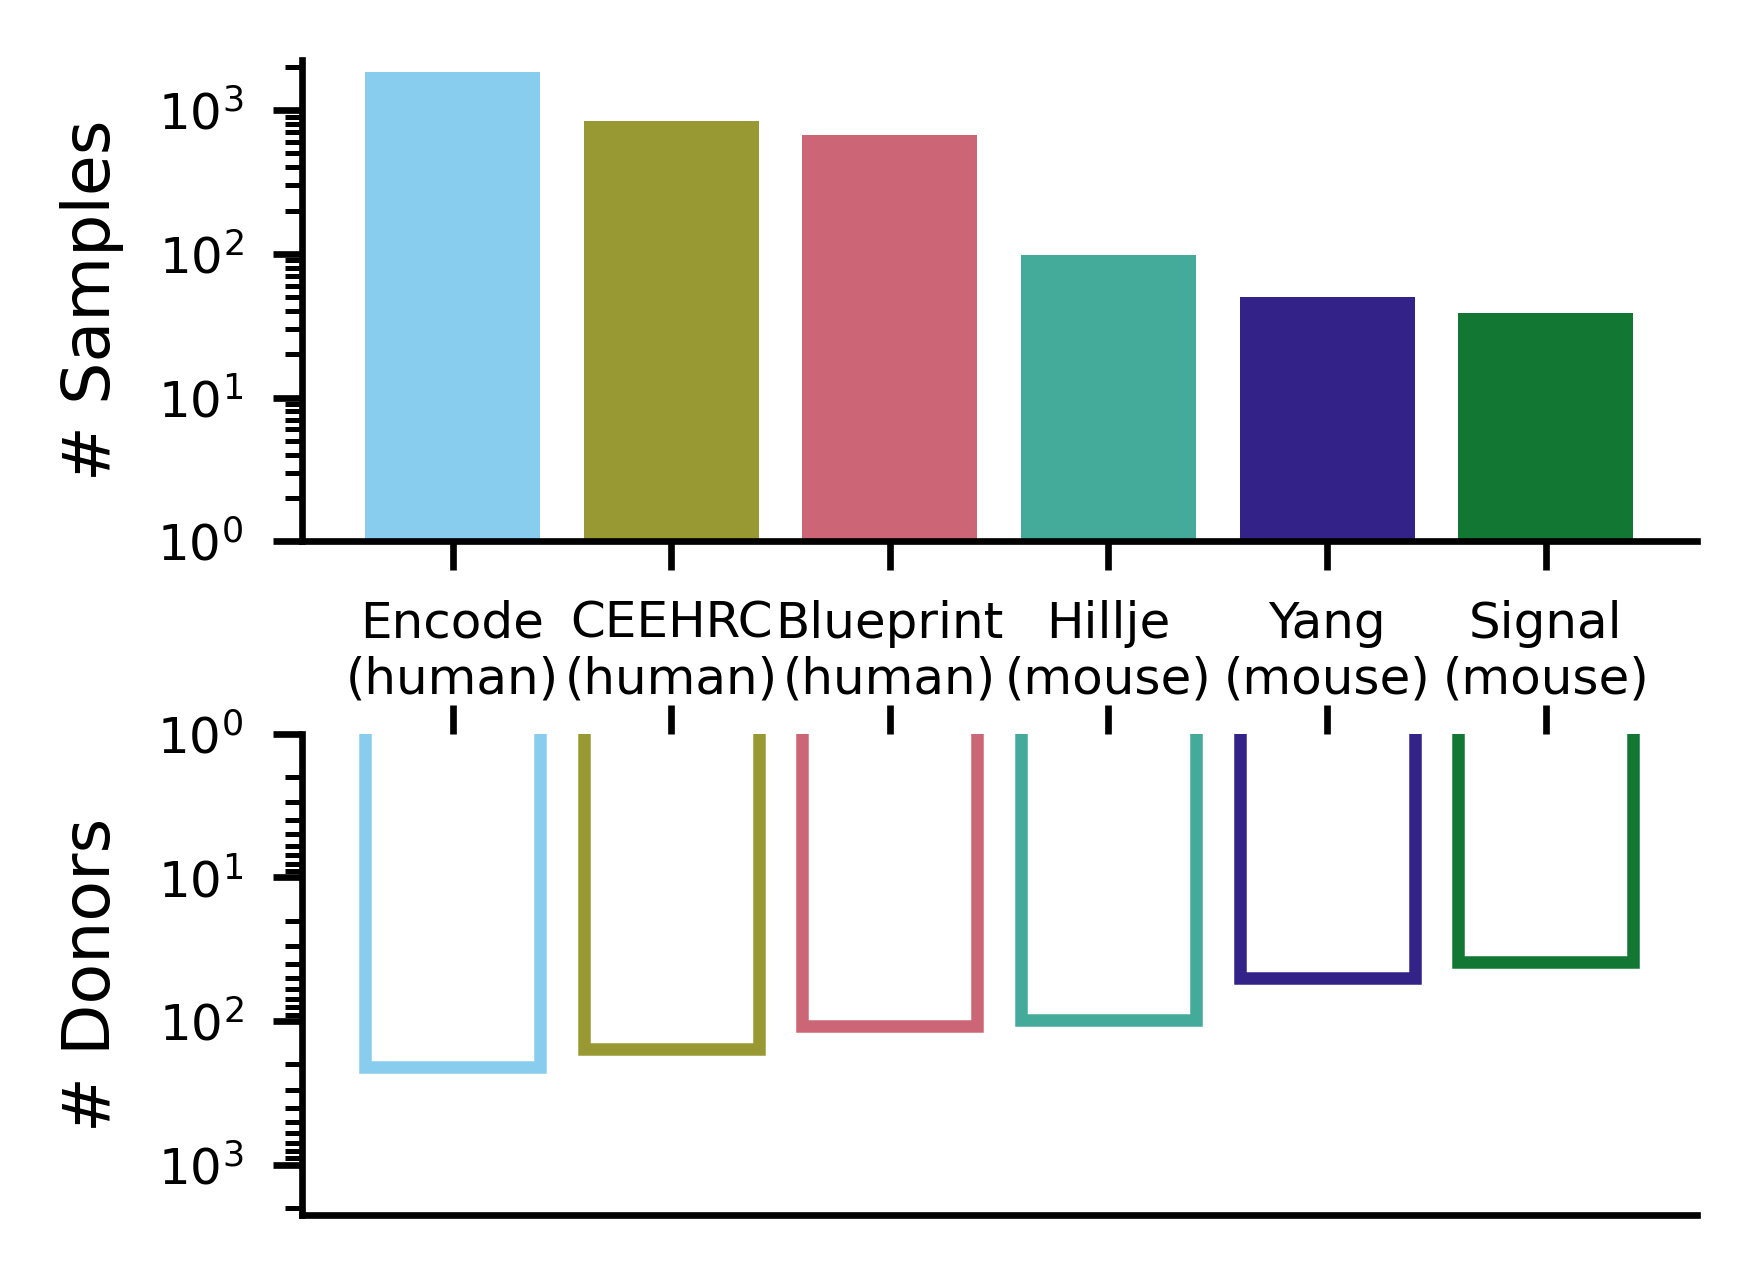

In [10]:
# same for histone

# histone mark datasets
hmark_human_encode_samples = hmark_human_encode.data_matrix_w_meta.shape[0]
hmark_human_encode_donors = hmark_human_encode.data_matrix_w_meta['donor'].nunique()
hmark_human_blueprint_samples = hmark_human_blueprint.data_matrix_w_meta.shape[0]
hmark_human_blueprint_donors = hmark_human_blueprint.data_matrix_w_meta['donor'].nunique()
ceehrc_hmark_samples = hmark_ceehrc.data_matrix_w_meta.shape[0]
ceehrc_hmark_donors = hmark_ceehrc.data_matrix_w_meta['donor'].nunique()
signal_samples = signal.data_matrix_w_meta.shape[0]
signal_donors = signal.data_matrix_w_meta['donor'].nunique()
yang_samples = yang.data_matrix_w_meta.shape[0]
yang_donors = yang.data_matrix_w_meta['donor'].nunique()
hillje_samples = hillje.data_matrix_w_meta.shape[0]
hillje_donors = hillje.data_matrix_w_meta['donor'].nunique()
# plot as two bar plots facing in opposite vertical directions, samples on top, donors on bottom
fig, ax = plt.subplots(
    2,1,figsize = (3, 2.5),
)
ax[0].bar(
    ['Encode\n(human)', 'CEEHRC\n(human)',  'Blueprint\n(human)', 'Hillje\n(mouse)', 'Yang\n(mouse)', 'Signal\n(mouse)'], 
    [hmark_human_encode_samples, ceehrc_hmark_samples, hmark_human_blueprint_samples, hillje_samples, yang_samples, signal_samples],
    color = [dataset_colors[dataset] for dataset in ['encode-human', 'ceehrc', 'blueprint-human', 'hillje-mouse', 'yang-mouse', 'signal-mouse']],
    #edgecolor = categorical_palette,
    linewidth = 1.5
)
ax[0].set_ylabel('# Samples')
ax[1].bar(
    ['Encode\n(human)', 'CEEHRC\n(human)',  'Blueprint\n(human)', 'Hillje\n(mouse)', 'Yang\n(mouse)', 'Signal\n(mouse)'], 
    [hmark_human_encode_donors, ceehrc_hmark_donors, hmark_human_blueprint_donors, hillje_donors, yang_donors, signal_donors],
    color = 'white',
    edgecolor = [dataset_colors[dataset] for dataset in ['encode-human', 'ceehrc', 'blueprint-human', 'hillje-mouse', 'yang-mouse', 'signal-mouse']],
    linewidth = 1.5
)
ax[1].set_ylabel('# Donors')
# reverse second y axis
ax[1].invert_yaxis()
# move x axis to top
ax[1].xaxis.tick_top()
# remove labels and tick labels
ax[1].set_xlabel('')
ax[1].set_xticklabels([])
# log scale y axes
ax[0].set_yscale('log')
ax[1].set_yscale('log')
# set bottom of y axis to 0 
ax[0].set_ylim(bottom = 1)
ax[1].set_ylim(top = 1, bottom = ax[0].get_ylim()[1])
# increase spacing between figures vertically
fig.subplots_adjust(hspace = .4)
fig.savefig('../figures/supplementary/data_characteristics/hist_sample_donor_counts.svg', bbox_inches = 'tight', transparent = True)

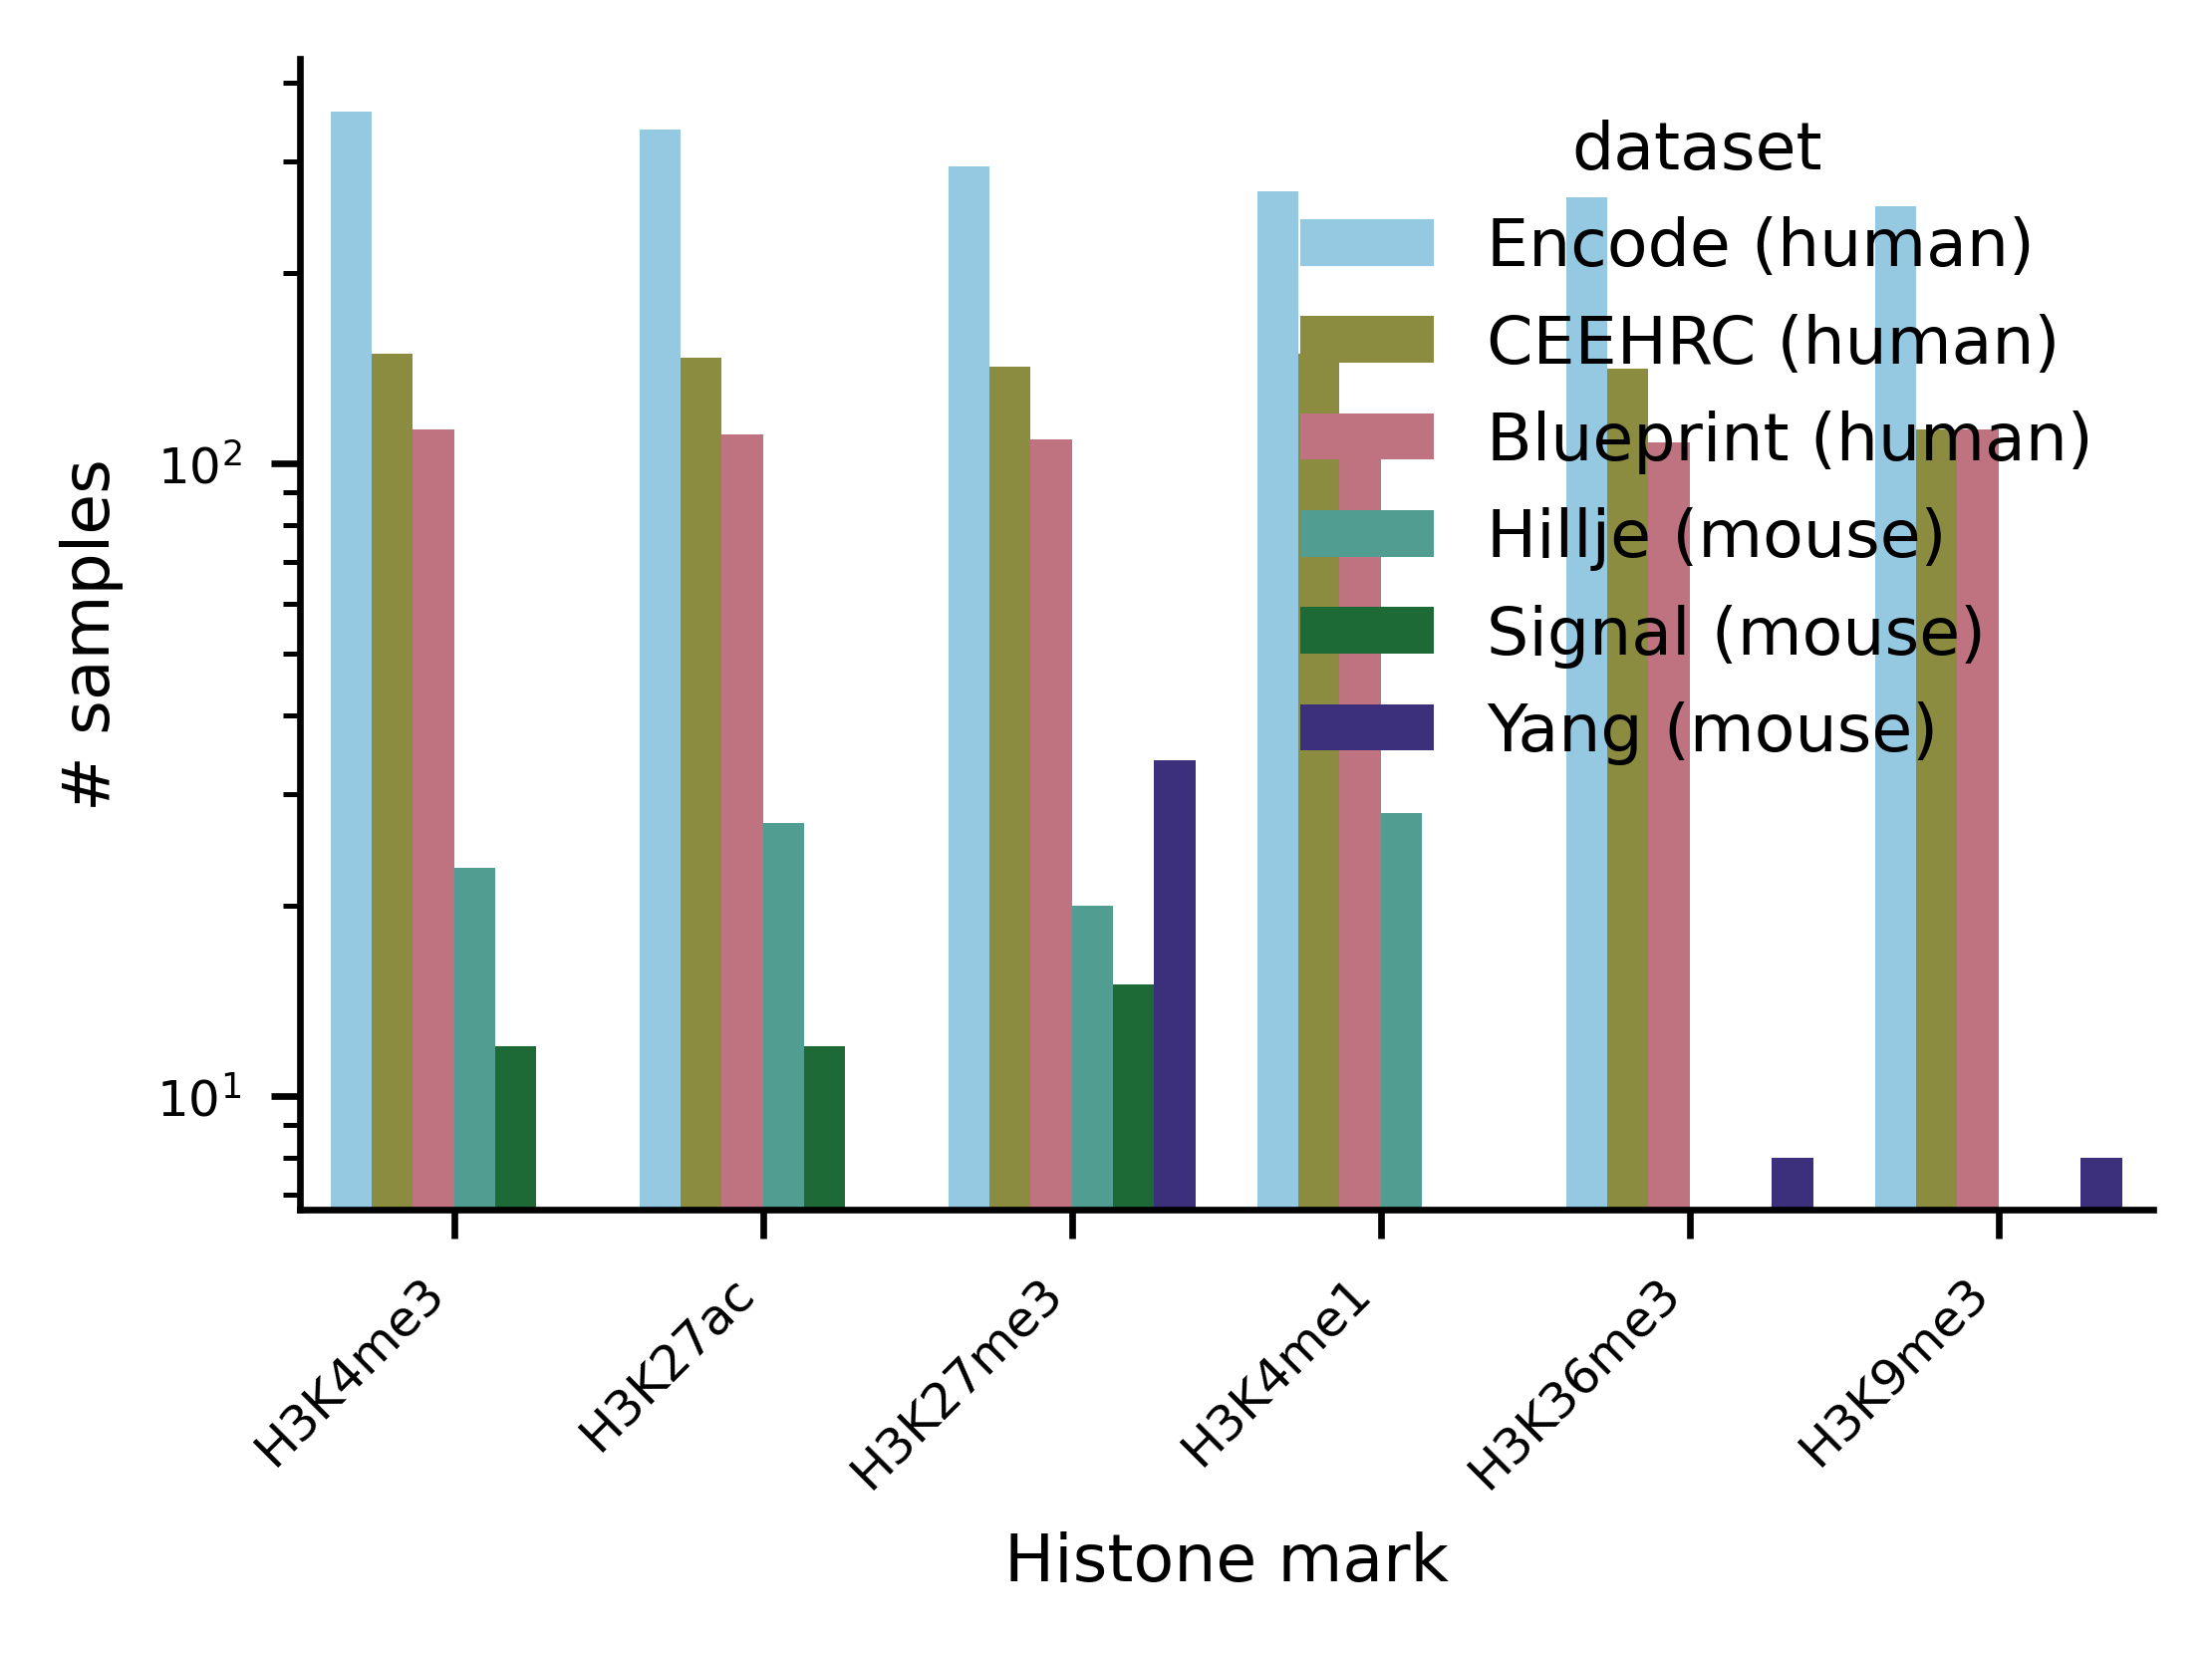

In [ ]:
hmark_human_encode_hmark_counts = hmark_human_encode.data_matrix_w_meta['histone_mark'].value_counts()
hmark_ceehrc_hmark_counts = hmark_ceehrc.data_matrix_w_meta['histone_mark'].value_counts()
hmark_human_blueprint_hmark_counts = hmark_human_blueprint.data_matrix_w_meta['histone_mark'].value_counts()
hillje_hmark_counts = hillje.data_matrix_w_meta['histone_mark'].value_counts()
yang_hmark_counts = yang.data_matrix_w_meta['histone_mark'].value_counts()
signal_hmark_counts = signal.data_matrix_w_meta['histone_mark'].value_counts()
hmarks_to_use = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3']


# create a dataframe of the counts
hmark_counts_df = pd.concat([hmark_human_encode_hmark_counts, hmark_ceehrc_hmark_counts, hmark_human_blueprint_hmark_counts,  hillje_hmark_counts,  yang_hmark_counts,signal_hmark_counts], axis = 1)
hmark_counts_df.columns = ['Encode (human)', 'CEEHRC (human)', 'Blueprint (human)', 'Hillje (mouse)', 'Yang (mouse)', 'Signal (mouse)']
hmark_counts_df.fillna(0, inplace = True)
# pivot to be long format
hmark_counts_df = hmark_counts_df.reset_index()
hmark_counts_df = hmark_counts_df.melt(id_vars = 'histone_mark', value_vars = ['Encode (human)', 'CEEHRC (human)', 'Blueprint (human)', 'Hillje (mouse)', 'Yang (mouse)', 'Signal (mouse)'], var_name = 'dataset', value_name = 'count')
# subset to hmarks_to_use
hmark_counts_df = hmark_counts_df[hmark_counts_df['histone_mark'].isin(hmarks_to_use)]
fig, ax = plt.subplots(figsize = (4, 2.5))
sns.barplot(
    x = 'histone_mark', y = 'count', data = hmark_counts_df, hue = 'dataset', order = hmark_counts_df['histone_mark'].value_counts().index,
    hue_order = ['Encode (human)', 'CEEHRC (human)', 'Blueprint (human)','Hillje (mouse)', 'Signal (mouse)', 'Yang (mouse)', ],
    ax = ax,
    palette = [dataset_colors[dataset] for dataset in ['encode-human', 'ceehrc', 'blueprint-human', 'hillje-mouse', 'signal-mouse', 'yang-mouse']],
    rasterized = True
)
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
ax.set_ylabel('# samples')
ax.set_xlabel('Histone mark')
fig.savefig('../figures/supplementary/data_characteristics/hist_sample_counts.svg', bbox_inches = 'tight', transparent = True)

# Train models

### Pan-epigenetic

In [12]:
# fill nan
hmarks_to_use = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'methylation'] # 'H3K36me3', 'H3K9me3',

# cross species, pan-epigenetic
datasets = histone_datasets + methyl_datasets

name = '.'.join([dataset.name for dataset in datasets])
model_name = 'XGBRegressor'
features = 'all'
target_column = 'age_scaled_loglog'
n_pcs = -1
nan_policy = 'fill'
n_folds = 5

pan_epigenetic = MultiDataset(
    datasets = datasets,
    nan_policy = nan_policy
    )

# subset to hmarks_to_use
pan_epigenetic.combined_data_matrix = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['histone_mark'].isin(hmarks_to_use)
    ]

# subset to tissues with at least 50 samples and exclude sex specific tissues adn cell lines
n_samples_per_tissue = pan_epigenetic.combined_data_matrix['general_tissue'].value_counts()
tissues_to_drop = n_samples_per_tissue[n_samples_per_tissue < 50].index.tolist()
tissues_to_drop = tissues_to_drop + ['prostate', 'breast', 'reproductive', 'placenta', 'cell_line']
tissues_to_drop = [tissue for tissue in tissues_to_drop if tissue != 'special']
tissues_to_drop = list(set(tissues_to_drop))
pan_epigenetic.combined_data_matrix = pan_epigenetic.combined_data_matrix[
    ~pan_epigenetic.combined_data_matrix['general_tissue'].isin(tissues_to_drop)
    ]

# exlucde CR, GHRKO, and fibroblast/iPSC samples from training 
special_diet_samples = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['diet'].isin(['Caloric restriction', 'CR'])
].index.tolist()
special_genetic_background_samples = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['strain'].isin(['GHRKO', 'Snell Dwarf'])
].index.tolist()
special_fibroblast_samples = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['tissue'].isin(['Lung fibroblasts', 'iPSCs from kidney fibroblasts', 'Kidney fibroblasts', 'iPSCs from lung fibroblasts'])
].index.tolist()
special_samples = list(set(special_diet_samples + special_genetic_background_samples + special_fibroblast_samples))
pan_epigenetic.exclude_samples = special_samples

# do combat normalization
pan_epigenetic.combat_normalize(batch_col = 'dataset')

# set time based on n_folds
if n_folds == 1:
    time = '48:00:00'
else:
    time = '120:00:00'
    
# train model    
pan_epigenetic.predict_on_cluster(
    output_dir = f"/cellar/users/zkoch/histone_mark_proj/model_results/{name}_{model_name}_{features}_{n_folds}folds_{target_column}_{n_pcs}pcs_{nan_policy}nanPolicy_pan_epigenetic",
    result_column = 'predicted_age',
    target_column = target_column,
    n_folds = n_folds,
    seperate_by_hmark = False,
    jobname = f"{name}_{model_name}_{features}_{n_folds}folds_{target_column}_{n_pcs}pcs_pan_epigenetic",
    mem_gb = 200,
    cpus = 32,
    time = time,
    model_type = model_name,
    n_pcs = n_pcs
)

Performing ComBat normalization using dataset as batch...
ComBat normalization complete
Submitted batch job 2115456
Job submitted. Results will be saved to /cellar/users/zkoch/histone_mark_proj/model_results/human_encode_hmark.human_blueprint_hmark.ceehrc_hmark.signal_2024.yang_2023.hillje.methyl_human_encode.human_blueprint_methyl.CEEHRC.stubbs_methyl.meer.petkovich_XGBRegressor_all_5folds_age_scaled_loglog_-1pcs_fillnanPolicy_pan_epigenetic


In [4]:
# drop nan
hmarks_to_use = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1',  'methylation'] #'H3K36me3', 'H3K9me3',

# cross species, pan-epigenetic
datasets = histone_datasets + methyl_datasets

name = '.'.join([dataset.name for dataset in datasets])
model_name = 'XGBRegressor'
features = 'all'
target_column = 'age_scaled_loglog'
n_pcs = -1
nan_policy = 'drop'
n_folds = 5

pan_epigenetic = MultiDataset(
    datasets = datasets,
    nan_policy = nan_policy
    )

# subset to hmarks_to_use
pan_epigenetic.combined_data_matrix = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['histone_mark'].isin(hmarks_to_use)
    ]

# subset to tissues with at least 50 samples and exclude sex specific tissues adn cell lines
n_samples_per_tissue = pan_epigenetic.combined_data_matrix['general_tissue'].value_counts()
tissues_to_drop = n_samples_per_tissue[n_samples_per_tissue < 50].index.tolist()
tissues_to_drop = tissues_to_drop + ['prostate', 'breast', 'reproductive', 'placenta', 'cell_line']
tissues_to_drop = [tissue for tissue in tissues_to_drop if tissue != 'special']
tissues_to_drop = list(set(tissues_to_drop))
pan_epigenetic.combined_data_matrix = pan_epigenetic.combined_data_matrix[
    ~pan_epigenetic.combined_data_matrix['general_tissue'].isin(tissues_to_drop)
    ]

# exlucde CR, GHRKO, and fibroblast/iPSC samples from training 
special_diet_samples = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['diet'].isin(['Caloric restriction', 'CR'])
].index.tolist()
special_genetic_background_samples = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['strain'].isin(['GHRKO', 'Snell Dwarf'])
].index.tolist()
special_fibroblast_samples = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['tissue'].isin(['Lung fibroblasts', 'iPSCs from kidney fibroblasts', 'Kidney fibroblasts', 'iPSCs from lung fibroblasts'])
].index.tolist()
special_samples = list(set(special_diet_samples + special_genetic_background_samples + special_fibroblast_samples))
pan_epigenetic.exclude_samples = special_samples

# do combat normalization
pan_epigenetic.combat_normalize(batch_col = 'dataset')

# set time based on n_folds
if n_folds == 1:
    time = '48:00:00'
else:
    time = '120:00:00'
    
# train model    
pan_epigenetic.predict_on_cluster(
    output_dir = f"/cellar/users/zkoch/histone_mark_proj/model_results/{name}_{model_name}_{features}_{n_folds}folds_{target_column}_{n_pcs}pcs_{nan_policy}nanPolicy_pan_epigenetic",
    result_column = 'predicted_age',
    target_column = target_column,
    n_folds = n_folds,
    seperate_by_hmark = False,
    jobname = f"{name}_{model_name}_{features}_{n_folds}folds_{target_column}_{n_pcs}pcs_pan_epigenetic",
    mem_gb = 200,
    cpus = 32,
    time = time,
    model_type = model_name,
    n_pcs = n_pcs
)

Performing ComBat normalization using dataset as batch...
ComBat normalization complete
Submitted batch job 2099579
Job submitted. Results will be saved to /cellar/users/zkoch/histone_mark_proj/model_results/human_encode_hmark.human_blueprint_hmark.ceehrc_hmark.signal_2024.yang_2023.hillje.methyl_human_encode.human_blueprint_methyl.CEEHRC.stubbs_methyl.meer.petkovich_XGBRegressor_all_5folds_age_scaled_loglog_-1pcs_dropnanPolicy_pan_epigenetic


In [6]:
# flip correlations
hmarks_to_use = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'methylation']
# cross species, pan-epigenetic
datasets = histone_datasets + methyl_datasets
name = '.'.join([dataset.name for dataset in datasets])
model_name = 'XGBRegressor'
features = 'all'
target_column = 'age_scaled_loglog'
n_pcs = -1
flip_negative_correlations = True

for n_folds in [5]:
    pan_epigenetic = MultiDataset(
        datasets = datasets
        )
    # subset to hmarks_to_use
    pan_epigenetic.combined_data_matrix = pan_epigenetic.combined_data_matrix[
        pan_epigenetic.combined_data_matrix['histone_mark'].isin(hmarks_to_use)
        ]
    # do combat normalization
    pan_epigenetic.combat_normalize(batch_col = 'dataset')
    
    if flip_negative_correlations:
        correlations = pan_epigenetic.compute_feature_age_correlations(
            group_cols=['histone_mark'],
            age_col='age_scaled_loglog',
            method='spearman',
            n_jobs=8 
            )
        correlations['abs_correlation'] = correlations['correlation'].abs()
        correlations.query("feature != 'pred_age'", inplace = True)
        # subset to genes with a significant and non-na correlation with age, in at least 1 epi marks
        significant_negative_correlations = correlations[(correlations['q_value'] < 0.05) & (correlations['correlation'] < 0)]
        pairs_to_flip = significant_negative_correlations[['feature', 'histone_mark']].values.tolist()
        # Apply the function to flip negative correlations
        pan_epigenetic.flip_feature_values(
            pairs_to_flip
        )
    
    # set time based on n_folds
    if n_folds == 1:
        time = '48:00:00'
    else:
        time = '120:00:00'
    # train model    
    pan_epigenetic.predict_on_cluster(
        output_dir = f"/cellar/users/zkoch/histone_mark_proj/model_results/{name}_{model_name}_{features}_{n_folds}folds_{target_column}_{n_pcs}pcs_flip{flip_negative_correlations}_pan_epigenetic",
        result_column = 'predicted_age',
        target_column = target_column,
        n_folds = n_folds,
        seperate_by_hmark = False,
        jobname = f"{name}_{model_name}_{features}_{n_folds}folds_{target_column}_{n_pcs}pcs_flip{flip_negative_correlations}_pan_epigenetic",
        mem_gb = 200,
        cpus = 32,
        time = time,
        model_type = model_name,
        n_pcs = n_pcs
    )


Performing ComBat normalization using dataset as batch...
ComBat normalization complete
Submitted batch job 2010160
Job submitted. Results will be saved to /cellar/users/zkoch/histone_mark_proj/model_results/human_encode_hmark.human_blueprint_hmark.signal_2024.yang_2023.hillje.methyl_human_encode.human_blueprint_methyl.stubbs_methyl_XGBRegressor_all_5folds_age_scaled_loglog_-1pcs_flipTrue_pan_epigenetic


### Individual hmarks

In [10]:
pan_epigenetic_filled.combined_data_matrix['donor'].unique().shape

(1005,)

In [13]:
# fill nan
hmarks_to_use = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'methylation'] #'H3K36me3', 'H3K9me3', 
# cross species, pan-epigenetic
datasets = histone_datasets + methyl_datasets

name = '.'.join([dataset.name for dataset in datasets])
model_name = 'XGBRegressor'
features = 'all'
target_column = 'age_scaled_loglog'
n_pcs = -1
nan_policy = 'fill'
n_folds = 5
seperate_by_hmark = True

pan_epigenetic = MultiDataset(
    datasets = datasets,
    nan_policy = nan_policy
    )

# subset to hmarks_to_use
pan_epigenetic.combined_data_matrix = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['histone_mark'].isin(hmarks_to_use)
    ]

# subset to tissues with at least 50 samples and exclude sex specific tissues adn cell lines
n_samples_per_tissue = pan_epigenetic.combined_data_matrix['general_tissue'].value_counts()
tissues_to_drop = n_samples_per_tissue[n_samples_per_tissue < 50].index.tolist()
tissues_to_drop = tissues_to_drop + ['prostate', 'breast', 'reproductive', 'placenta', 'cell_line']
tissues_to_drop = [tissue for tissue in tissues_to_drop if tissue != 'special']
tissues_to_drop = list(set(tissues_to_drop))
pan_epigenetic.combined_data_matrix = pan_epigenetic.combined_data_matrix[
    ~pan_epigenetic.combined_data_matrix['general_tissue'].isin(tissues_to_drop)
    ]

# exlucde CR, GHRKO, and fibroblast/iPSC samples from training 
special_diet_samples = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['diet'].isin(['Caloric restriction', 'CR'])
].index.tolist()
special_genetic_background_samples = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['strain'].isin(['GHRKO', 'Snell Dwarf'])
].index.tolist()
special_fibroblast_samples = pan_epigenetic.combined_data_matrix[
    pan_epigenetic.combined_data_matrix['tissue'].isin(['Lung fibroblasts', 'iPSCs from kidney fibroblasts', 'Kidney fibroblasts', 'iPSCs from lung fibroblasts'])
].index.tolist()
special_samples = list(set(special_diet_samples + special_genetic_background_samples + special_fibroblast_samples))
pan_epigenetic.exclude_samples = special_samples

# do combat normalization
pan_epigenetic.combat_normalize(batch_col = 'dataset')

# set time based on n_folds
if n_folds == 1:
    time = '48:00:00'
else:
    time = '120:00:00'
    
# train model    
pan_epigenetic.predict_on_cluster(
    output_dir = f"/cellar/users/zkoch/histone_mark_proj/model_results/{name}_{model_name}_{features}_{n_folds}folds_{target_column}_{n_pcs}pcs_{nan_policy}nanPolicy_indiv_clocks",
    result_column = 'predicted_age',
    target_column = target_column,
    n_folds = n_folds,
    seperate_by_hmark = seperate_by_hmark, # NOTE: this is key difference from pan-epigenetic model
    jobname = f"{name}_{model_name}_{features}_{n_folds}folds_{target_column}_{n_pcs}pcs_indiv_clocks",
    mem_gb = 200,
    cpus = 32,
    time = time,
    model_type = model_name,
    n_pcs = n_pcs
)

Performing ComBat normalization using dataset as batch...
ComBat normalization complete
Submitted batch job 2115457
Job submitted. Results will be saved to /cellar/users/zkoch/histone_mark_proj/model_results/human_encode_hmark.human_blueprint_hmark.ceehrc_hmark.signal_2024.yang_2023.hillje.methyl_human_encode.human_blueprint_methyl.CEEHRC.stubbs_methyl.meer.petkovich_XGBRegressor_all_5folds_age_scaled_loglog_-1pcs_fillnanPolicy_indiv_clocks


# Read in results

### Pan-epigenetic

##### All

In [3]:
# fill nan
hmarks_to_use = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1',  'methylation']

# cross species, pan-epigenetic
datasets = histone_datasets + methyl_datasets

name = '.'.join([dataset.name for dataset in datasets])
model_name = 'XGBRegressor'
features = 'all'
target_column = 'age_scaled_loglog'
n_pcs = -1
nan_policy = 'fill'
n_folds = 5

pan_epigenetic_filled = MultiDataset(
    datasets = datasets,
    nan_policy = nan_policy
    )

# subset to hmarks_to_use
pan_epigenetic_filled.combined_data_matrix = pan_epigenetic_filled.combined_data_matrix[
    pan_epigenetic_filled.combined_data_matrix['histone_mark'].isin(hmarks_to_use)
    ]

# subset to tissues with at least 50 samples and exclude sex specific tissues adn cell lines
n_samples_per_tissue = pan_epigenetic_filled.combined_data_matrix['general_tissue'].value_counts()
tissues_to_drop = n_samples_per_tissue[n_samples_per_tissue < 50].index.tolist()
tissues_to_drop = tissues_to_drop + ['prostate', 'breast', 'reproductive', 'placenta', 'cell_line']
tissues_to_drop = [tissue for tissue in tissues_to_drop if tissue != 'special']
tissues_to_drop = list(set(tissues_to_drop))
pan_epigenetic_filled.combined_data_matrix = pan_epigenetic_filled.combined_data_matrix[
    ~pan_epigenetic_filled.combined_data_matrix['general_tissue'].isin(tissues_to_drop)
    ]

# exlucde CR, GHRKO, and fibroblast/iPSC samples from training 
special_diet_samples = pan_epigenetic_filled.combined_data_matrix[
    pan_epigenetic_filled.combined_data_matrix['diet'].isin(['Caloric restriction', 'CR'])
].index.tolist()
special_genetic_background_samples = pan_epigenetic_filled.combined_data_matrix[
    pan_epigenetic_filled.combined_data_matrix['strain'].isin(['GHRKO', 'Snell Dwarf'])
].index.tolist()
special_fibroblast_samples = pan_epigenetic_filled.combined_data_matrix[
    pan_epigenetic_filled.combined_data_matrix['tissue'].isin(['Lung fibroblasts', 'iPSCs from kidney fibroblasts', 'Kidney fibroblasts', 'iPSCs from lung fibroblasts'])
].index.tolist()
special_samples = list(set(special_diet_samples + special_genetic_background_samples + special_fibroblast_samples))
pan_epigenetic_filled.exclude_samples = special_samples

# do combat normalization
pan_epigenetic_filled.combat_normalize(batch_col = 'dataset')

# read in predictions
pan_epigenetic_filled.read_cluster_predictions(
    out_dir = f"/cellar/users/zkoch/histone_mark_proj/model_results/{name}_{model_name}_{features}_{n_folds}folds_{target_column}_{n_pcs}pcs_{nan_policy}nanPolicy_pan_epigenetic"
)

# undo log-log transformation
pan_epigenetic_filled.reverse_log_log_age_transform('pred_age')

Performing ComBat normalization using dataset as batch...
ComBat normalization complete


### Individual clocks

In [4]:
# fill nan
hmarks_to_use = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1',  'methylation']

# cross species, pan-epigenetic
datasets = histone_datasets + methyl_datasets

name = '.'.join([dataset.name for dataset in datasets])
model_name = 'XGBRegressor'
features = 'all'
target_column = 'age_scaled_loglog'
n_pcs = -1
nan_policy = 'fill'
n_folds = 5

pan_epigenetic_indiv_clocks = MultiDataset(
    datasets = datasets,
    nan_policy = nan_policy
    )

# subset to hmarks_to_use
pan_epigenetic_indiv_clocks.combined_data_matrix = pan_epigenetic_indiv_clocks.combined_data_matrix[
    pan_epigenetic_indiv_clocks.combined_data_matrix['histone_mark'].isin(hmarks_to_use)
    ]

# subset to tissues with at least 50 samples and exclude sex specific tissues adn cell lines
n_samples_per_tissue = pan_epigenetic_indiv_clocks.combined_data_matrix['general_tissue'].value_counts()
tissues_to_drop = n_samples_per_tissue[n_samples_per_tissue < 50].index.tolist()
tissues_to_drop = tissues_to_drop + ['prostate', 'breast', 'reproductive', 'placenta', 'cell_line']
tissues_to_drop = [tissue for tissue in tissues_to_drop if tissue != 'special']
tissues_to_drop = list(set(tissues_to_drop))
pan_epigenetic_indiv_clocks.combined_data_matrix = pan_epigenetic_indiv_clocks.combined_data_matrix[
    ~pan_epigenetic_indiv_clocks.combined_data_matrix['general_tissue'].isin(tissues_to_drop)
    ]

# exlucde CR, GHRKO, and fibroblast/iPSC samples from training 
special_diet_samples = pan_epigenetic_indiv_clocks.combined_data_matrix[
    pan_epigenetic_indiv_clocks.combined_data_matrix['diet'].isin(['Caloric restriction', 'CR'])
].index.tolist()
special_genetic_background_samples = pan_epigenetic_filled.combined_data_matrix[
    pan_epigenetic_filled.combined_data_matrix['strain'].isin(['GHRKO', 'Snell Dwarf'])
].index.tolist()
special_fibroblast_samples = pan_epigenetic_filled.combined_data_matrix[
    pan_epigenetic_filled.combined_data_matrix['tissue'].isin(['Lung fibroblasts', 'iPSCs from kidney fibroblasts', 'Kidney fibroblasts', 'iPSCs from lung fibroblasts'])
].index.tolist()
special_samples = list(set(special_diet_samples + special_genetic_background_samples + special_fibroblast_samples))
pan_epigenetic_indiv_clocks.exclude_samples = special_samples

# do combat normalization
pan_epigenetic_indiv_clocks.combat_normalize(batch_col = 'dataset')

# read in predictions
pan_epigenetic_indiv_clocks.read_cluster_predictions(
    out_dir = f"/cellar/users/zkoch/histone_mark_proj/model_results/{name}_{model_name}_{features}_{n_folds}folds_{target_column}_{n_pcs}pcs_{nan_policy}nanPolicy_indiv_clocks"
)

# undo log-log transformation
pan_epigenetic_indiv_clocks.reverse_log_log_age_transform('pred_age')

Performing ComBat normalization using dataset as batch...
ComBat normalization complete


# Plot results

### Overall scatterplots

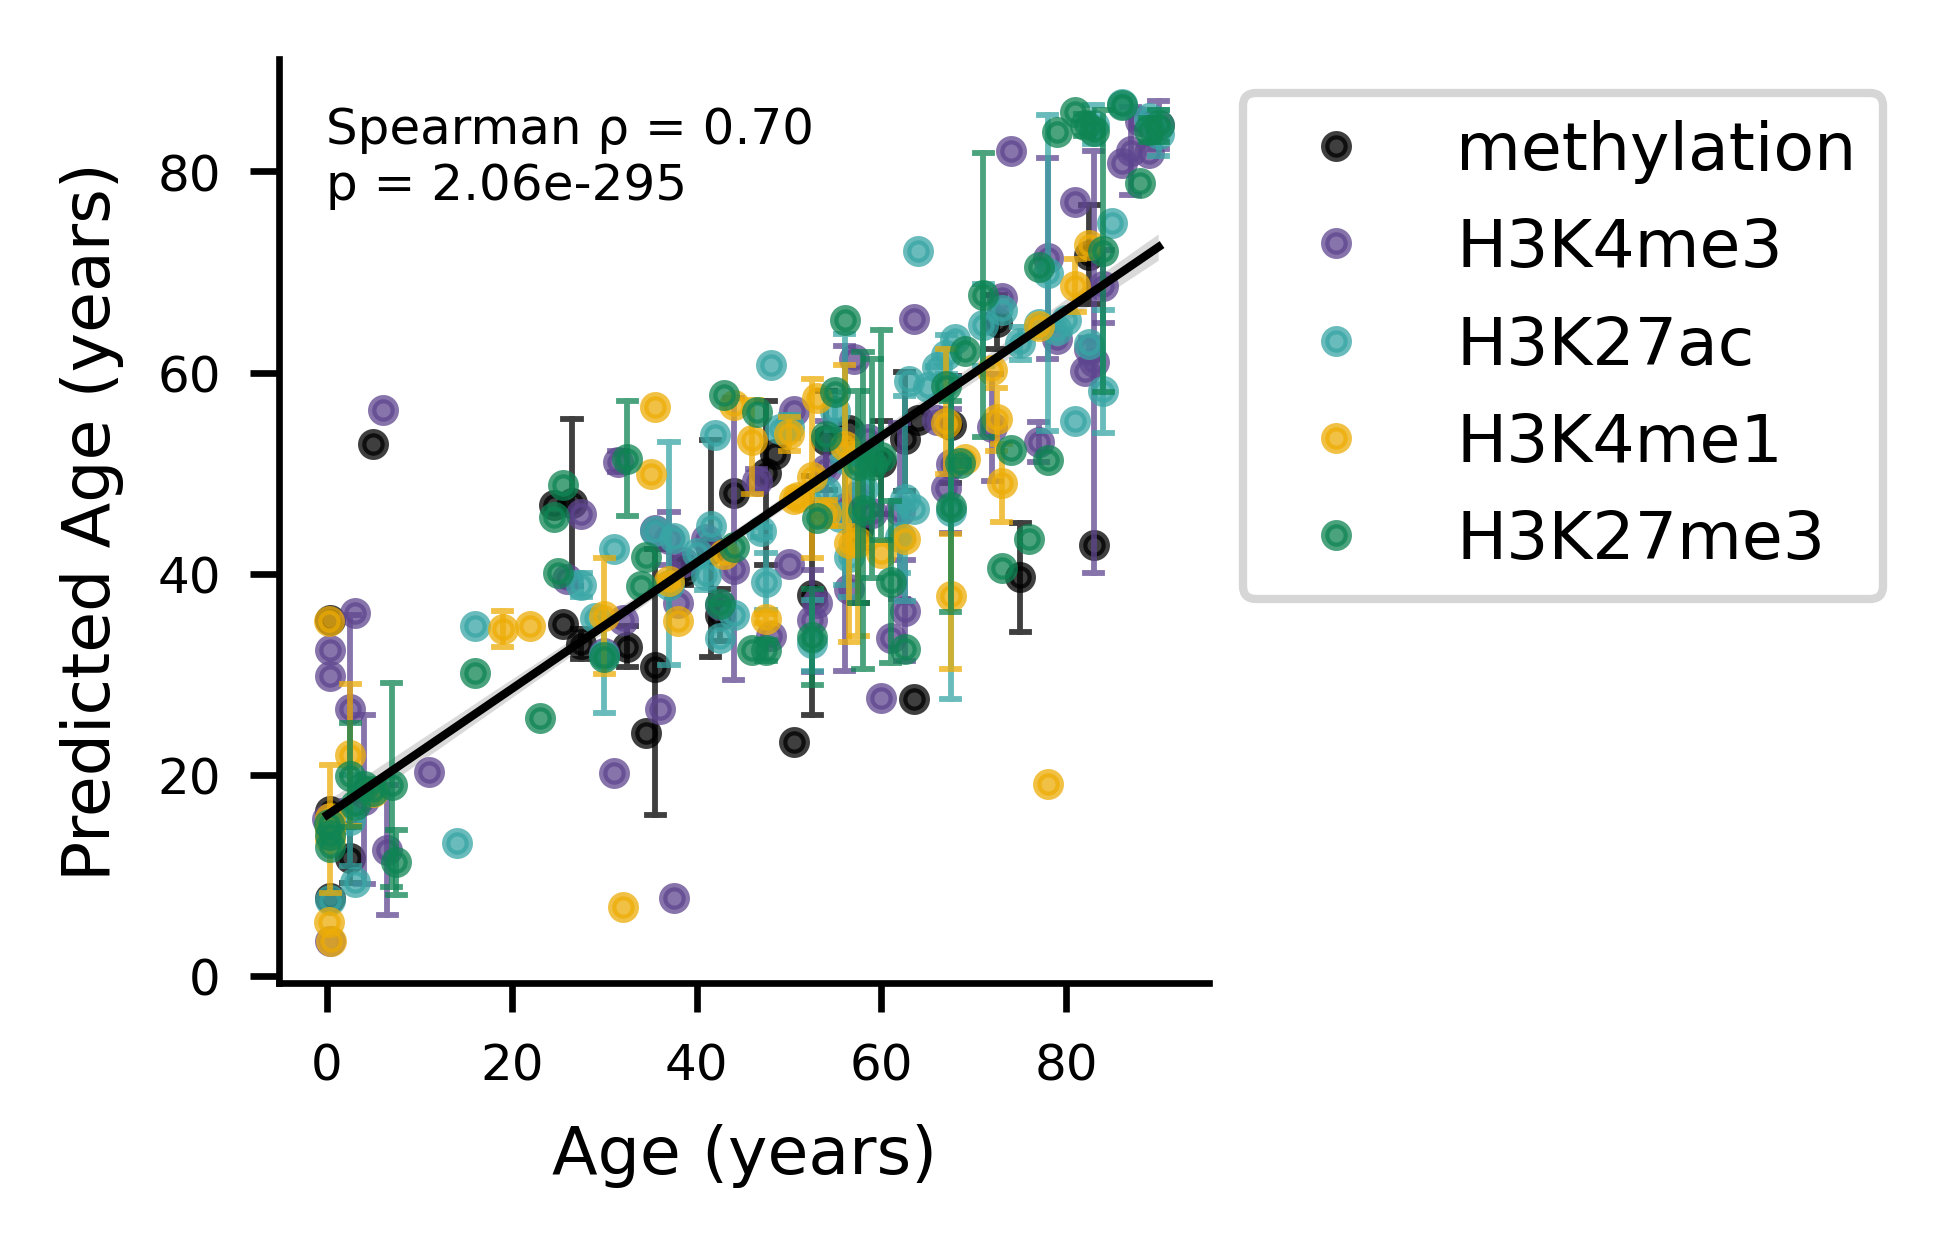

In [15]:
fig, ax = plt.subplots(figsize = (2, 2))
mean_df = pan_epigenetic_filled.combined_data_matrix.loc[
    (pan_epigenetic_filled.combined_data_matrix['species'] == 'human')
    ].groupby('donor')[['age_years', 'pred_age']].mean()
mean_df['histone_mark'] = mean_df.index.map(pan_epigenetic_filled.combined_data_matrix.set_index('donor')['histone_mark'].to_dict())
# map in histone mark
sns.pointplot(
    data = mean_df,
    x = 'age_years', y = 'pred_age', hue = 'histone_mark',
    ax = ax, palette=hmark_colors,# s = 13, 
    alpha = 0.75, legend = True, join = False, native_scale=True,
    errwidth = .7, capsize = 1000, scale = 0.5
    )
# move legend to the right and put in box
ax.legend(loc = 'upper left', bbox_to_anchor = (1, 1), frameon = True)
sns.regplot(
    data = pan_epigenetic_filled.combined_data_matrix.loc[pan_epigenetic_filled.combined_data_matrix['species'] == 'human'],
    x = 'age_years', y = 'pred_age', color = 'black', ax = ax, scatter = False, robust = True,
    line_kws = {'linewidth': 1}
    )
# add pearson correlation
r, p = spearmanr(
    pan_epigenetic_filled.combined_data_matrix.loc[pan_epigenetic_filled.combined_data_matrix['species'] == 'human'].dropna(subset = ['age_years', 'pred_age'])['age_years'],
    pan_epigenetic_filled.combined_data_matrix.loc[pan_epigenetic_filled.combined_data_matrix['species'] == 'human'].dropna(subset = ['age_years', 'pred_age'])['pred_age']
    )
ax.text(0.05, 0.95, f'Spearman ρ = {r:.2f}\np = {p:.2e}', transform=ax.transAxes, fontsize=6, verticalalignment='top')
# rename axes
ax.set_xlabel('Age (years)')
ax.set_ylabel('Predicted Age (years)')
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/age_prediction/overall_scatter_human.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

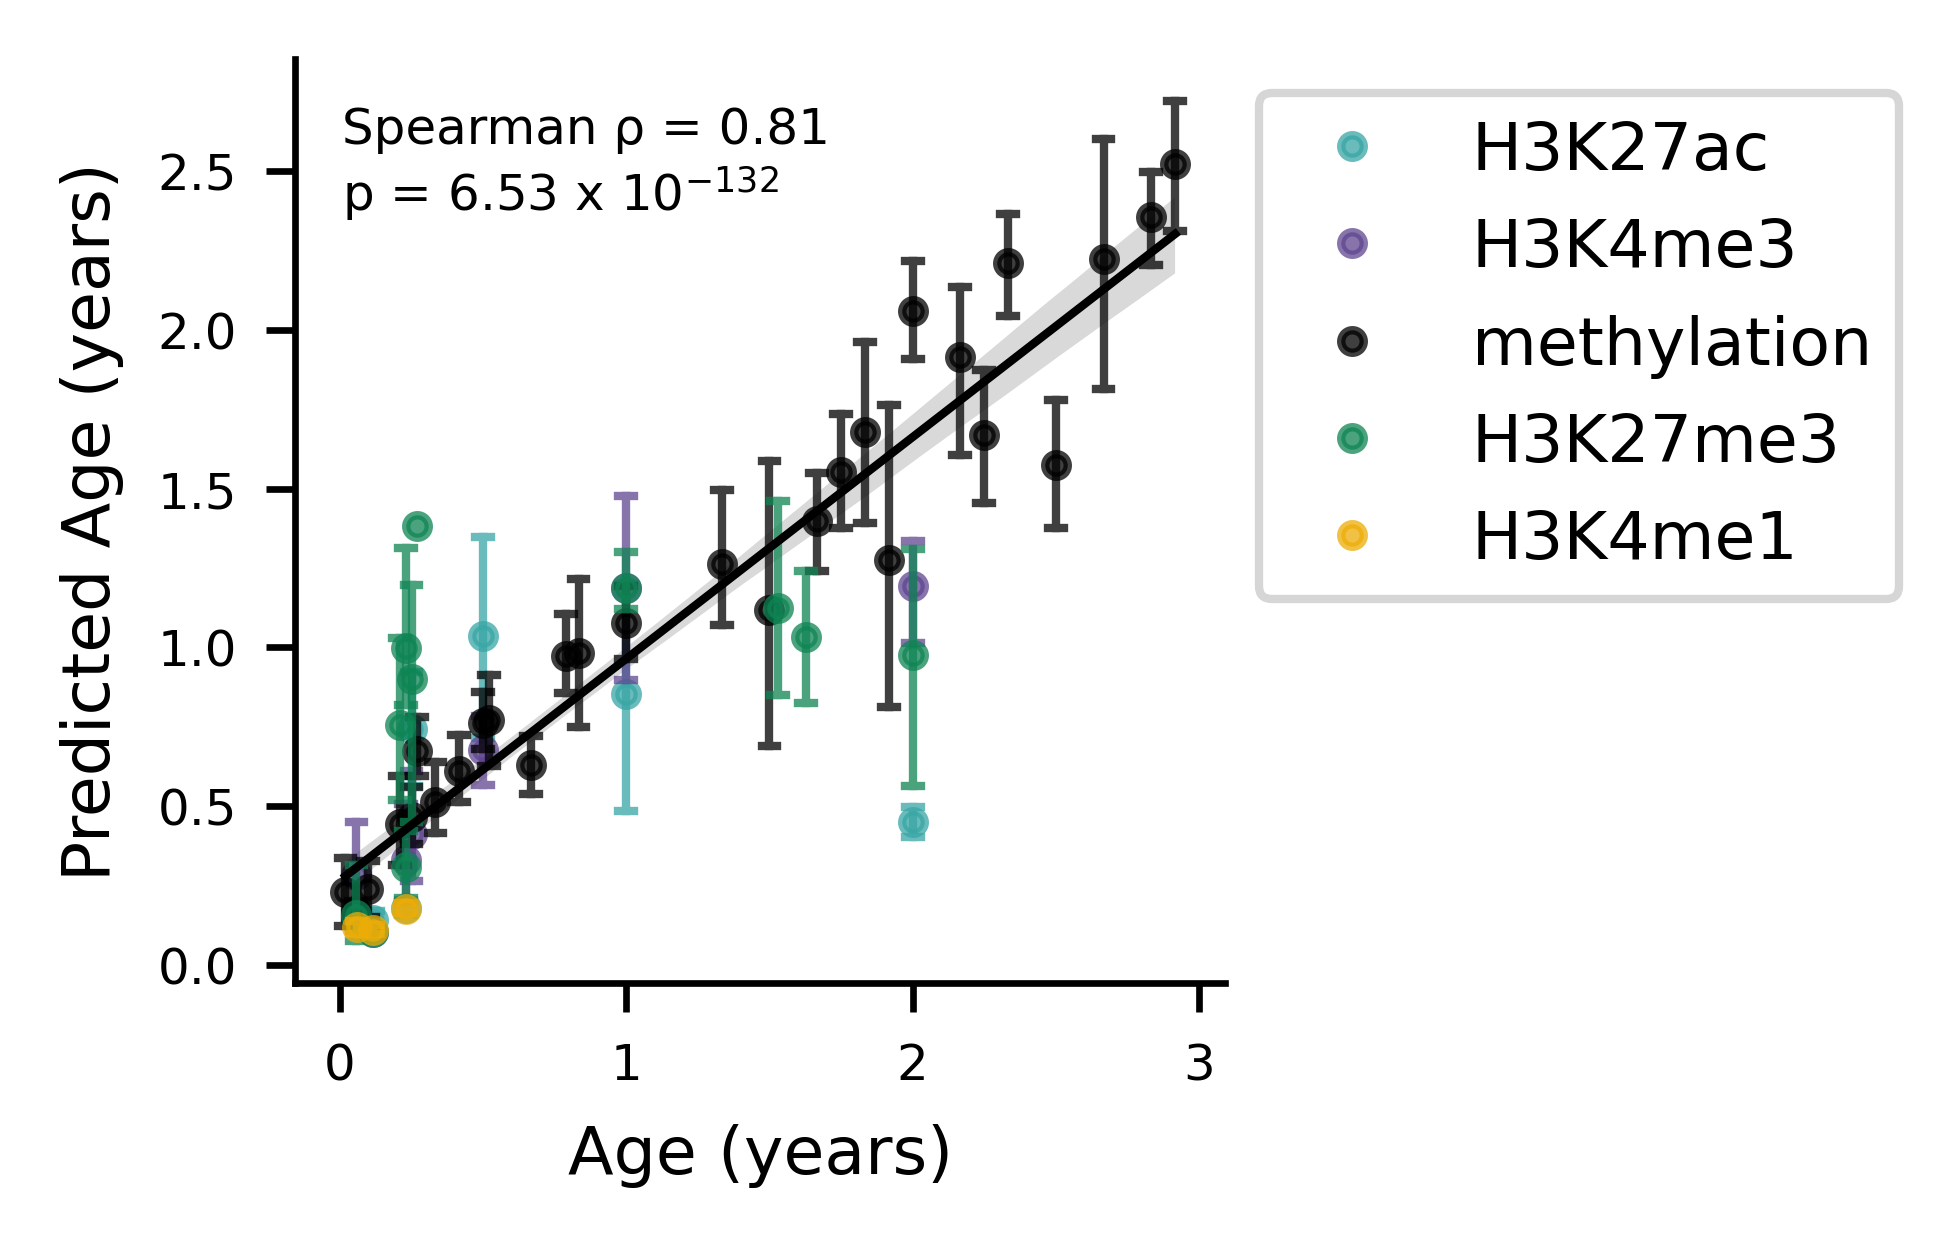

In [17]:
fig, ax = plt.subplots(figsize = (2, 2))
mean_df = pan_epigenetic_filled.combined_data_matrix.loc[(pan_epigenetic_filled.combined_data_matrix['species'] == 'mouse')].groupby('donor')[['age_years', 'pred_age']].mean()
mean_df['histone_mark'] = mean_df.index.map(pan_epigenetic_filled.combined_data_matrix.set_index('donor')['histone_mark'].to_dict())
# map in histone mark
sns.pointplot(
    data = mean_df,
    x = 'age_years', y = 'pred_age', hue = 'histone_mark',
    ax = ax, palette=hmark_colors,# s = 13, 
    alpha = 0.75, legend = True, join = False, native_scale=True,
    errwidth = 1, capsize = 50, scale = 0.5,
    )
# move legend to the right and put in box
ax.legend(loc = 'upper left', bbox_to_anchor = (1, 1), frameon = True)
sns.regplot(
    data = pan_epigenetic_filled.combined_data_matrix.loc[pan_epigenetic_filled.combined_data_matrix['species'] == 'mouse'], x = 'age_years', y = 'pred_age', color = 'black', ax = ax, scatter = False, robust = True, line_kws = {'linewidth': 1}
    )
# add pearson correlation
r, p = spearmanr(
    pan_epigenetic_filled.combined_data_matrix.loc[pan_epigenetic_filled.combined_data_matrix['species'] == 'mouse'].dropna(subset = ['age_years', 'pred_age'])['age_years'],
    pan_epigenetic_filled.combined_data_matrix.loc[pan_epigenetic_filled.combined_data_matrix['species'] == 'mouse'].dropna(subset = ['age_years', 'pred_age'])['pred_age']
    )
p_str = f"{p:.2e}".split('e')[0] + " x 10$^{" + f"{p:.2e}".split('e')[1] + "}$"
ax.text(0.05, 0.95, f'Spearman ρ = {r:.2f}\np = {p_str}', transform=ax.transAxes, fontsize=6, verticalalignment='top')
# rename axes
ax.set_xlabel('Age (years)')
ax.set_ylabel('Predicted Age (years)')
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/age_prediction/overall_scatter_mouse.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

### Synchronization of residuals

In [ ]:
# Get histone and methylation samples from CEEHRC dataset
hmark_ceehrc_pred_df = pan_epigenetic_filled.combined_data_matrix[
    (pan_epigenetic_filled.combined_data_matrix['dataset'] == 'ceehrc_hmark')
]
methyl_ceehrc_pred_df = pan_epigenetic_filled.combined_data_matrix[
    (pan_epigenetic_filled.combined_data_matrix['dataset'] == 'CEEHRC')
]

# Find common donors between the two datasets
common_donors = set(hmark_ceehrc_pred_df['donor']).intersection(set(methyl_ceehrc_pred_df['donor']))

# Filter both dataframes to only include common donors
hmark_ceehrc_common = hmark_ceehrc_pred_df[hmark_ceehrc_pred_df['donor'].isin(common_donors)]
methyl_ceehrc_common = methyl_ceehrc_pred_df[methyl_ceehrc_pred_df['donor'].isin(common_donors)]

# Create combined dataframe
ceehrc_combined = pd.merge(
    hmark_ceehrc_common,
    methyl_ceehrc_common,
    on='donor',
    suffixes=('_hmark', '_methyl')
)

# regress pred_age_hmark on age_years_hmark and pred_age_methyl on age_years_methyl
model_hmark = smf.ols('pred_age_hmark ~ age_years_hmark', data=ceehrc_combined).fit()
model_methyl = smf.ols('pred_age_methyl ~ age_years_methyl', data=ceehrc_combined).fit()

# add residuals to combined dataframe
ceehrc_combined['hmark_residual'] = model_hmark.resid
ceehrc_combined['methyl_residual'] = model_methyl.resid

# Create a long-format dataframe with both histone mark and methylation data
pivoted_df = pd.DataFrame()

# Add histone mark data
for hmark in ceehrc_combined['histone_mark_hmark'].unique():
    hmark_subset = ceehrc_combined[ceehrc_combined['histone_mark_hmark'] == hmark].copy()
    
    # Add histone mark rows
    hmark_data = pd.DataFrame({
        'donor': hmark_subset['donor'],
        'data_type': f'histone_mark_{hmark}',
        'pred_age': hmark_subset['pred_age_hmark'],
        'age_years': hmark_subset['age_years_hmark'],
        'residual': hmark_subset['hmark_residual']
    })
    pivoted_df = pd.concat([pivoted_df, hmark_data], ignore_index=True)
    
    # Add methylation rows for the same donors
    methyl_data = pd.DataFrame({
        'donor': hmark_subset['donor'],
        'data_type': 'methylation',
        'pred_age': hmark_subset['pred_age_methyl'],
        'age_years': hmark_subset['age_years_methyl'],
        'residual': hmark_subset['methyl_residual']
    })
    pivoted_df = pd.concat([pivoted_df, methyl_data], ignore_index=True)

# Group by data_type and fit OLS models to calculate residuals
data_types = pivoted_df['data_type'].unique()
residual_df = pd.DataFrame()

for data_type in data_types:
    # Filter data for this data_type
    subset = pivoted_df[pivoted_df['data_type'] == data_type].copy()
    
    # Fit OLS model
    model = smf.ols('pred_age ~ age_years', data=subset).fit()
    
    # Add residuals
    subset['model_residual'] = model.resid
    
    # Append to the result dataframe
    residual_df = pd.concat([residual_df, subset], ignore_index=True)

mean_residual_df = residual_df.groupby(['donor', 'data_type']).agg({'model_residual': 'mean'}).reset_index()

data_type1             data_type2  correlation       p_value  \
0   histone_mark_H3K4me1            methylation     0.288592  2.340115e-03   
1   histone_mark_H3K4me1  histone_mark_H3K27me3     0.386903  3.529448e-05   
2   histone_mark_H3K4me1   histone_mark_H3K27ac     0.396904  4.343810e-05   
3   histone_mark_H3K4me1   histone_mark_H3K4me3     0.344324  2.462087e-04   
4            methylation  histone_mark_H3K27me3     0.201082  3.691013e-02   
5            methylation   histone_mark_H3K27ac     0.227795  2.264548e-02   
6            methylation   histone_mark_H3K4me3     0.162997  9.036718e-02   
7  histone_mark_H3K27me3   histone_mark_H3K27ac     0.469511  9.464950e-07   
8  histone_mark_H3K27me3   histone_mark_H3K4me3     0.362476  1.156895e-04   
9   histone_mark_H3K27ac   histone_mark_H3K4me3     0.512991  4.841406e-08   

   n_samples  n_donors  
0        109       109  
1        108       108  
2        100       100  
3        109       109  
4        108       108  
5        100       100  
6        109       109  
7         99        99  
8        108       108  
9        100       100

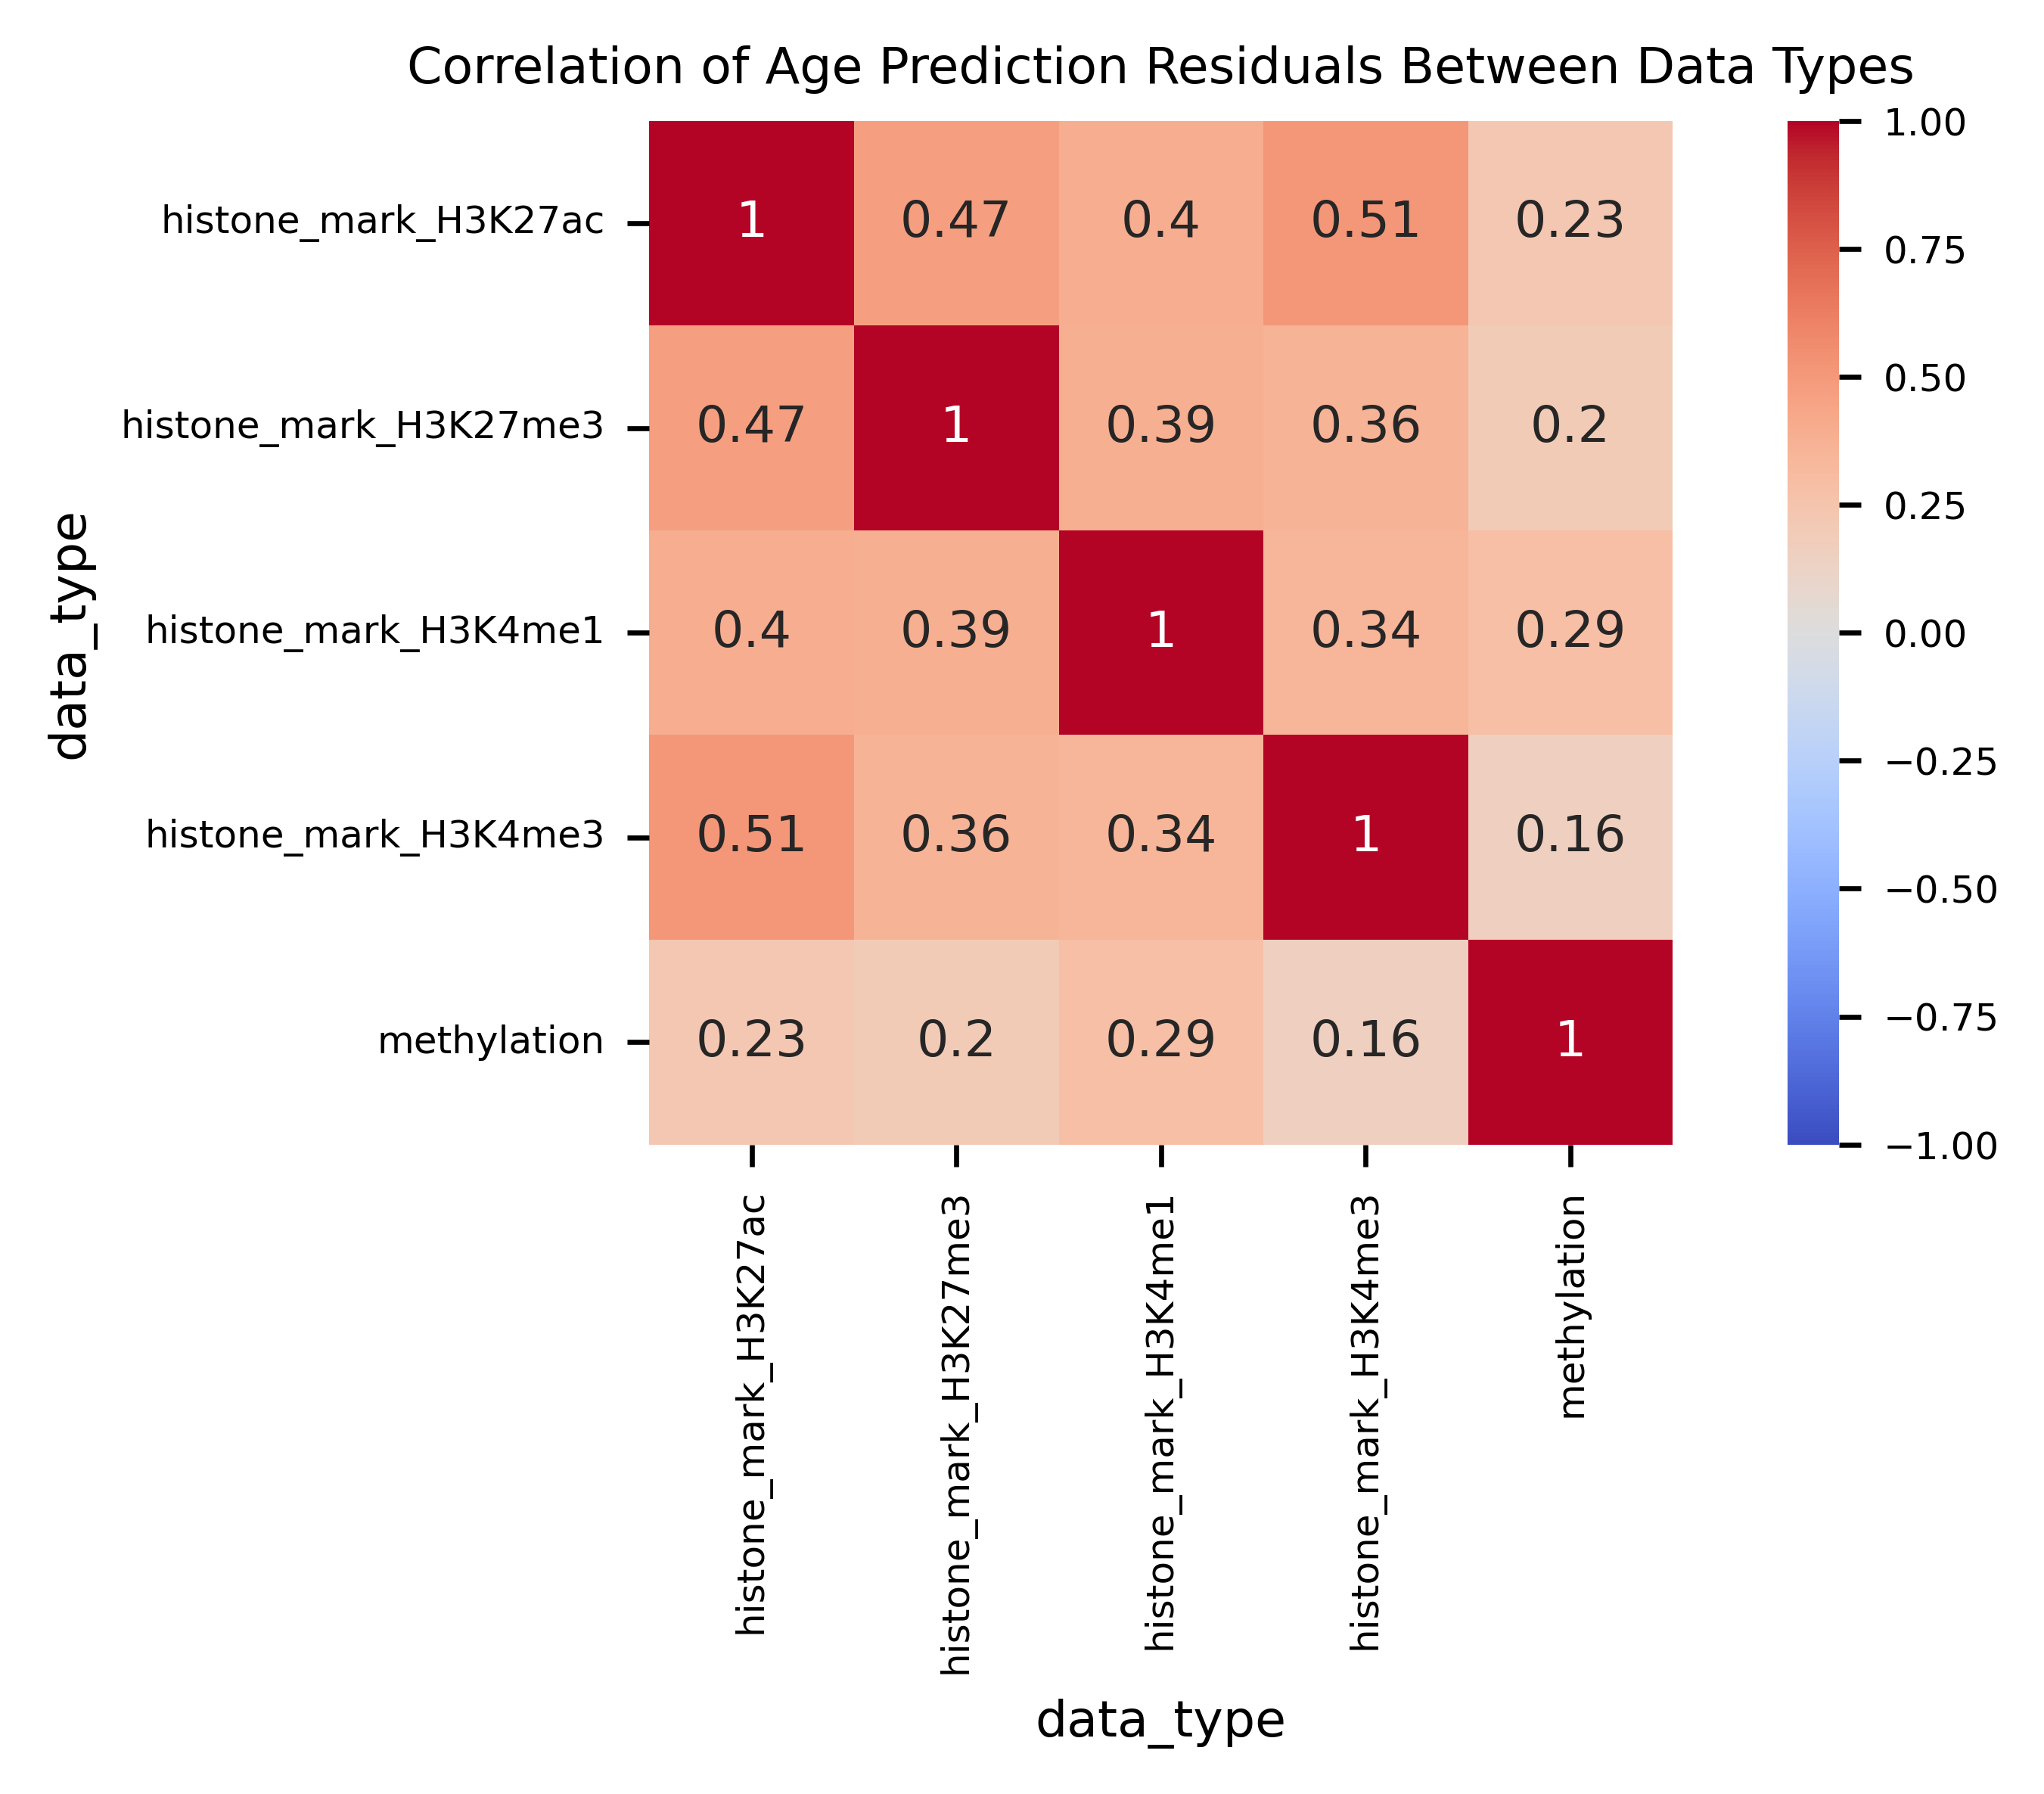

In [15]:
# Create a pivot table with donors as index and data_types as columns, values are model_residuals
residual_pivot = mean_residual_df.pivot(index='donor', columns='data_type', values='model_residual')

# Calculate correlation matrix
correlation_matrix = residual_pivot.corr(method = 'spearman')

# Create a heatmap visualization
plt.figure(figsize=(6, 4))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1, 
    center=0,
    square=True,
)
plt.title('Correlation of Age Prediction Residuals Between Data Types')
plt.tight_layout()

# Alternative: Calculate pairwise correlations manually with p-values
data_types = residual_df['data_type'].unique()
results = []

for i, type1 in enumerate(data_types):
    for j, type2 in enumerate(data_types):
        if i < j:  # To avoid duplicates and self-comparisons
            # Get residuals for each data type
            df1 = mean_residual_df[mean_residual_df['data_type'] == type1][['donor', 'model_residual']]
            df2 = mean_residual_df[mean_residual_df['data_type'] == type2][['donor', 'model_residual']]
            
            # Merge on donor to match samples
            merged = pd.merge(
                df1, df2, 
                on='donor', 
                suffixes=(f'_{type1}', f'_{type2}')
            )
            
            # Calculate correlation and p-value
            if merged.shape[0] > 1:  # Need at least 2 samples for correlation
                corr, p_value = spearmanr(
                    merged[f'model_residual_{type1}'], 
                    merged[f'model_residual_{type2}']
                )
                n = merged.shape[0]
                results.append({
                    'data_type1': type1, 
                    'data_type2': type2, 
                    'correlation': corr, 
                    'p_value': p_value,
                    'n_samples': n,
                    'n_donors': len(merged['donor'].unique())
                })

# Convert to dataframe
correlation_results = pd.DataFrame(results)
correlation_results

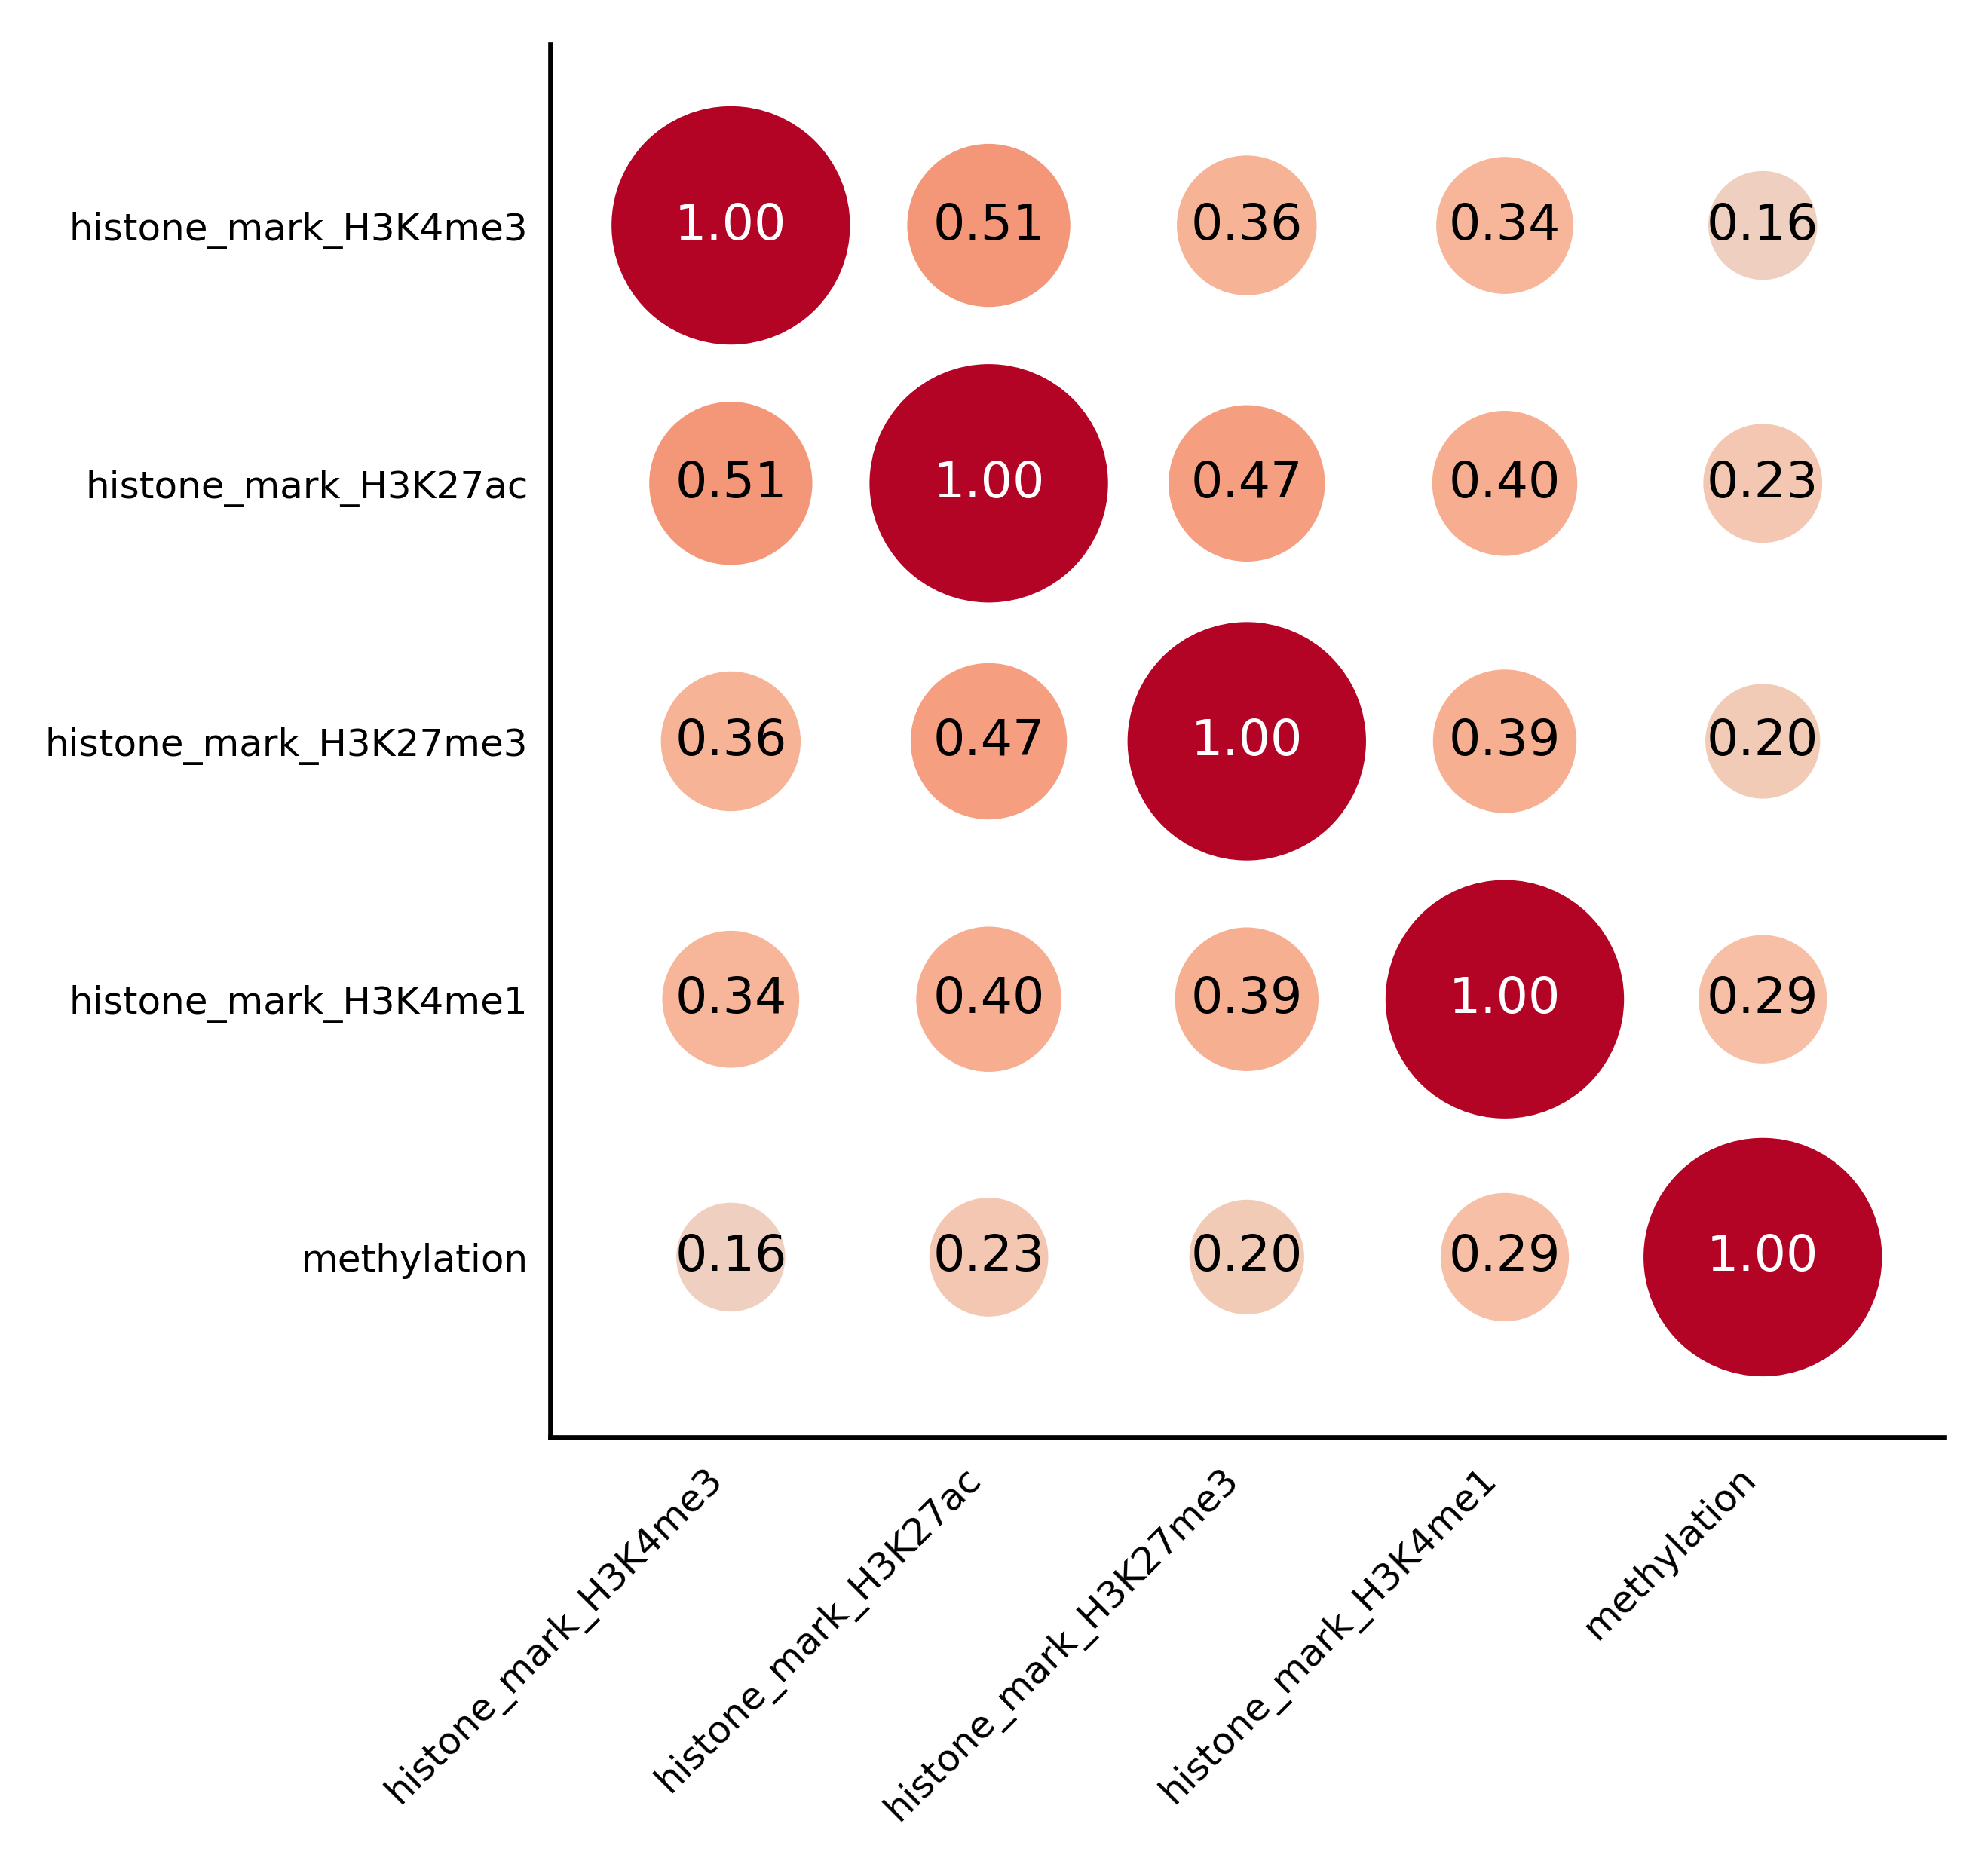

In [72]:
# Create a figure for the correlation circle heatmap
fig, ax = plt.subplots(figsize=(6, 4))
# set order 
order = ['histone_mark_H3K4me3', 'histone_mark_H3K27ac', 'histone_mark_H3K27me3', 'histone_mark_H3K4me1', 'methylation']
reverse_order = order[::-1]
correlation_matrix = correlation_matrix[order]
correlation_matrix = correlation_matrix.loc[reverse_order]


# Get the correlation matrix data
data = correlation_matrix.values
x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
colors = plt.cm.coolwarm((data - (-1)) / (1 - (-1)))  # Normalize data to [0,1] for colormap

# Scale circle sizes based on absolute value
max_radius = 0.45
min_radius = 0.15
abs_data = np.abs(data)
scaled_sizes = min_radius + (max_radius - min_radius) * (abs_data / abs_data.max())

# Draw the circles
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        
        circle = plt.Circle((j + 0.5, i + 0.5), scaled_sizes[i,j],
                        color=colors[i,j])
        ax.add_patch(circle)
        
        # Add text annotation with correlation value
        if abs_data[i,j] > 0.1:  # Only show text for non-zero correlations
            ax.text(j + 0.5, i + 0.5, f'{data[i,j]:.2f}', 
                  ha='center', va='center', 
                  color='black' if abs_data[i,j] < 0.7 else 'white',  # Make text readable
                  fontsize=8, )
        
            

# Set the plot limits and ticks
ax.set_xlim(-0.2, data.shape[1] + 0.2)
ax.set_ylim(-0.2, data.shape[0] + 0.2)
ax.set_xticks(np.arange(data.shape[1]) + 0.5)
ax.set_yticks(np.arange(data.shape[0]) + 0.5)
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(correlation_matrix.index)
ax.set_aspect('equal')


# Remove tick marks
ax.tick_params(axis='both', which='both', length=0)



plt.savefig('/cellar/users/zkoch/histone_mark_proj/figures/age_prediction/residual_correlation_circles.svg', 
           format='svg', dpi=300, bbox_inches='tight', transparent=True)

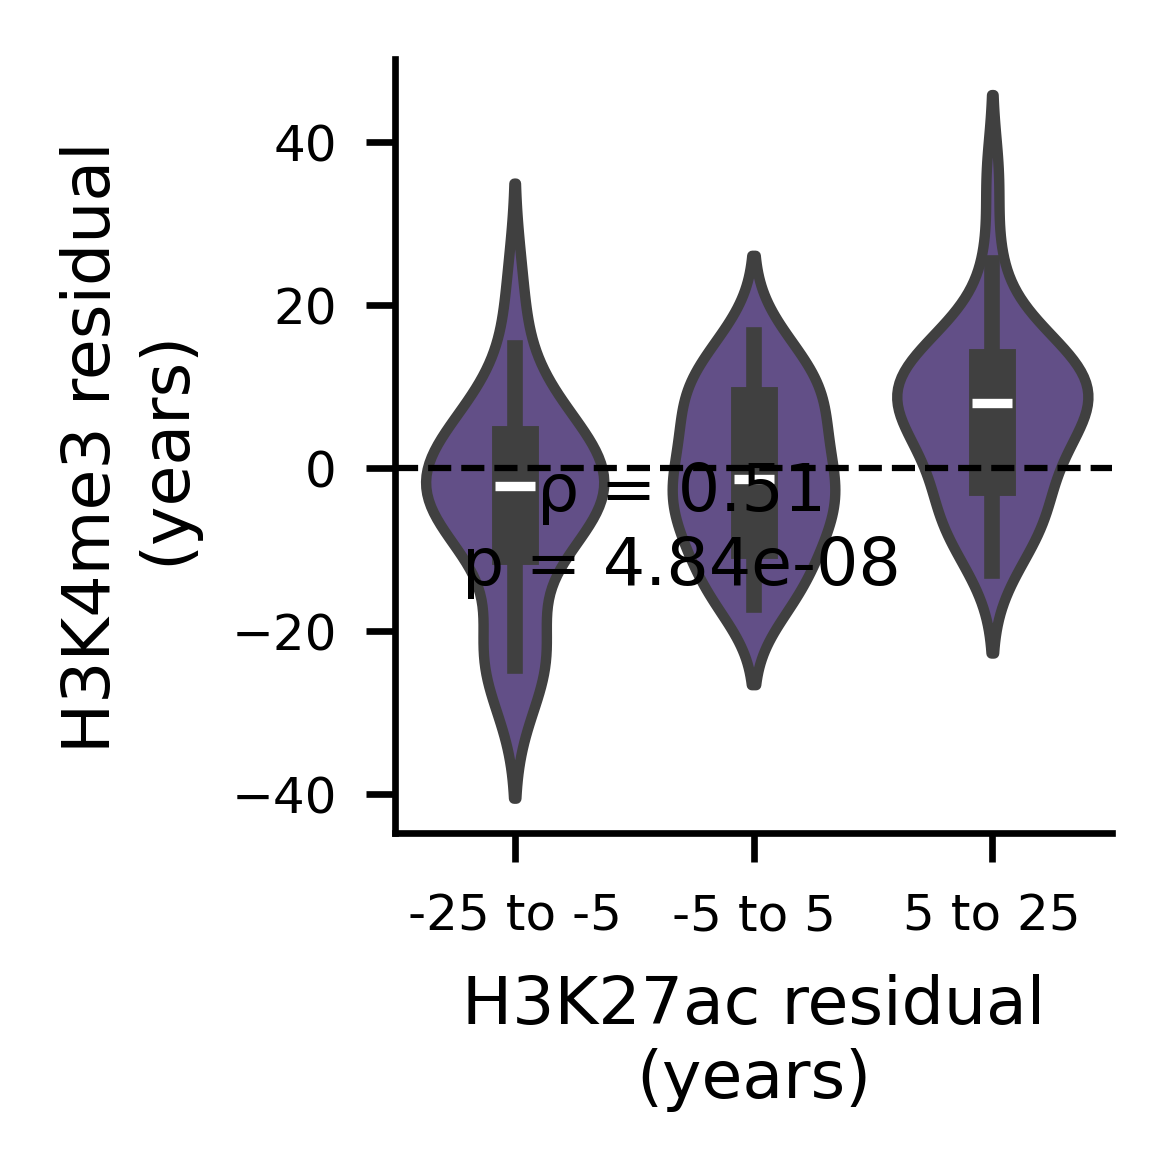

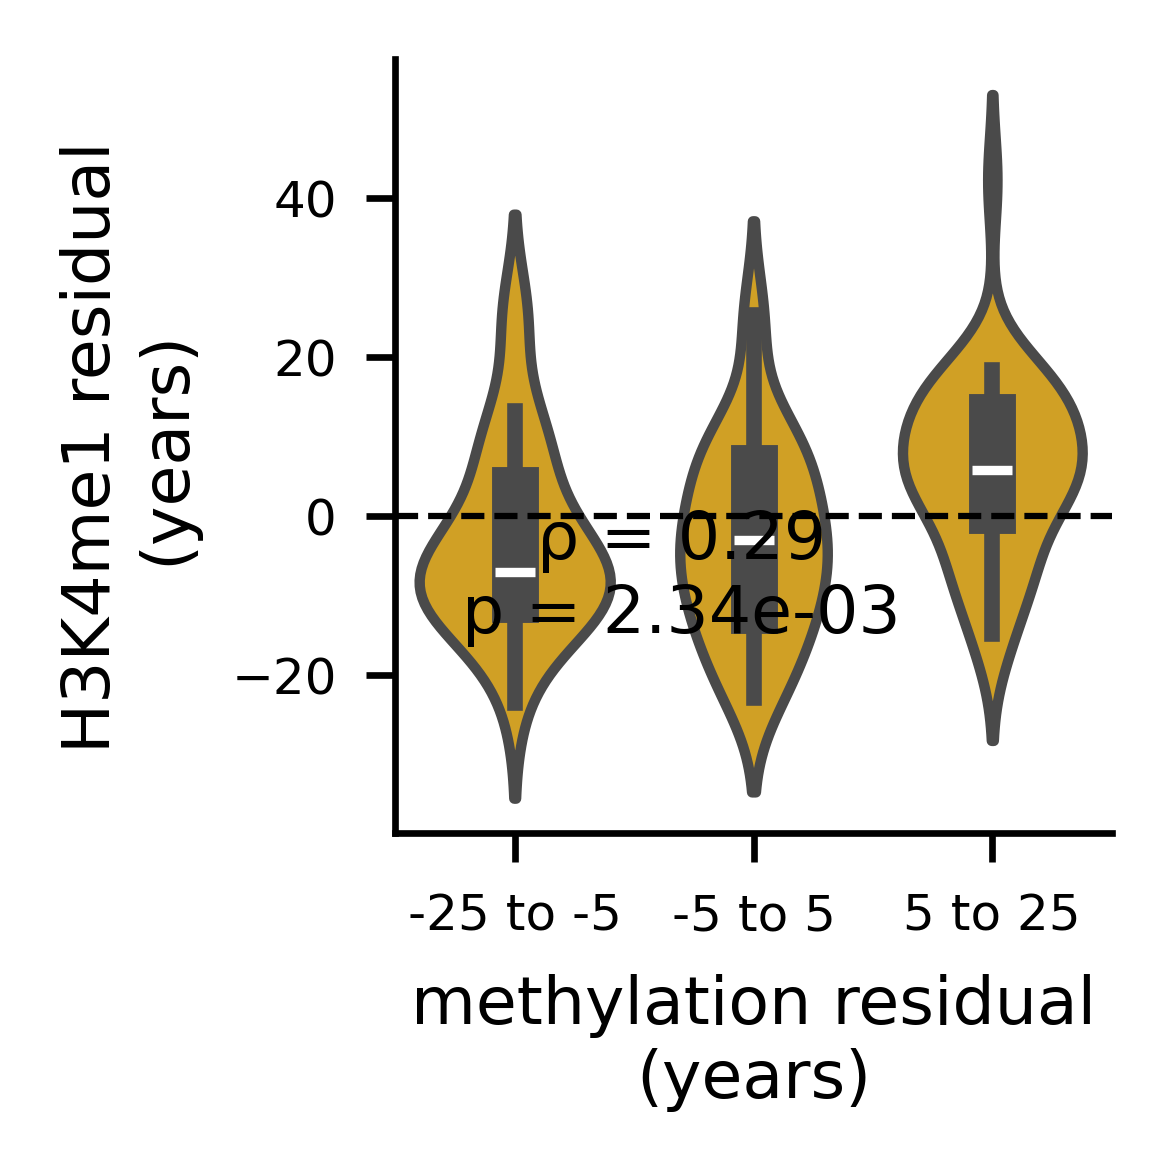

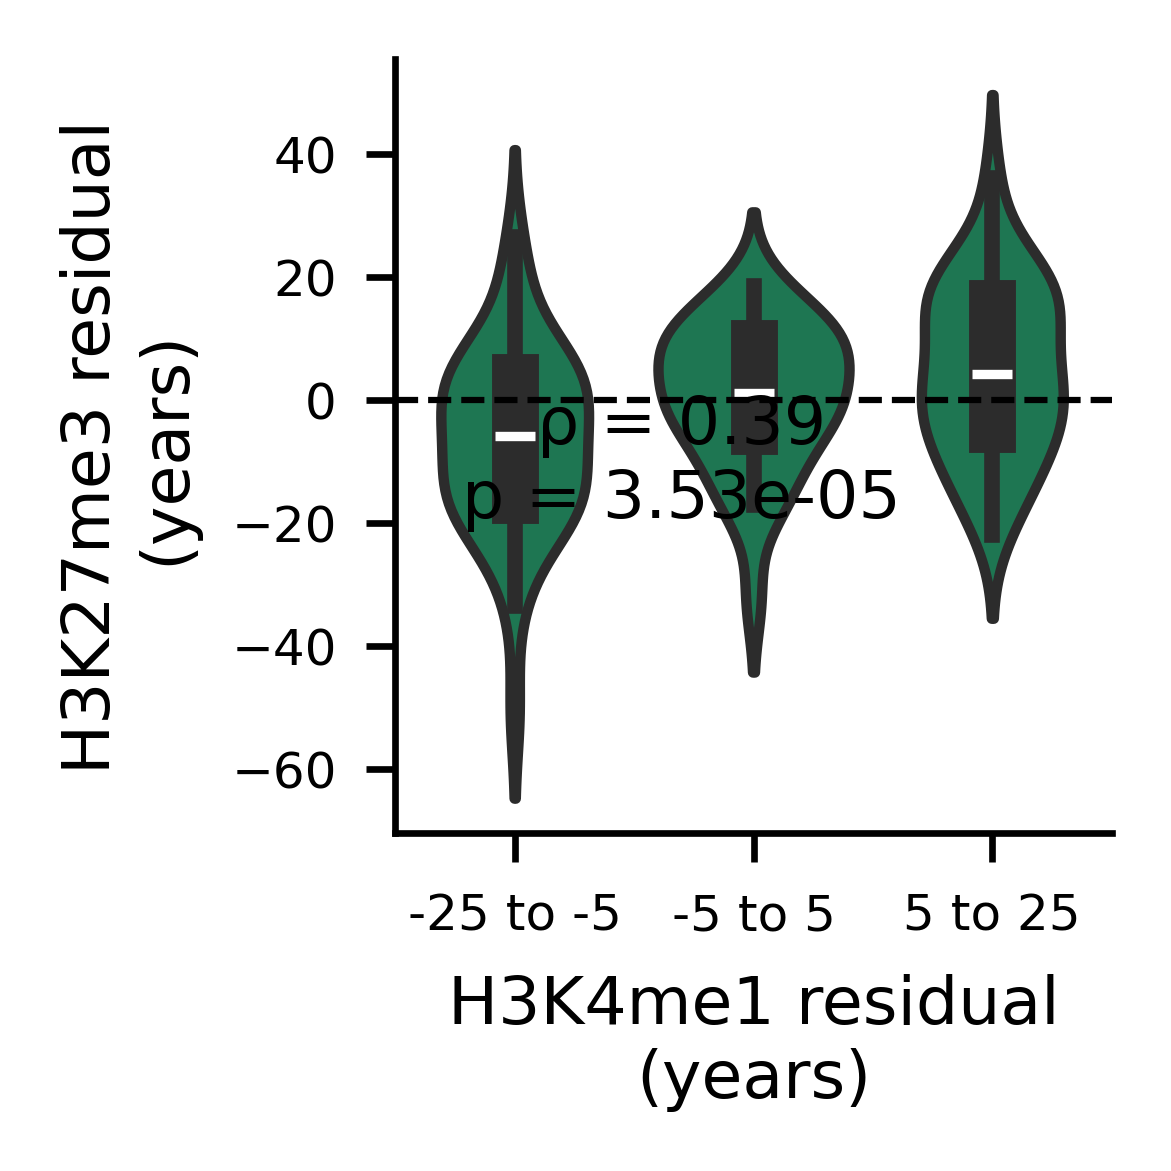

In [88]:
def plot_residual_comparison(residual_df, data_type1, data_type2, figsize=(10, 6), save_path=None):
    """
    Plot residuals for a pair of data types (e.g., histone marks) as violin plots.
    
    Parameters:
    -----------
    residual_df : DataFrame
        DataFrame containing the residuals data with columns 'donor', 'data_type', 'model_residual'
    data_type1 : str
        First data type to compare
    data_type2 : str
        Second data type to compare
    figsize : tuple, optional
        Figure size (width, height) in inches
    save_path : str, optional
        Path to save the figure
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    # Get data for the two data types
    df1 = residual_df[residual_df['data_type'] == data_type1][['donor', 'model_residual']]
    df2 = residual_df[residual_df['data_type'] == data_type2][['donor', 'model_residual']]
    
    # Merge on donor to match samples
    merged = pd.merge(
        df1, df2,
        on='donor',
        suffixes=(f'_{data_type1}', f'_{data_type2}')
    )
    
    # Calculate correlation and p-value
    corr, p_value = spearmanr(
        merged[f'model_residual_{data_type1}'],
        merged[f'model_residual_{data_type2}']
    )
    
    # Create a long-format DataFrame for the violin plot
    plot_data = pd.DataFrame({
        'donor': merged['donor'].tolist() * 2,
        'data_type': [data_type1] * len(merged) + [data_type2] * len(merged),
        'residual': merged[f'model_residual_{data_type1}'].tolist() + 
                    merged[f'model_residual_{data_type2}'].tolist()
    })
    
    # Create bins for residuals from the first data type
    bins = [-25, -5, 5, 25]
    # Add bin column to merged data
    merged['residual_bin'] = pd.cut(
        merged[f'model_residual_{data_type1}'], 
        bins=bins,
        labels=[f'{bins[i]} to {bins[i+1]}' for i in range(len(bins)-1)]
    )
    
    # Create figure with two subplots
    fig, ax = plt.subplots(figsize = (2, 2))
    
    
    # Create a dataframe with the necessary info for this plot
    binned_data = pd.DataFrame({
        'bin': merged['residual_bin'],
        'residual': merged[f'model_residual_{data_type2}']
    })
    
    # Plot violins
    sns.violinplot(data=binned_data, x='bin', y='residual', ax=ax, 
                   color = hmark_colors[data_type2.split("_")[-1]],)
    
    
    ax.set_xlabel(f'{data_type1.split("_")[-1]} residual\n(years)')
    ax.set_ylabel(f'{data_type2.split("_")[-1]} residual\n(years)')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.75)
    
    # add the spearman correlation coefficient to the plot and pvalue
    ax.text(0.7, 0.95, f'ρ = {corr:.2f}\np = {p_value:.2e}', fontsize=8, ha='center', va='top')

    # Adjust layout
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', format='svg', transparent=True)
    
    return fig, ax

fig1, ax1 = plot_residual_comparison(
    mean_residual_df, 
    'histone_mark_H3K27ac', 
    'histone_mark_H3K4me3', 
    save_path='/cellar/users/zkoch/histone_mark_proj/figures/age_prediction/H3K27ac_vs_H3K4me3_residuals.svg'
)

fig1, ax1 = plot_residual_comparison(
    mean_residual_df, 
    'methylation', 
    'histone_mark_H3K4me1', 
    save_path='/cellar/users/zkoch/histone_mark_proj/figures/age_prediction/methylation_vs_H3K4me1_residuals.svg'
)

fig1, ax1 = plot_residual_comparison(
    mean_residual_df, 
    'histone_mark_H3K4me1', 
    'histone_mark_H3K27me3', 
    save_path='/cellar/users/zkoch/histone_mark_proj/figures/age_prediction/H3K4me1_vs_H3K27me3_residuals.svg'
)

In [24]:
ols = smf.ols('histone_mark_H3K4me3 ~ histone_mark_H3K27ac + 0', data = residual_pivot).fit()
ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     histone_mark_H3K4me3   R-squared (uncentered):                   0.259
Model:                              OLS   Adj. R-squared (uncentered):              0.252
Method:                   Least Squares   F-statistic:                              34.64
Date:                  Wed, 21 May 2025   Prob (F-statistic):                    5.43e-08
Time:                          14:36:07   Log-Likelihood:                         -373.70
No. Observations:                   100   AIC:                                      749.4
Df Residuals:                        99   BIC:                                      752.0
Df Model:                             1                                                  
Covariance Type:              nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
histone_mark_H3K27ac     0.4512      0.077      5.886      0.000       0.299       0.603
==============================================================================
Omnibus:                        3.777   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                3.225
Skew:                           0.310   Prob(JB):                        0.199
Kurtosis:                       3.625   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Performance by epigenetic mark and species

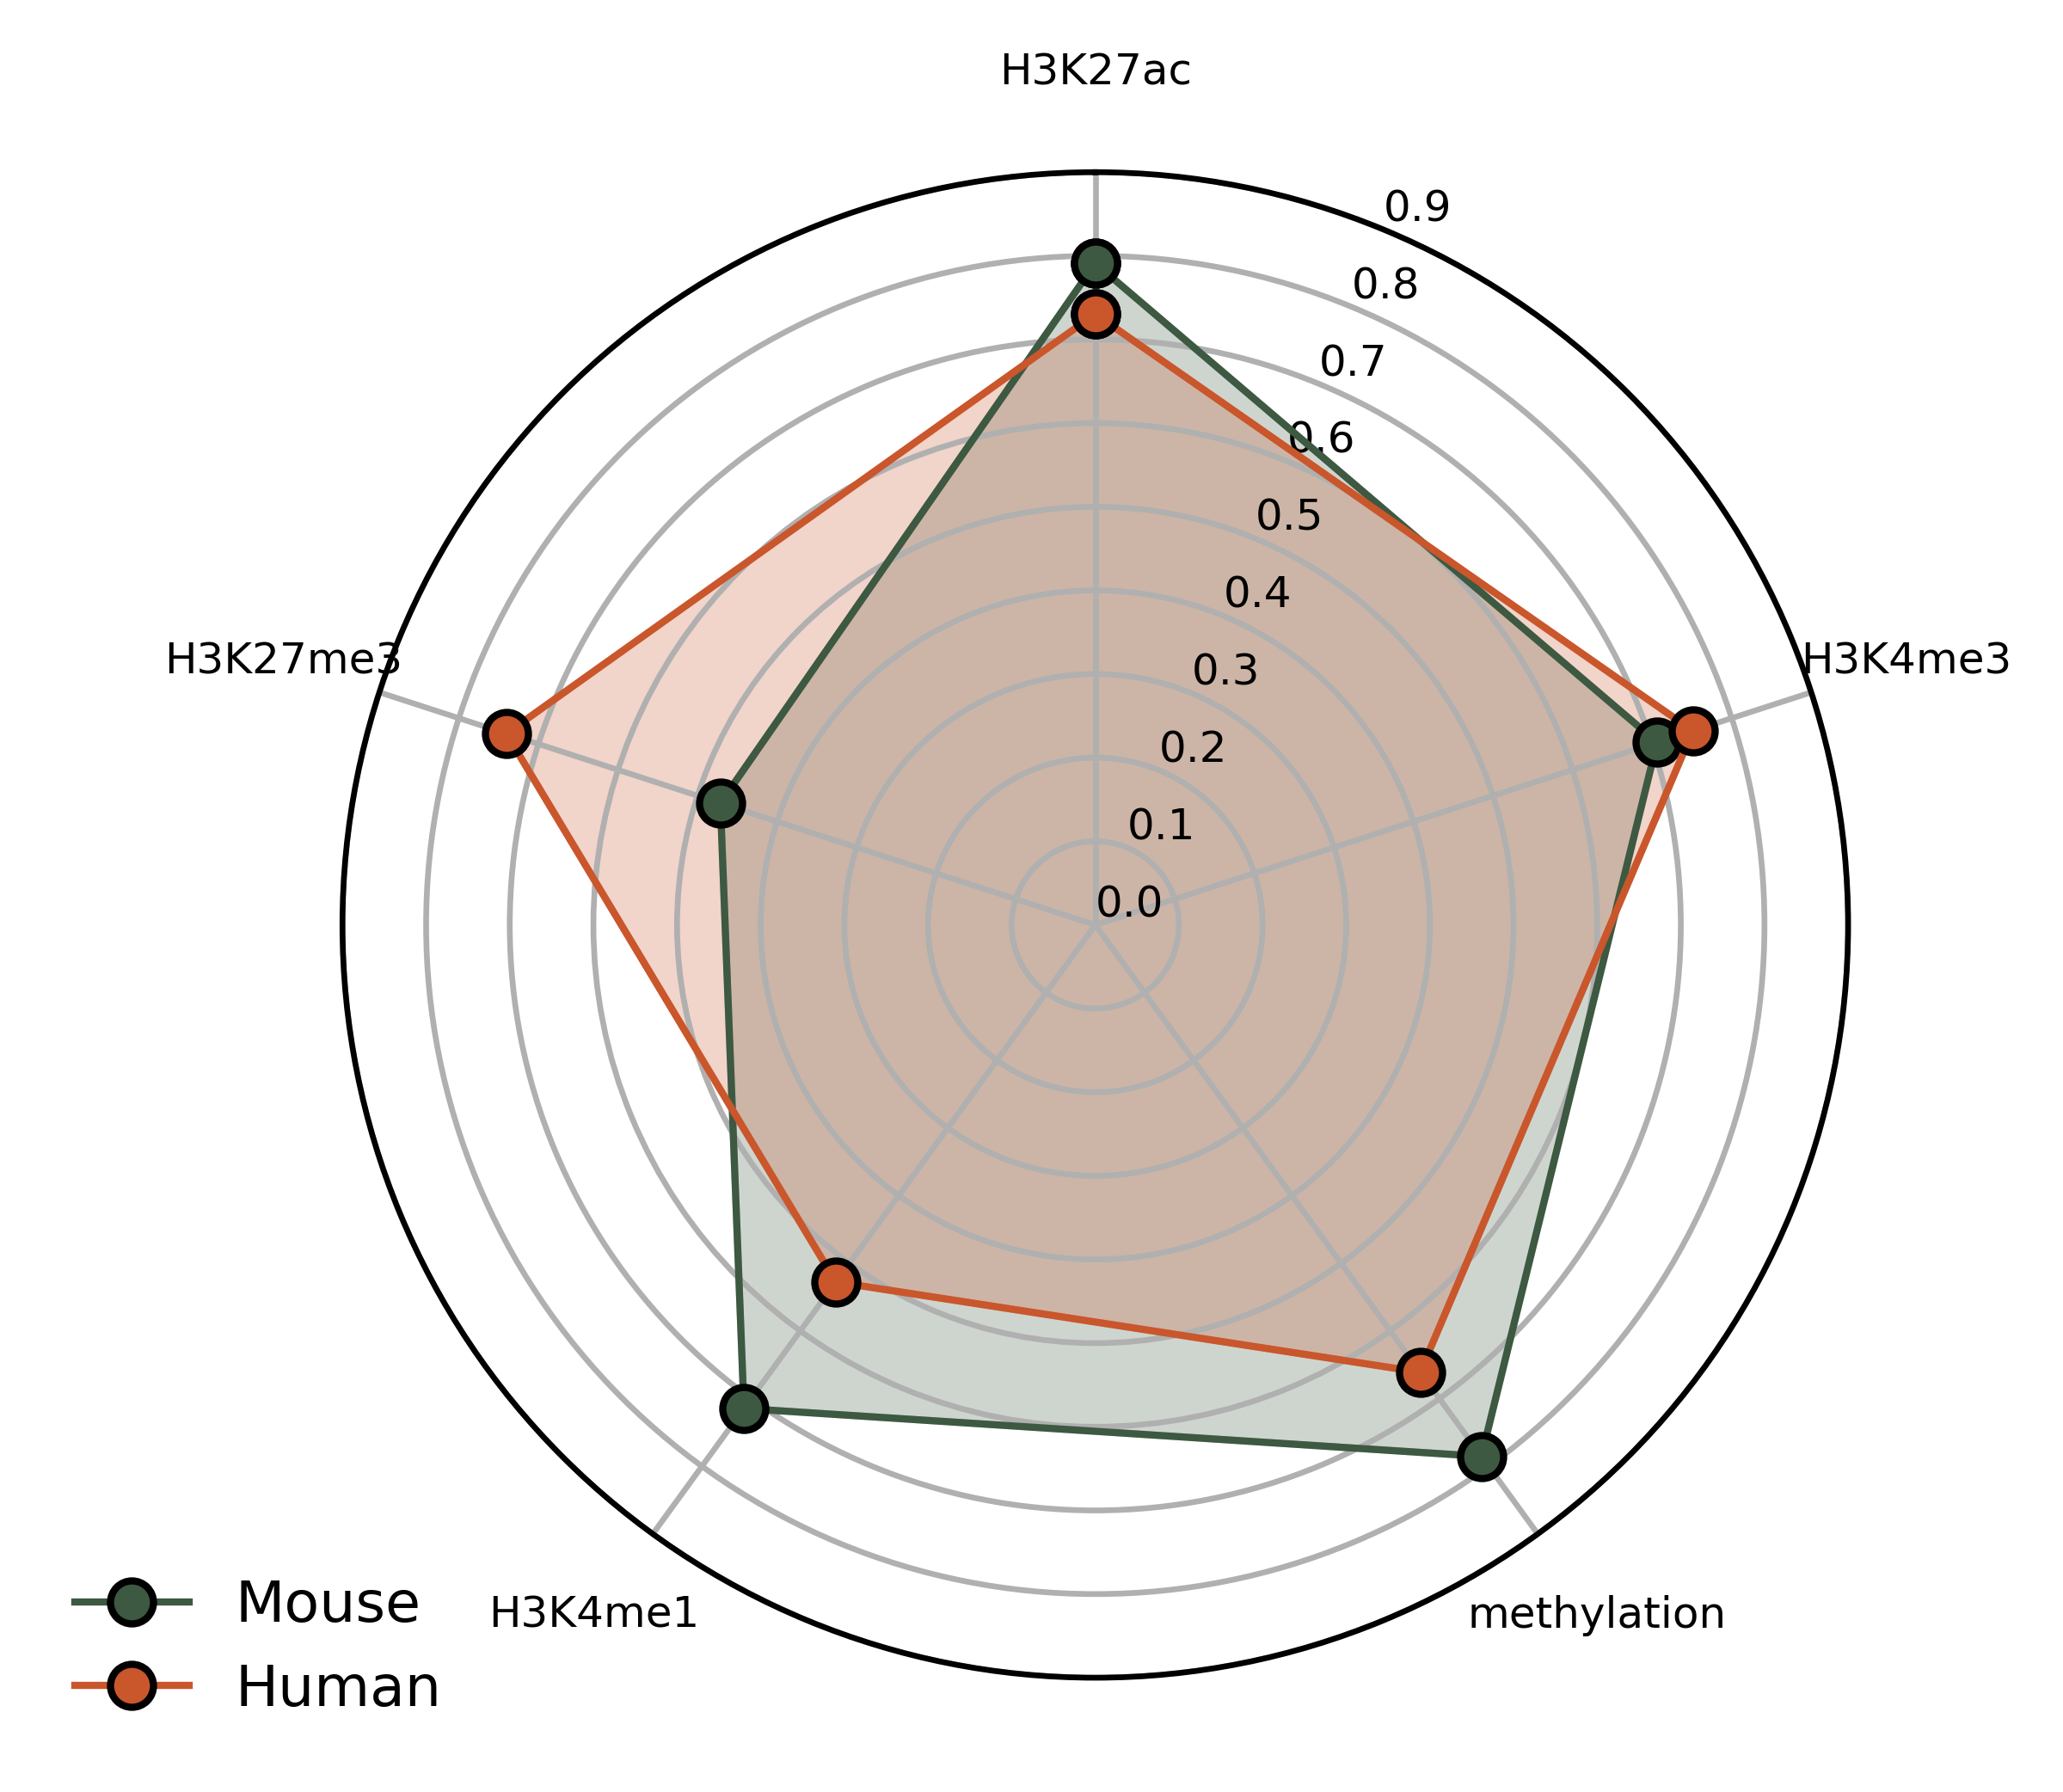

In [6]:
# compute the correlation between predicted and actual age for each mark and species
correlations = pan_epigenetic_filled.combined_data_matrix.dropna(subset = ['pred_age', 'age_years']).groupby(['histone_mark', 'species'])[['pred_age', 'age_years']].apply(lambda x: spearmanr(x['pred_age'], x['age_years'])).reset_index()
# split 0 column into r and pvalue
correlations['r'] = correlations[0].apply(lambda x: x[0])
correlations['pvalue'] = correlations[0].apply(lambda x: x[1])
correlations.drop(columns = [0], inplace = True)
# create dictionary of correlations for each mark
mouse_corrs = correlations.query("species == 'mouse'").set_index('histone_mark')['r'].to_dict()
human_corrs = correlations.query("species == 'human'").set_index('histone_mark')['r'].to_dict()

# set order based on average correlation across species
order = correlations.groupby('histone_mark')['r'].median().sort_values(ascending = False).index
# reorder mouse and human correlations
mouse_corrs = {mark: mouse_corrs[mark] for mark in order}
human_corrs = {mark: human_corrs[mark] for mark in order}

fig, ax = pan_epigenetic_filled.plot_correlation_radar(
    correlations_1 = mouse_corrs,
    correlations_2 = human_corrs,
    mark_order = order,
    label_1 = 'Mouse',
    label_2 = 'Human',
    color_1 = Fall_3.mpl_colors[0],
    color_2 = Fall_3.mpl_colors[2],
    value_range = (0,.9)
    )
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/age_prediction/radar_plot.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

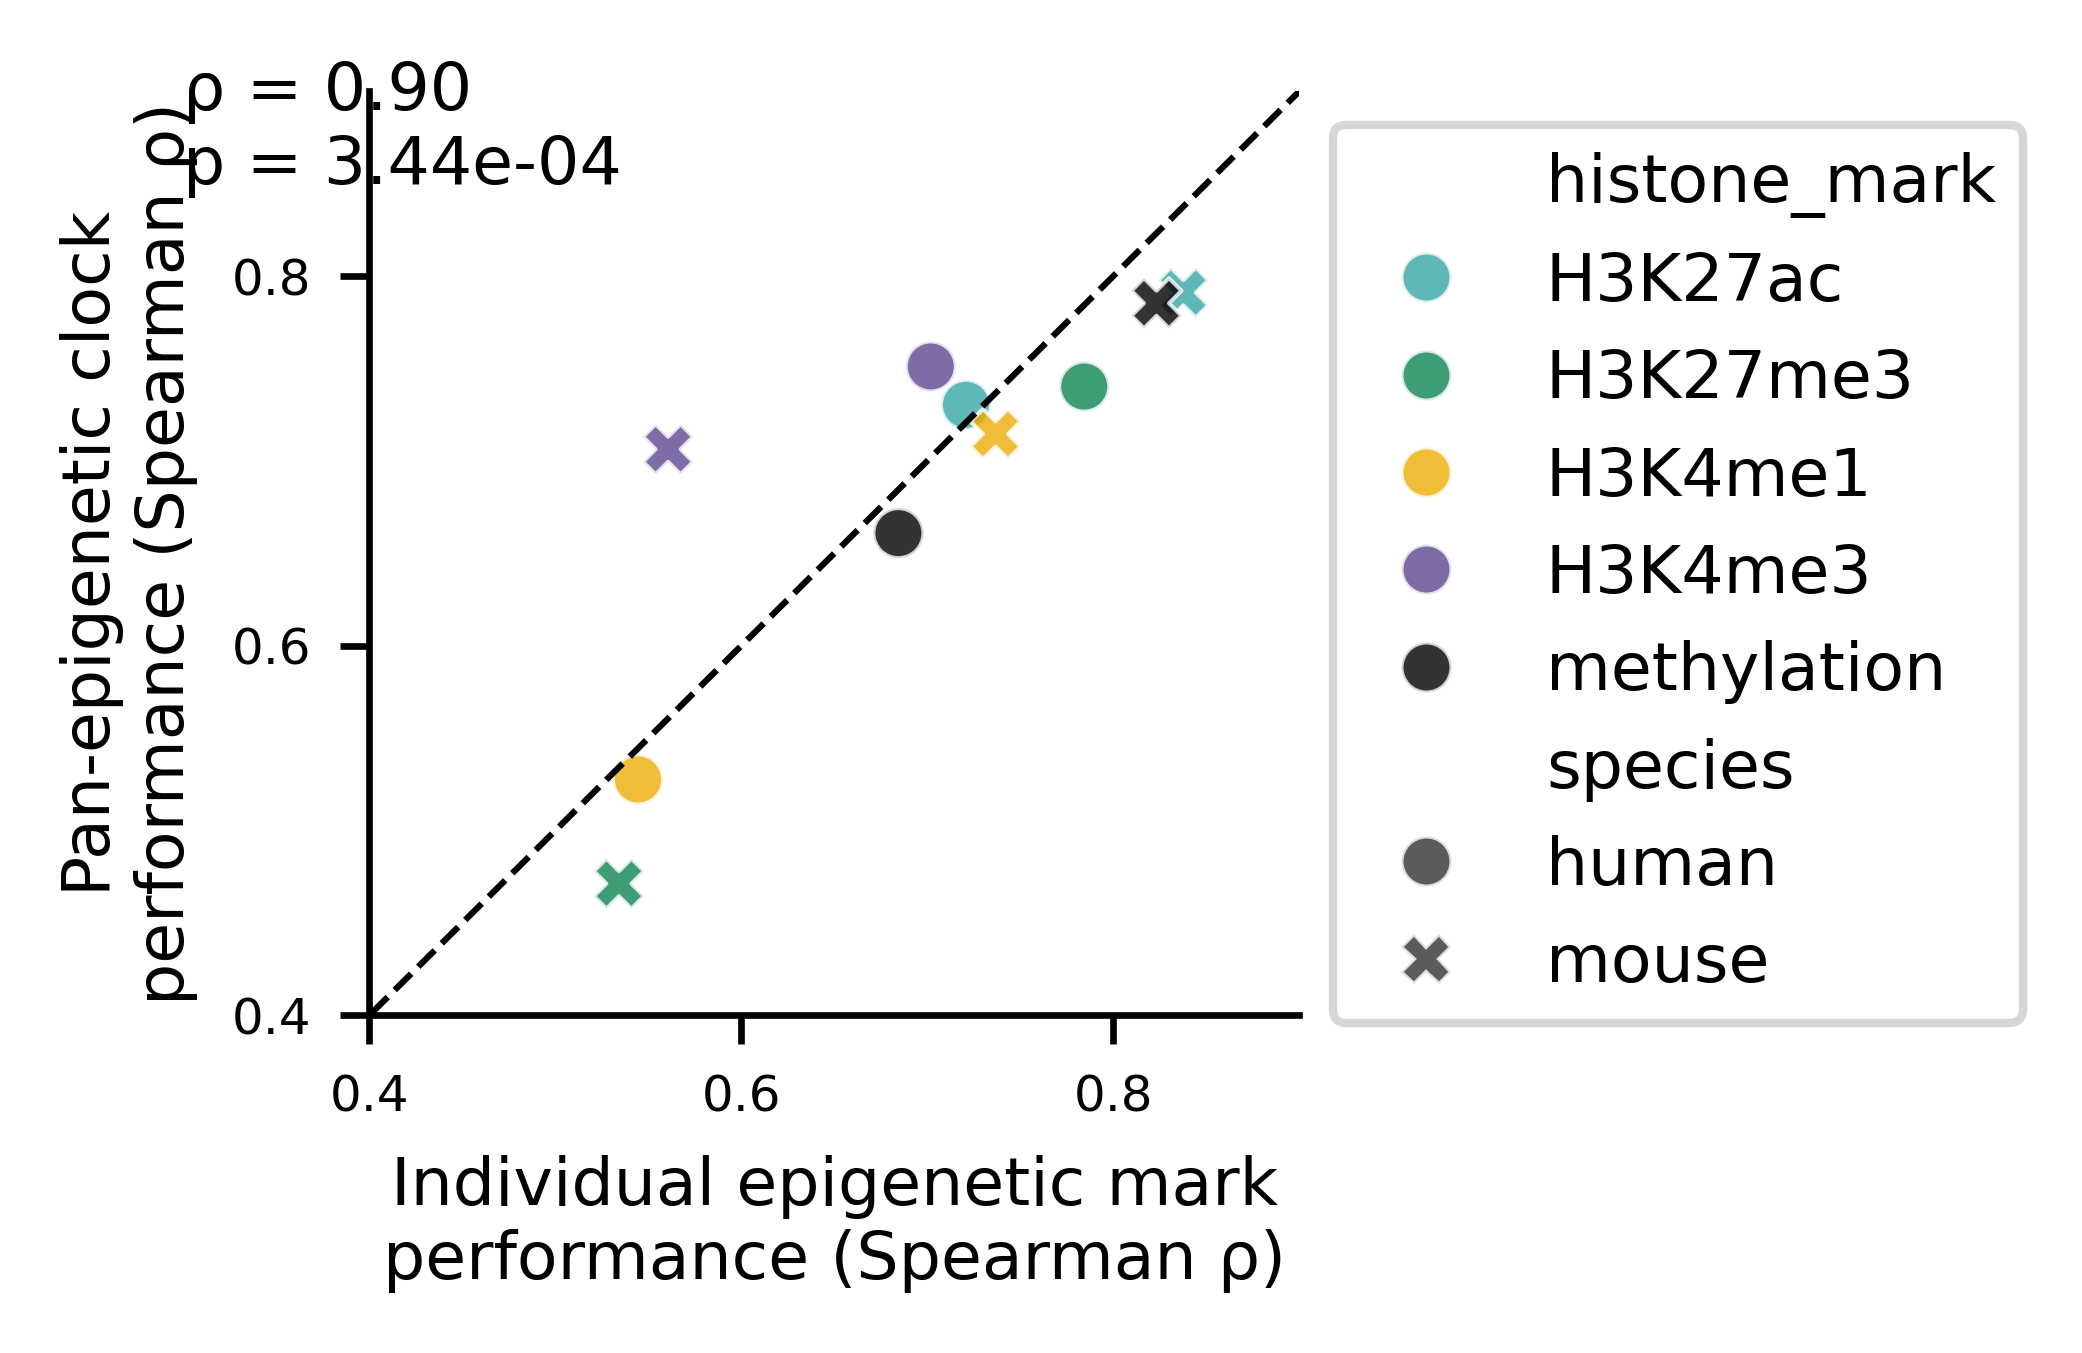

In [64]:
fig, ax = plt.subplots(figsize = (2, 2))

# compute the correlation between predicted and actual age for each mark and species
correlations_indiv_clocks = pan_epigenetic_indiv_clocks.combined_data_matrix.dropna(subset = ['pred_age', 'age_years']).groupby(['histone_mark', 'species'])[['pred_age', 'age_years']].apply(lambda x: spearmanr(x['pred_age'], x['age_years'])).reset_index()
# split 0 column into r and pvalue
correlations_indiv_clocks['r'] = correlations_indiv_clocks[0].apply(lambda x: x[0])
correlations_indiv_clocks['pvalue'] = correlations_indiv_clocks[0].apply(lambda x: x[1])
correlations_indiv_clocks.drop(columns = [0], inplace = True)

combined_corrs = correlations.merge(correlations_indiv_clocks, on = ['histone_mark', 'species'], suffixes = ('_all', '_indiv_clocks'))
sns.scatterplot(
    data = combined_corrs, 
    y = 'r_all', x = 'r_indiv_clocks', hue = 'histone_mark',  palette=hmark_colors,
    # set point shape based on species
    style = 'species', alpha = 0.8,
    ax = ax
    )
sns.lineplot(x = [0.3, 0.9], y = [0.3, .9], color = 'black', linestyle = '--', linewidth = 0.75)

# calculate correlation between x and y values
r, p = spearmanr(combined_corrs['r_all'], combined_corrs['r_indiv_clocks'])
# add text to plot showing correlation
ax.text(0.3, 0.85, f'ρ = {r:.2f}\np = {p:.2e}', fontsize=8)

# make axes tick labels spaced the same and match 
# Set same limits and ticks for both axes
ax.set_xlim(0.4, 0.9)
ax.set_ylim(0.4, 0.9)
ticks = np.arange(0.4, 1.0, 0.2)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# move legend to the right and put in box
ax.legend(loc = 'upper left', bbox_to_anchor = (1, 1), frameon = True)
# rename axes
ax.set_ylabel('Pan-epigenetic clock\nperformance (Spearman ρ)')
ax.set_xlabel('Individual epigenetic mark\nperformance (Spearman ρ)')
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/age_prediction/indiv_vs_pan_prediction_scatter.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

### Performance by tissue

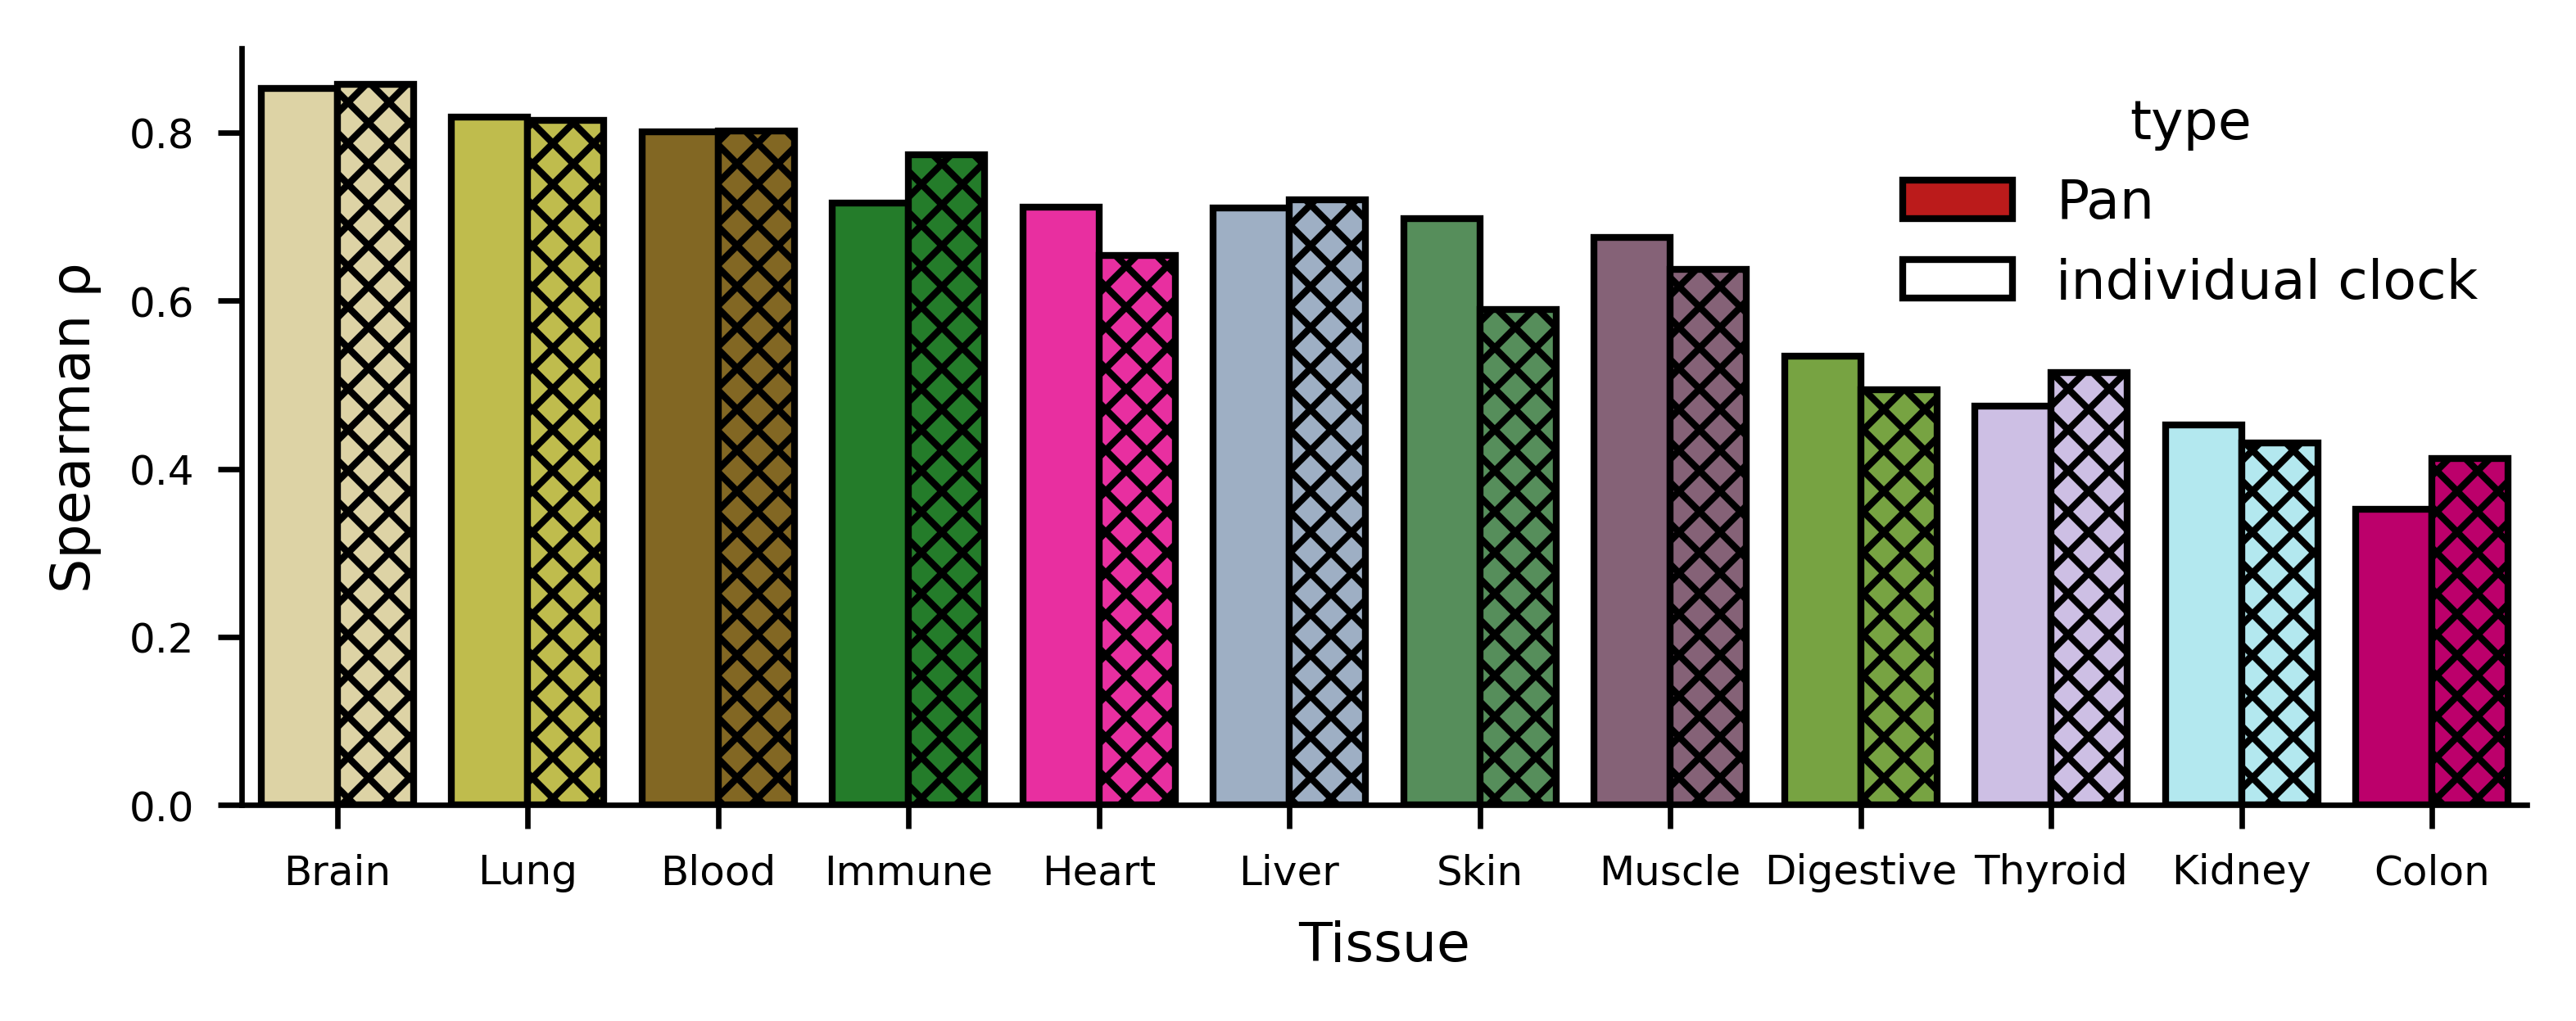

In [5]:
pan_epigenetic = pan_epigenetic_filled

# compute the correlation between predicted and actual age for each mark and species
correlations = pan_epigenetic.combined_data_matrix.dropna(subset = ['pred_age', 'age_years']).groupby(['general_tissue'])[['pred_age', 'age_years']].apply(lambda x: spearmanr(x['pred_age'], x['age_years'])).reset_index()
n_samples_per_tissue = pan_epigenetic.combined_data_matrix.groupby('general_tissue')['pred_age'].count().reset_index().rename(columns = {'pred_age': 'n_samples'})
# split 0 column into r and pvalue
correlations['r'] = correlations[0].apply(lambda x: x[0])
correlations['pvalue'] = correlations[0].apply(lambda x: x[1])
correlations['type'] = 'Pan'

correlations.drop(columns = [0], inplace = True)
# create dictionary of correlations for each mark
corrs = correlations.set_index('general_tissue')['r'].to_dict()

# calculate the correlations for the individual clocks also 
# calculate correlations for individual clocks
correlations_indiv = pan_epigenetic_indiv_clocks.combined_data_matrix.dropna(subset = ['pred_age', 'age_years']).groupby(['general_tissue'])[['pred_age', 'age_years']].apply(lambda x: spearmanr(x['pred_age'], x['age_years'])).reset_index()
# split 0 column into r and pvalue
correlations_indiv['r'] = correlations_indiv[0].apply(lambda x: x[0])
correlations_indiv['pvalue'] = correlations_indiv[0].apply(lambda x: x[1])
correlations_indiv.drop(columns = [0], inplace = True)
correlations_indiv['type'] = 'individual clock'
# capitalize the first letter of each tissue
correlations['general_tissue'] = correlations['general_tissue'].str.capitalize()
correlations_indiv['general_tissue'] = correlations_indiv['general_tissue'].str.capitalize()
# merge the correlations from both approaches
correlations_combined = pd.concat([correlations, correlations_indiv], axis=0).reset_index(drop=True)



# set order based on average correlation across species
order = correlations.sort_values(by = 'r', ascending = False)['general_tissue'].tolist()[:-1]

# bar plot of correlations
fig, ax = plt.subplots(figsize = (6, 2))
import colorcet as cc
tissue_colors = dict(zip(order, cc.glasbey_light[:len(order):-1]))

# create custom palette for each bar
bars_colors = []
for tissue in order:
    # For Pan type (filled)
    bars_colors.append(tissue_colors[tissue])
    # For individual clock type (edge only)


# create barplot
ax = sns.barplot(
    x='general_tissue', 
    y='r', 
    hue='type', 
    data=correlations_combined, 
    palette=['#d60000', '#FFFFFF'],  # use red for Pan, white for individual clock
    edgecolor='black',
    order=order,
    rasterized=True
)

# iterate through containers and set colors for each bar
for j, bar_set in enumerate(ax.containers):
    for i, bar in enumerate(bar_set):
        if j == 0:
            bar.set_facecolor(bars_colors[i])
            bar.set_edgecolor(bars_colors[i])
            bar.set_edgecolor('black')
        else:
            bar.set_facecolor(bars_colors[i])
            # add cross hatch pattern
            bar.set_hatch('xxxx')

ax.set_ylabel('Spearman ρ')
ax.set_xlabel('Tissue')
    
# save to supplementary
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/age_prediction/tissue_performance2.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

In [24]:
# pivot to have a column for each clock type
correlations_pivot = correlations_combined.pivot(index = 'general_tissue', columns = 'type', values = 'r')
spearmanr(correlations_pivot.dropna()['Pan'], correlations_pivot.dropna()['individual clock'])

SignificanceResult(statistic=0.9790209790209792, pvalue=3.0898013985487064e-08)

### Performance on special samples

p = 3.73e-03, median diff = -4.16 (months)
H3K4me1: p = 1.82e-02, median diff = -0.71 months
H3K27ac: p = 2.27e-01, median diff = -0.36 months
H3K4me3: p = 1.50e-01, median diff = -1.36 months
H3K27me3: p = 7.79e-01, median diff = 0.02 months


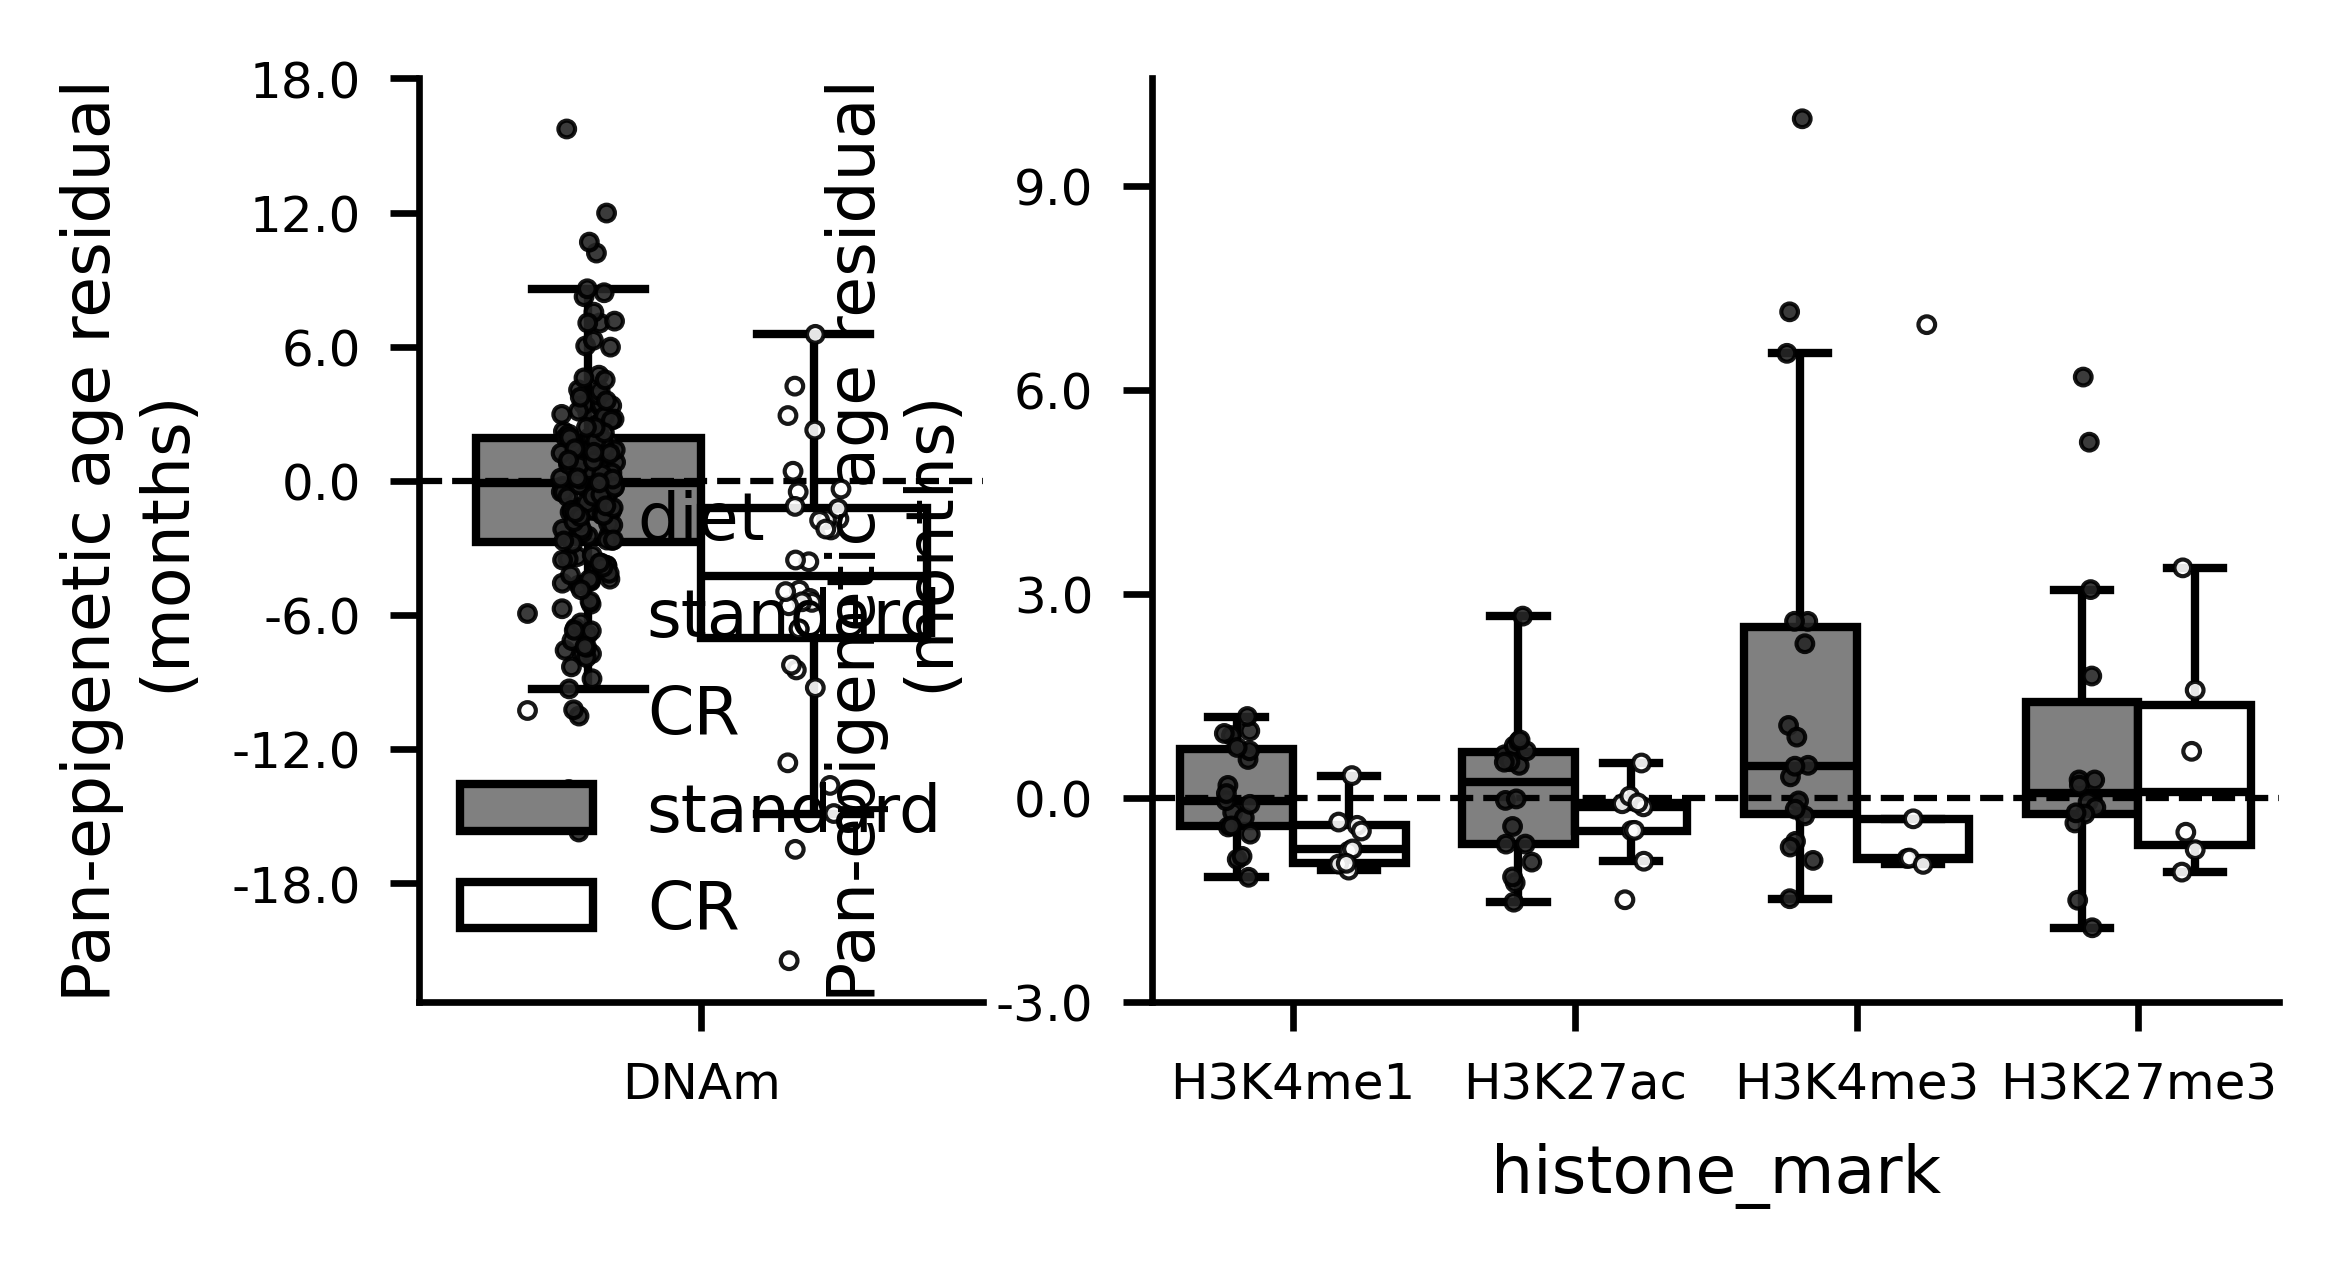

In [ ]:
# make middle plot twice as wide as the other two
fig, ax = plt.subplots(1, 2, figsize = (4, 2), sharey = False, width_ratios = [1, 2])

# first, petkovich diet samples
petkovich_pred_df = pan_epigenetic_filled.combined_data_matrix.loc[pan_epigenetic_filled.combined_data_matrix['dataset'] == 'petkovich'].copy(deep = True)
petkovich_pred_df['residual'] = petkovich_pred_df['pred_age'] - petkovich_pred_df['age_years']
petkovich_pred_df['residual_percentage'] = petkovich_pred_df['residual'] / petkovich_pred_df['age_years']

sns.stripplot(data = petkovich_pred_df.loc[petkovich_pred_df['strain'] == 'Wild Type'], hue = 'diet', y = 'residual', ax = ax[0], color = 'white', alpha = 0.9, s = 2,  edgecolor = 'black', linewidth = 0.5, dodge = True)
sns.boxplot(data = petkovich_pred_df.loc[petkovich_pred_df['strain'] == 'Wild Type'], hue = 'diet', y = 'residual', ax = ax[0], palette = ['grey', 'white'], linecolor='black', showfliers=False)
# add p value and effect size scaled to months
from scipy.stats import mannwhitneyu
_, p = mannwhitneyu(petkovich_pred_df.loc[(petkovich_pred_df['strain'] == 'Wild Type') & (petkovich_pred_df['diet'] == 'standard')]['residual'], petkovich_pred_df.loc[(petkovich_pred_df['strain'] == 'Wild Type') & (petkovich_pred_df['diet'] == 'CR')]['residual_percentage'])
median_diff = 12 * (petkovich_pred_df.loc[(petkovich_pred_df['strain'] == 'Wild Type') & (petkovich_pred_df['diet'] == 'CR')]['residual'].median() - petkovich_pred_df.loc[(petkovich_pred_df['strain'] == 'Wild Type') & (petkovich_pred_df['diet'] == 'standard')]['residual_percentage'].median())
print(f"p = {p:.2e}, median diff = {median_diff:.2f} (months)")
ax[0].axhline(y = 0, color = 'black', linestyle = '--', linewidth = 0.75)
# set x ticklabel to DNAm
ax[0].set_xticklabels(['DNAm'])
# convert y axis tick values from years to months, rounding to 1 decimal place
ax[0].set_yticks(np.arange(-1.5, 1.51, 0.5))
ax[0].set_yticklabels(np.round(ax[0].get_yticks() * 12, 1))
ax[0].set_ylabel('Pan-epigenetic age residual\n(months)')

# hillje diet samples,
hillje_pred_df = pan_epigenetic_filled.combined_data_matrix.loc[pan_epigenetic_filled.combined_data_matrix['dataset'] == 'hillje'].copy(deep = True)
hillje_pred_df['residual'] = hillje_pred_df['pred_age'] - hillje_pred_df['age_years']
hillje_pred_df['residual_percentage'] = hillje_pred_df['residual'] / hillje_pred_df['age_years']

sns.boxplot(data = hillje_pred_df, x = 'histone_mark', y = 'residual', hue = 'diet', ax = ax[1], linecolor='black', showfliers=False, palette = ['grey', 'white'])
sns.stripplot(data = hillje_pred_df, x = 'histone_mark', y = 'residual', hue = 'diet', ax = ax[1], color = 'white', alpha = 0.9, s = 2, edgecolor = 'black', linewidth = 0.5, dodge=True)
# add p value and effect size scaled to months for each histone mark
for mark in hillje_pred_df['histone_mark'].unique():
    mark_data = hillje_pred_df[hillje_pred_df['histone_mark'] == mark]
    _, p = mannwhitneyu(
        mark_data.loc[mark_data['diet'] == 'Standard diet']['residual'],
        mark_data.loc[mark_data['diet'] == 'Caloric restriction']['residual']
    )
    median_diff = 12 * (
        mark_data.loc[mark_data['diet'] == 'Caloric restriction']['residual'].median() - 
        mark_data.loc[mark_data['diet'] == 'Standard diet']['residual'].median()
    )
    print(f"{mark}: p = {p:.2e}, median diff = {median_diff:.2f} months")


ax[1].axhline(y = 0, color = 'black', linestyle = '--', linewidth = 0.75)

# remove legend
ax[1].legend_.remove()
# convert y axis tick values from years to months, rounding to 1 decimal place
# make y axis ticks go from -0.25 to 0.75 by 0.25
ax[1].set_yticks(np.arange(-0.25, 0.76, 0.25))
ax[1].set_yticklabels(np.round(ax[1].get_yticks() * 12, 1))

ax[1].set_ylabel('Pan-epigenetic age residual\n(months)')
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/age_prediction/petkovich_hillje_diet_residuals.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

### Scaling of performance

In [4]:
hmarks_to_use = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1']
# hmark
scaling_hmark = MultiDataset(
        datasets = [hmark_human_blueprint, hmark_human_encode, hmark_ceehrc],
        nan_policy = 'fill'
        )
scaling_hmark.combined_data_matrix = scaling_hmark.combined_data_matrix[
        scaling_hmark.combined_data_matrix['histone_mark'].isin(hmarks_to_use)
        ]
# methyl
scaling_methyl = MultiDataset(
        datasets = [human_blueprint_methyl ,methyl_human_encode,  methyl_ceehrc],
        nan_policy = 'fill'
        )

#  exclude sex specific tissues and cell lines
tissues_to_drop =  ['prostate', 'breast', 'reproductive', 'placenta', 'cell_line']
scaling_hmark.combined_data_matrix = scaling_hmark.combined_data_matrix[
    ~scaling_hmark.combined_data_matrix['general_tissue'].isin(tissues_to_drop)
    ]
# for methylation too
scaling_methyl.combined_data_matrix = scaling_methyl.combined_data_matrix[
    ~scaling_methyl.combined_data_matrix['general_tissue'].isin(tissues_to_drop)
    ]

hmark_combined_data_matrix = scaling_hmark.combined_data_matrix.copy(deep = True)
methyl_combined_data_matrix = scaling_methyl.combined_data_matrix.copy(deep = True)

In [5]:
scaling_hmark.combined_data_matrix = hmark_combined_data_matrix.copy(deep = True)
scaling_methyl.combined_data_matrix = methyl_combined_data_matrix.copy(deep = True)

##### Run scaling experiments

In [ ]:
import time
for n_donors in [20, 40, 60, 80, 100, 120, 140,160, 180, 200]:
    for random_iter in range(10):
        methyl_chosen_donors = pd.Series(methyl_combined_data_matrix['donor'].unique()).sample(n = n_donors, random_state = random_iter, replace = False)
        scaling_methyl.combined_data_matrix = methyl_combined_data_matrix.loc[methyl_combined_data_matrix['donor'].isin(methyl_chosen_donors)]
        scaling_methyl.predict_on_cluster(
                output_dir = f"/cellar/users/zkoch/histone_mark_proj/model_results/scaling_with_ceehrc/methyl_bp_enc_{n_donors}donors_{random_iter}iter",
                result_column = f'pred_age_{n_donors}donors_{random_iter}iter',
                target_column = 'age_scaled_loglog',
                n_folds = 5,
                seperate_by_hmark = False,
                jobname = f"methyl_bp_enc_{n_donors}donors_{random_iter}iter",
                mem_gb = 100,
                cpus = 4,
                time = '01:00:00',
                model_type = "XGBRegressor"
                )
        for hmark in hmarks_to_use:
            # randomly sample n_donors from the combined data matrix
            hmark_chosen_donors = pd.Series(
                hmark_combined_data_matrix.loc[hmark_combined_data_matrix['histone_mark'] == hmark]['donor'].unique()
                ).sample(n = n_donors, random_state = random_iter, replace = False)
            scaling_hmark.combined_data_matrix = hmark_combined_data_matrix.loc[hmark_combined_data_matrix['donor'].isin(hmark_chosen_donors)]
            scaling_hmark.predict_on_cluster(
                output_dir = f"/cellar/users/zkoch/histone_mark_proj/model_results/scaling_with_ceehrc/hmark_bp_enc_{n_donors}donors_{random_iter}iter_{hmark}",
                result_column = f'pred_age_{n_donors}donors_{random_iter}iter_{hmark}',
                target_column = 'age_scaled_loglog',
                n_folds = 5,
                seperate_by_hmark = True, 
                jobname = f"hmark_bp_enc_{n_donors}donors_{random_iter}iter_{hmark}",
                mem_gb = 100,
                cpus = 4,
                time = '01:00:00',
                model_type = "XGBRegressor"
                )
        time.sleep(100)
    time.sleep(100)
            

##### Read in results

In [6]:
predictions_methyl_dfs = []
methyl_pred_cols = []
predictions_hmark_dfs = []
hmark_pred_cols = []
for n_donors in [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]:
    for random_iter in range(10): # 0, 1
        try:
            df = pd.read_csv(f"/cellar/users/zkoch/histone_mark_proj/model_results/scaling_with_ceehrc/methyl_bp_enc_{n_donors}donors_{random_iter}iter/predictions.csv", index_col = 0)
            # Apply log-log age transform and multiply by 120 because all human
            df = np.exp(-np.exp(-df)) *120 
            predictions_methyl_dfs.append(df)
            methyl_pred_cols.append(df.columns.values[0])
        except Exception as e:
            print(f"No predictions found for methyl {n_donors} donors {random_iter}iter", flush = True)
        
        for hmark in hmarks_to_use:
            try:
                df = pd.read_csv(f"/cellar/users/zkoch/histone_mark_proj/model_results/scaling_with_ceehrc/hmark_bp_enc_{n_donors}donors_{random_iter}iter_{hmark}/predictions.csv", index_col = 0)
                # Apply log-log age transform and multiply by 120 because all human
                df = np.exp(-np.exp(-df)) * 120
                predictions_hmark_dfs.append(df)
                hmark_pred_cols.append(df.columns.values[0])
            except Exception as e:
                print(e)
                print(f"No predictions found for hmark {n_donors} donors {random_iter}iter {hmark}", flush = True)
                break
predictions_methyl_df = pd.concat(predictions_methyl_dfs, axis = 1)
predictions_hmark_df = pd.concat(predictions_hmark_dfs, axis = 1)

# concatenate t combined data matrices
scaling_methyl.combined_data_matrix = pd.concat([scaling_methyl.combined_data_matrix, predictions_methyl_df], axis = 1)
scaling_hmark.combined_data_matrix = pd.concat([scaling_hmark.combined_data_matrix, predictions_hmark_df], axis = 1)

In [7]:
hmark_predictions_cols = [col for col in scaling_hmark.combined_data_matrix.columns if col.startswith('pred_age_')]
methyl_predictions_cols = [col for col in scaling_methyl.combined_data_matrix.columns if col.startswith('pred_age_')]

# hmark
hmark_performance = scaling_hmark.combined_data_matrix.groupby('histone_mark')[hmark_predictions_cols].corrwith(scaling_hmark.combined_data_matrix['age_years'], method = 'spearman')
# pivot to long
hmark_performance_long = hmark_performance.reset_index().melt(id_vars = 'histone_mark', value_vars = hmark_predictions_cols, var_name = 'run_name', value_name = 'r')
hmark_performance_long['n_donors'] = hmark_performance_long['run_name'].str.split('_').str[2].str.split('donors').str[0]
hmark_performance_long['n_donors'] = hmark_performance_long['n_donors'].astype(int)
hmark_performance_long['mark_this_run'] = hmark_performance_long['run_name'].str.split('_').str[-1]
# keep only rows where histone_mark == mark_this_run
hmark_performance_long.query("histone_mark == mark_this_run", inplace=True)

# methylation
methyl_performance = scaling_methyl.combined_data_matrix[methyl_predictions_cols].corrwith(scaling_methyl.combined_data_matrix['age_years'], method = 'spearman').reset_index()
methyl_performance.columns = ['run_name', 'r']
methyl_performance['n_donors'] = methyl_performance['run_name'].str.split('_').str[2].str.split('donors').str[0]
methyl_performance['n_donors'] = methyl_performance['n_donors'].astype(int)
methyl_performance['histone_mark'] = 'DNAm'
methyl_performance['mark_this_run'] = 'DNAm'


# combine
performance = pd.concat([hmark_performance_long, methyl_performance])
performance.reset_index(drop = True, inplace = True)

Kruskal-Wallis test results:
H-statistic: 122.156
p-value: 1.850e-25

Post-hoc pairwise Mann-Whitney U tests:
H3K4me3 vs H3K27ac: p = 9.018e+00
H3K4me3 vs H3K27me3: p = 3.119e-03 (significant)
H3K4me3 vs H3K4me1: p = 6.663e-11 (significant)
H3K4me3 vs DNAm: p = 3.426e-03 (significant)
H3K27ac vs H3K27me3: p = 2.811e-03 (significant)
H3K27ac vs H3K4me1: p = 5.383e-14 (significant)
H3K27ac vs DNAm: p = 3.300e-03 (significant)
H3K27me3 vs H3K4me1: p = 8.354e-17 (significant)
H3K27me3 vs DNAm: p = 7.058e+00
H3K4me1 vs DNAm: p = 4.899e-17 (significant)


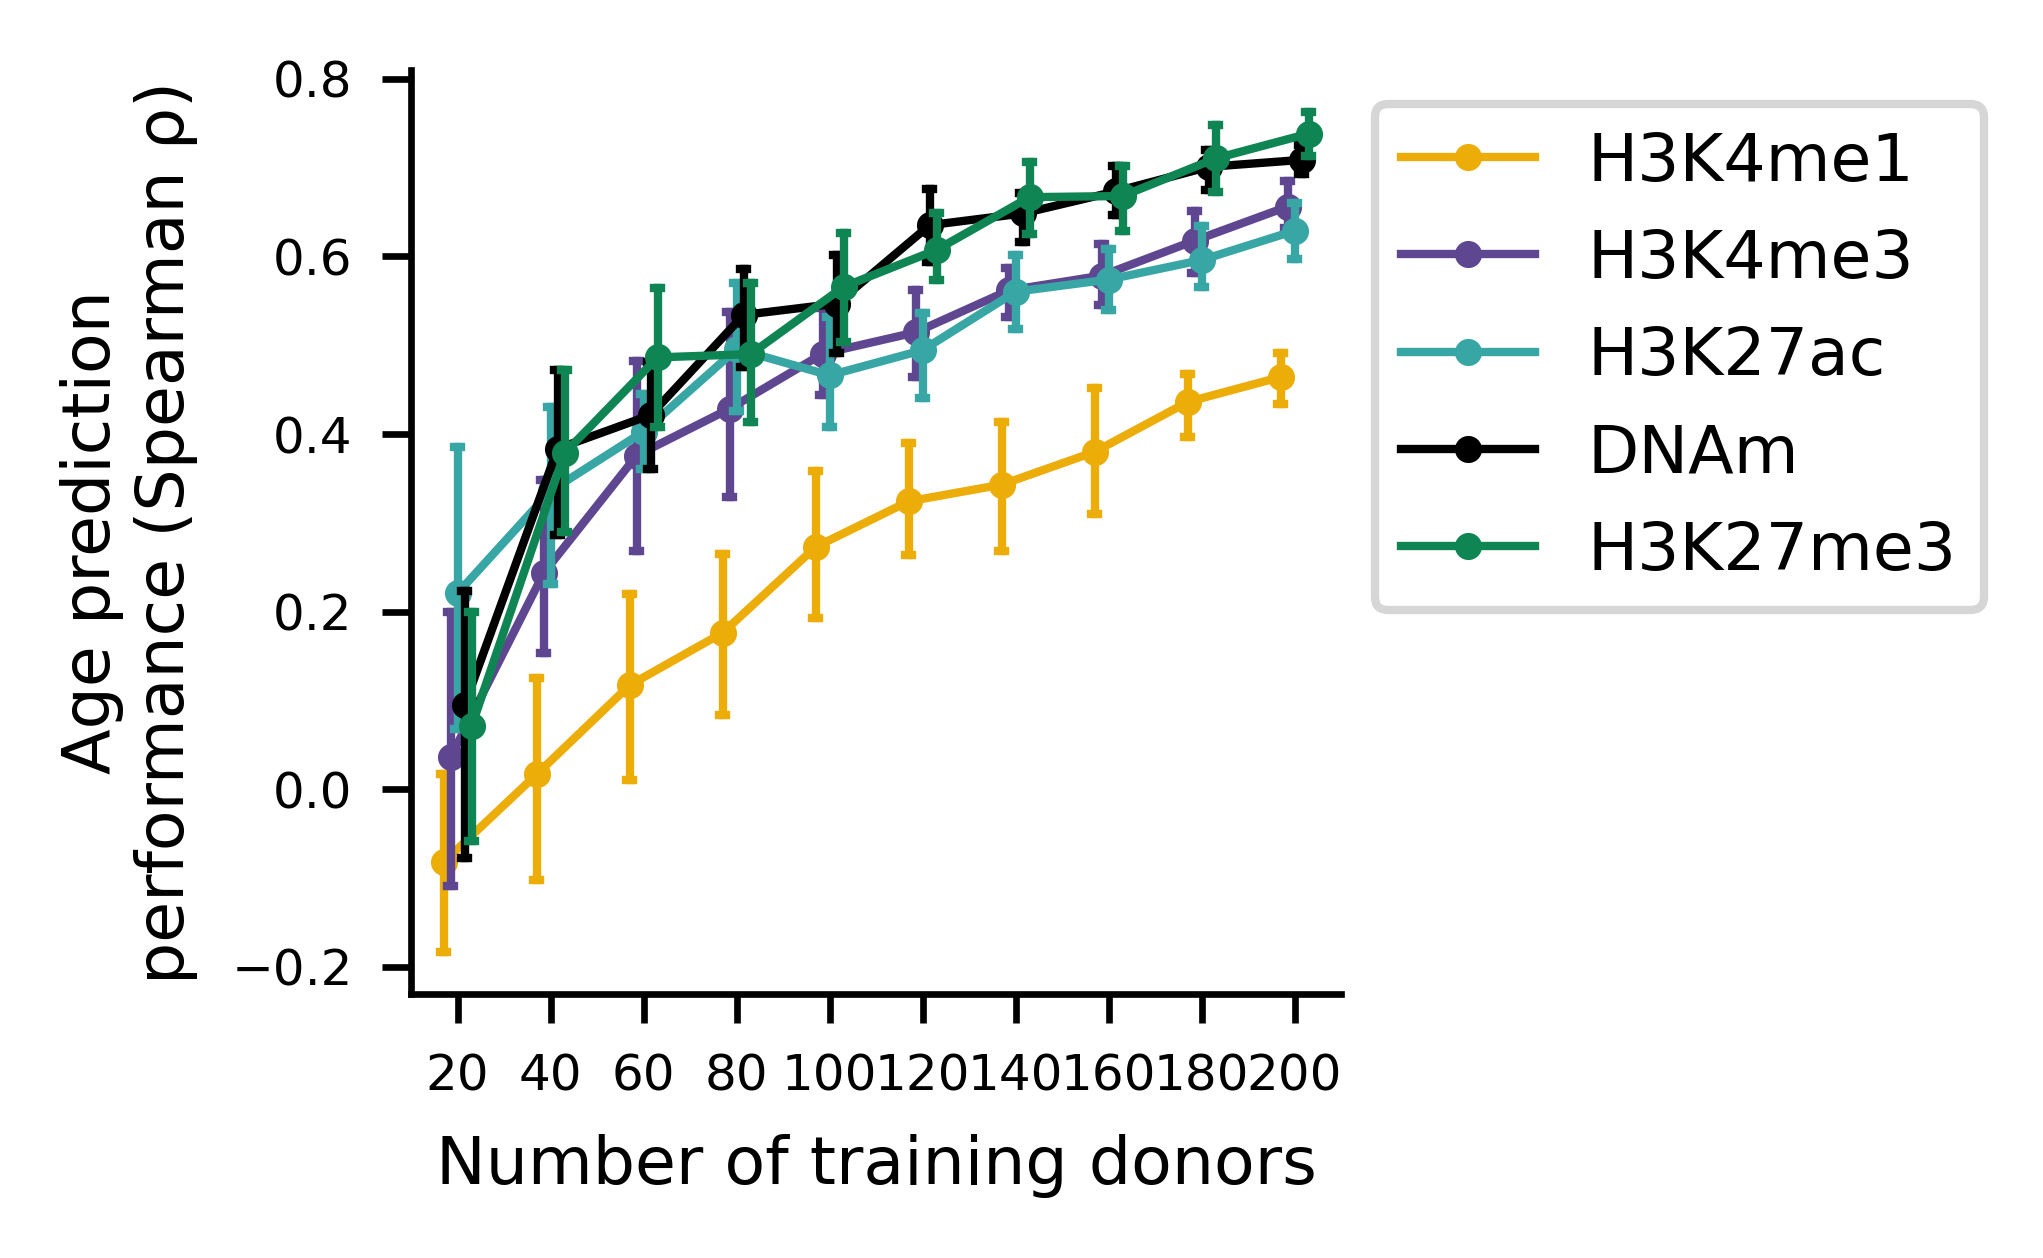

histone_mark
DNAm        0.933630
H3K27ac     0.937759
H3K27me3    0.929194
H3K4me1     0.666550
H3K4me3     0.884526
dtype: float64
  Epigenetic mark  Scaling rate
2        H3K27me3      0.122879
0            DNAm      0.121885
1         H3K27ac      0.107480
4         H3K4me3      0.103612
3         H3K4me1      0.058796


In [ ]:
fig, ax = plt.subplots(1,1,figsize = (2, 2))
# donors

sns.pointplot(
    data = performance, x = 'n_donors', y = 'r', hue = 'histone_mark',
    ax = ax, palette = hmark_colors, markersize = 2.5, alpha = 1, linewidth = 1, capsize = 0.075,
    dodge=0.3, hue_order = ['H3K4me1', 'H3K4me3',  'H3K27ac', 'DNAm', 'H3K27me3']
    )

# test for a statistical difference between the distribution of r values for each histone mark across all n_donor groups
# use a test that compares multiple sub-groups within a larger group
# Perform Kruskal-Wallis H-test to compare r values across histone marks
from scipy import stats

# Run Kruskal-Wallis test
h_stat, p_val = stats.kruskal(*[group['r'].values for name, group in performance.groupby('histone_mark')])

# Print results
print(f"Kruskal-Wallis test results:")
print(f"H-statistic: {h_stat:.3f}")
print(f"p-value: {p_val:.3e}")

# If significant, perform post-hoc pairwise Mann-Whitney U tests with Bonferroni correction
if p_val < 0.05:
    print("\nPost-hoc pairwise Mann-Whitney U tests:")
    marks = performance['histone_mark'].unique()
    n_comparisons = len(marks) * (len(marks)-1) / 2  # Number of pairwise comparisons
    
    for i in range(len(marks)):
        for j in range(i+1, len(marks)):
            mark1_data = performance[performance['histone_mark'] == marks[i]]['r']
            mark2_data = performance[performance['histone_mark'] == marks[j]]['r']
            stat, p = stats.mannwhitneyu(mark1_data, mark2_data, alternative='two-sided')
            # Apply Bonferroni correction
            if p * n_comparisons < 0.05:
                print(f"{marks[i]} vs {marks[j]}: p = {p*n_comparisons:.3e} (significant)")
            else:
                print(f"{marks[i]} vs {marks[j]}: p = {p*n_comparisons:.3e}")




# move legend to the right and put in box
ax.legend(loc = 'upper left', bbox_to_anchor = (1, 1), frameon = True)
ax.set_xlabel('Number of training donors')
ax.set_ylabel('Age prediction\nperformance (Spearman ρ)')
plt.show()
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/age_prediction/scaling_rate_lines.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

# instead fit a logarithmic model
model_fit = performance.groupby('histone_mark').apply(lambda x: smf.ols('r ~ np.log(n_donors) + 0', data = x).fit().rsquared)
print(model_fit)
scaling_rate = performance.groupby('histone_mark').apply(lambda x: smf.ols('r ~ np.log(n_donors) + 0', data = x).fit().params['np.log(n_donors)'])
scaling_rate = scaling_rate.to_frame().reset_index().rename(columns = {0: 'Scaling rate','histone_mark': 'Epigenetic mark'})
# plot the scaling rate as barplot, ordered by the scaling rate
print(scaling_rate.sort_values(by = 'Scaling rate', ascending = False))

In [28]:
full_model.summary()

# Get interaction terms
interaction_terms = [term for term in full_model.params.index if 'np.log(n_donors):' in term]

# Perform Wald test
from scipy import stats
test = full_model.f_test([f'0 = {term}' for term in interaction_terms])
print(f'F-statistic: {test.fvalue}')
print(f'p-value: {test.pvalue}')

F-statistic: 4.787842239870152
p-value: 0.0008507558512157032


In [30]:
# Get the coefficients and standard errors for the interaction terms
interaction_terms = [term for term in full_model.params.index if 'np.log(n_donors):' in term] + ['np.log(n_donors)']
coefficients = full_model.params[interaction_terms]
std_errors = full_model.bse[interaction_terms]

# Perform pairwise t-tests
from itertools import combinations
import numpy as np
from scipy.stats import t
from statsmodels.stats.multitest import multipletests

# Store results
results = []
for term1, term2 in combinations(interaction_terms, 2):
    # Calculate t-statistic
    diff = full_model.params[term1] - full_model.params[term2]
    se_diff = np.sqrt(full_model.bse[term1]**2 + full_model.bse[term2]**2)
    t_stat = diff / se_diff
    
    # Calculate p-value
    p_val = 2 * (1 - t.cdf(abs(t_stat), df=full_model.df_resid))
    
    # Extract mark names from interaction terms
    try:
        mark1 = term1.split(':')[1].replace('histone_mark[T.', '').replace(']', '')
    except:
        mark1 = 'DNAm'
    try:
        mark2 = term2.split(':')[1].replace('histone_mark[T.', '').replace(']', '')
    except:
        mark2 = 'DNAm'
    
    results.append({
        'mark1': mark1,
        'mark2': mark2,
        'diff': diff,
        'p_value': p_val
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Benjamini-Hochberg correction for multiple testing
results_df['p_value_adjusted'] = multipletests(results_df['p_value'], method='fdr_bh')[1]

# Sort by adjusted p-value
results_df = results_df.sort_values('p_value_adjusted')

print("Pairwise comparisons of scaling rates (after FDR correction):")
print(results_df)

Pairwise comparisons of scaling rates (after FDR correction):
      mark1     mark2      diff       p_value  p_value_adjusted
3   H3K27ac      DNAm -0.343444  0.000000e+00      0.000000e+00
8   H3K4me1      DNAm -0.268323  0.000000e+00      0.000000e+00
9   H3K4me3      DNAm -0.256218  1.554312e-15      5.181041e-15
6  H3K27me3      DNAm -0.247311  1.199041e-14      2.997602e-14
0   H3K27ac  H3K27me3 -0.096133  7.610735e-03      1.522147e-02
2   H3K27ac   H3K4me3 -0.087226  1.538753e-02      2.564588e-02
1   H3K27ac   H3K4me1 -0.075121  3.675569e-02      5.250813e-02
4  H3K27me3   H3K4me1  0.021012  5.582958e-01      6.978697e-01
5  H3K27me3   H3K4me3  0.008907  8.039903e-01      8.039903e-01
7   H3K4me1   H3K4me3 -0.012105  7.359183e-01      8.039903e-01


### Cross-mark learning

In [34]:
def create_pan_epigenetic_model(hmarks_to_use, datasets, name, model_name, features, target_column, n_pcs, nan_policy, n_folds):
    pan_epigenetic = MultiDataset(
        datasets = datasets,
        nan_policy = nan_policy
        )

    # subset to hmarks_to_use
    pan_epigenetic.combined_data_matrix = pan_epigenetic.combined_data_matrix[
        pan_epigenetic.combined_data_matrix['histone_mark'].isin(hmarks_to_use)
        ]

    # subset to tissues with at least 50 samples and exclude sex specific tissues adn cell lines
    n_samples_per_tissue = pan_epigenetic.combined_data_matrix['general_tissue'].value_counts()
    tissues_to_drop = n_samples_per_tissue[n_samples_per_tissue < 50].index.tolist()
    tissues_to_drop = tissues_to_drop + ['prostate', 'breast', 'reproductive', 'placenta', 'cell_line']
    tissues_to_drop = [tissue for tissue in tissues_to_drop if tissue != 'special']
    tissues_to_drop = list(set(tissues_to_drop))
    pan_epigenetic.combined_data_matrix = pan_epigenetic.combined_data_matrix[
        ~pan_epigenetic.combined_data_matrix['general_tissue'].isin(tissues_to_drop)
        ]

    # exlucde CR, GHRKO, and fibroblast/iPSC samples from training 
    special_diet_samples = pan_epigenetic.combined_data_matrix[
        pan_epigenetic.combined_data_matrix['diet'].isin(['Caloric restriction', 'CR'])
    ].index.tolist()
    special_genetic_background_samples = pan_epigenetic.combined_data_matrix[
        pan_epigenetic.combined_data_matrix['strain'].isin(['GHRKO', 'Snell Dwarf'])
    ].index.tolist()
    special_fibroblast_samples = pan_epigenetic.combined_data_matrix[
        pan_epigenetic.combined_data_matrix['tissue'].isin(['Lung fibroblasts', 'iPSCs from kidney fibroblasts', 'Kidney fibroblasts', 'iPSCs from lung fibroblasts'])
    ].index.tolist()
    special_samples = list(set(special_diet_samples + special_genetic_background_samples + special_fibroblast_samples))
    pan_epigenetic.exclude_samples = special_samples

    # do combat normalization
    pan_epigenetic.combat_normalize(batch_col = 'dataset')
    return pan_epigenetic

def train_pan_epigenetic_model(pan_epigenetic, name, model_name, features, target_column, n_pcs, nan_policy, n_folds, use_scrambled_for_training, which_mark_scrambled):
    # set time based on n_folds
    if n_folds == 1:
        time = '48:00:00'
    else:
        time = '120:00:00'
    # train model    
    pan_epigenetic.predict_on_cluster(
        output_dir = f"/cellar/users/zkoch/histone_mark_proj/model_results/{model_name}_{features}_{n_folds}folds_{target_column}_{n_pcs}pcs_{nan_policy}nanPolicy_{which_mark_scrambled}scrambled_pan_epigenetic",
        result_column = 'predicted_age',
        target_column = target_column,
        n_folds = n_folds,
        seperate_by_hmark = False,
        jobname = f"{which_mark_scrambled}scrambled",
        mem_gb = 200,
        cpus = 32,
        time = time,
        model_type = model_name,
        n_pcs = n_pcs,
        use_scrambled_for_training = use_scrambled_for_training
    )
    


##### Train scrambled models

In [ ]:
hmarks_to_use = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1',  'methylation'] #'H3K36me3', 'H3K9me3',
datasets = histone_datasets + methyl_datasets
name = '.'.join([dataset.name for dataset in datasets])
model_name = 'XGBRegressor'
features = 'all'
target_column = 'age_scaled_loglog'
n_pcs = -1
nan_policy = 'fill'
n_folds = 5
use_scrambled_for_training = True

to_scramble_pan_epigenetic = create_pan_epigenetic_model(
    hmarks_to_use, datasets, name, model_name, features,
    target_column, n_pcs, nan_policy, n_folds
    )

for scrambled_hmark in hmarks_to_use:
    print(scrambled_hmark)
    # create scrambled dataset
    to_scramble_pan_epigenetic.scramble_histone_mark(scrambled_hmark)
    # train model on scrambled data 
    train_pan_epigenetic_model(
        to_scramble_pan_epigenetic, name, model_name, features, target_column, n_pcs, nan_policy, n_folds, use_scrambled_for_training, scrambled_hmark
        )

H3K4me3
Scrambled feature values for 509 samples of H3K4me3
Submitted batch job 2114938
Job submitted. Results will be saved to /cellar/users/zkoch/histone_mark_proj/model_results/XGBRegressor_all_5folds_age_scaled_loglog_-1pcs_fillnanPolicy_H3K4me3scrambled_pan_epigenetic
H3K27ac
Scrambled feature values for 503 samples of H3K27ac
Submitted batch job 2114940
Job submitted. Results will be saved to /cellar/users/zkoch/histone_mark_proj/model_results/XGBRegressor_all_5folds_age_scaled_loglog_-1pcs_fillnanPolicy_H3K27acscrambled_pan_epigenetic
H3K27me3
Scrambled feature values for 505 samples of H3K27me3
Submitted batch job 2114941
Job submitted. Results will be saved to /cellar/users/zkoch/histone_mark_proj/model_results/XGBRegressor_all_5folds_age_scaled_loglog_-1pcs_fillnanPolicy_H3K27me3scrambled_pan_epigenetic
H3K4me1
Scrambled feature values for 435 samples of H3K4me1
Submitted batch job 2114942
Job submitted. Results will be saved to /cellar/users/zkoch/histone_mark_proj/model_res

##### Read in predictions for each scrambled dataset

In [50]:
hmarks_to_use = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1',  'methylation'] #'H3K36me3', 'H3K9me3',
datasets = histone_datasets + methyl_datasets
name = '.'.join([dataset.name for dataset in datasets])
model_name = 'XGBRegressor'
features = 'all'
target_column = 'age_scaled_loglog'
n_pcs = -1
nan_policy = 'fill'
n_folds = 5
use_scrambled_for_training = True


to_scramble_pan_epigenetic = create_pan_epigenetic_model(
    hmarks_to_use, datasets, name, model_name, features,
    target_column, n_pcs, nan_policy, n_folds
    )

# read in predictions for each scrambled dataset
scrambled_predictions = {}
for scrambled_hmark in  ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1',  'methylation']:
    # load the model results
    model_dir = f"/cellar/users/zkoch/histone_mark_proj/model_results/XGBRegressor_all_5folds_age_scaled_loglog_-1pcs_fillnanPolicy_{scrambled_hmark}scrambled_pan_epigenetic"
    # load the combined data matrix
    scrambled_predictions[scrambled_hmark] = pd.read_csv(model_dir + "/predictions.csv", index_col = 0)
# concat all predictions into one df
scrambled_predictions_df = pd.concat(scrambled_predictions.values(), axis = 1)
scrambled_predictions_df.columns = scrambled_predictions.keys()
# add scrambled predictions
to_scramble_pan_epigenetic.combined_data_matrix = to_scramble_pan_epigenetic.combined_data_matrix.merge(scrambled_predictions_df, left_index = True, right_index = True)
# add no scrambled predictions
to_scramble_pan_epigenetic.combined_data_matrix = to_scramble_pan_epigenetic.combined_data_matrix.merge(pan_epigenetic_filled.combined_data_matrix[ 'pred_age'], left_index = True, right_index = True)

Performing ComBat normalization using dataset as batch...
ComBat normalization complete


In [52]:
performance_df = to_scramble_pan_epigenetic.combined_data_matrix.groupby('histone_mark')[['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'methylation', 'pred_age']].corrwith(to_scramble_pan_epigenetic.combined_data_matrix['age_years'], method = 'spearman')
# re-order columsn and rows to be the same order
performance_df = performance_df.reindex(performance_df.columns)
# subtract pred_age column from all other columns and then drop pred_age column
pred_age = performance_df['pred_age']
performance_df_scaled = performance_df[['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'methylation']].sub(pred_age, axis = 0)
# divide by pred_age column
performance_df_scaled = performance_df_scaled.div(pred_age, axis = 0)
performance_df_scaled = performance_df_scaled.drop(index = ['pred_age'])

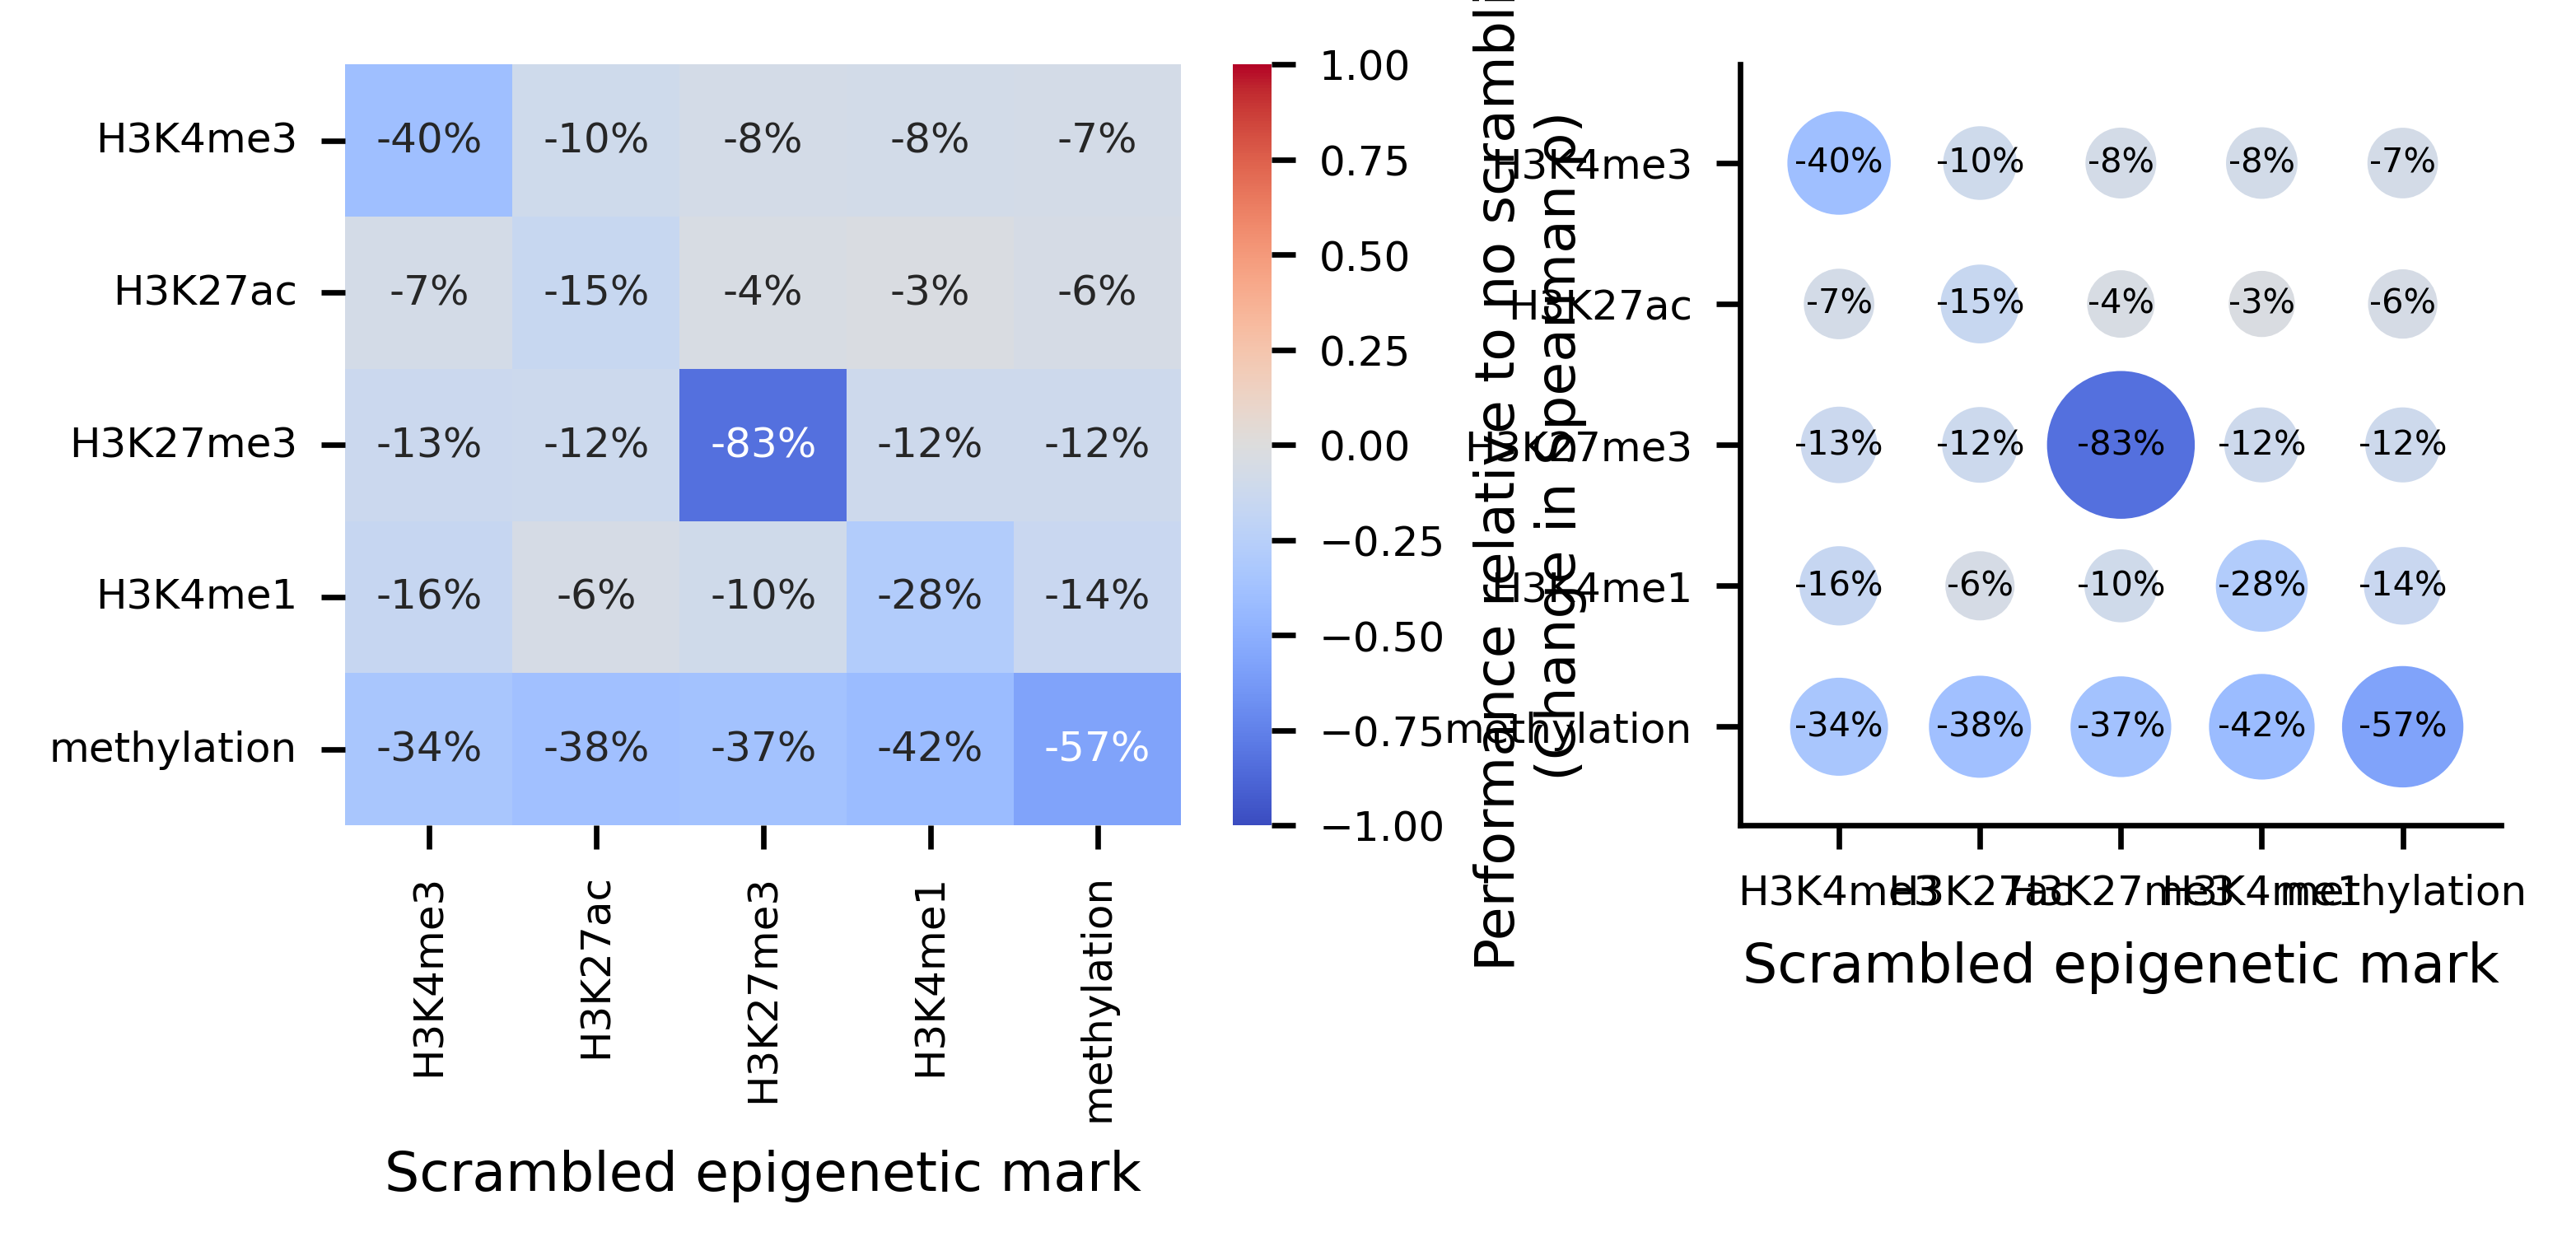

In [57]:
fig, ax = plt.subplots(1,2,figsize = (6,2))
from palettable.cartocolors.diverging import Temps_3, Fall_3, TealRose_3
sns.heatmap(performance_df_scaled, cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0, ax = ax[0], annot = True, 
            # format as a percentage
            fmt = '.0%', annot_kws = {'size': 6})
ax[0].set_xlabel('Scrambled epigenetic mark')
ax[0].set_ylabel('')
# label color bar
cbar = ax[0].collections[0].colorbar
cbar.set_label('Performance relative to no scrambling\n(Change in Spearman ρ)')

from palettable.cartocolors.diverging import Temps_3, Fall_3, TealRose_3

# Create circle markers instead of squares
data = performance_df_scaled.iloc[::-1, :].values # Reverse both dimensions
x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
r = np.abs(data)
colors = plt.cm.coolwarm((data - (-1)) / (1 - (-1)))

# Scale circle sizes based on absolute value, with minimum size of 0.1 and max of 0.4
max_radius = 0.5
min_radius = 0.2
abs_data = np.abs(data)
scaled_sizes = min_radius + (max_radius - min_radius) * (abs_data / abs_data.max())

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        circle = plt.Circle((j + 0.5, i + 0.5), scaled_sizes[i,j],
                          color=colors[i,j])
        ax[1].add_patch(circle)
        # Add text annotation
        ax[1].text(j + 0.5, i + 0.5, f'{data[i,j]:.0%}', 
                ha='center', va='center', color='black',
                fontsize=5
                )

ax[1].set_xlim(-0.2, data.shape[1] + 0.2)
ax[1].set_ylim(-0.2, data.shape[0] + 0.2)
ax[1].set_xticks(np.arange(data.shape[1]) + 0.5)
ax[1].set_yticks(np.arange(data.shape[0]) + 0.5)
ax[1].set_xticklabels(performance_df_scaled.columns)
ax[1].set_yticklabels(performance_df_scaled.index[::-1])    # Reverse order
ax[1].set_aspect('equal')


ax[1].set_xlabel('Scrambled epigenetic mark')
ax[1].set_ylabel('')

fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/age_prediction/performance_relative_to_no_scrambling.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

### Feature creation plots

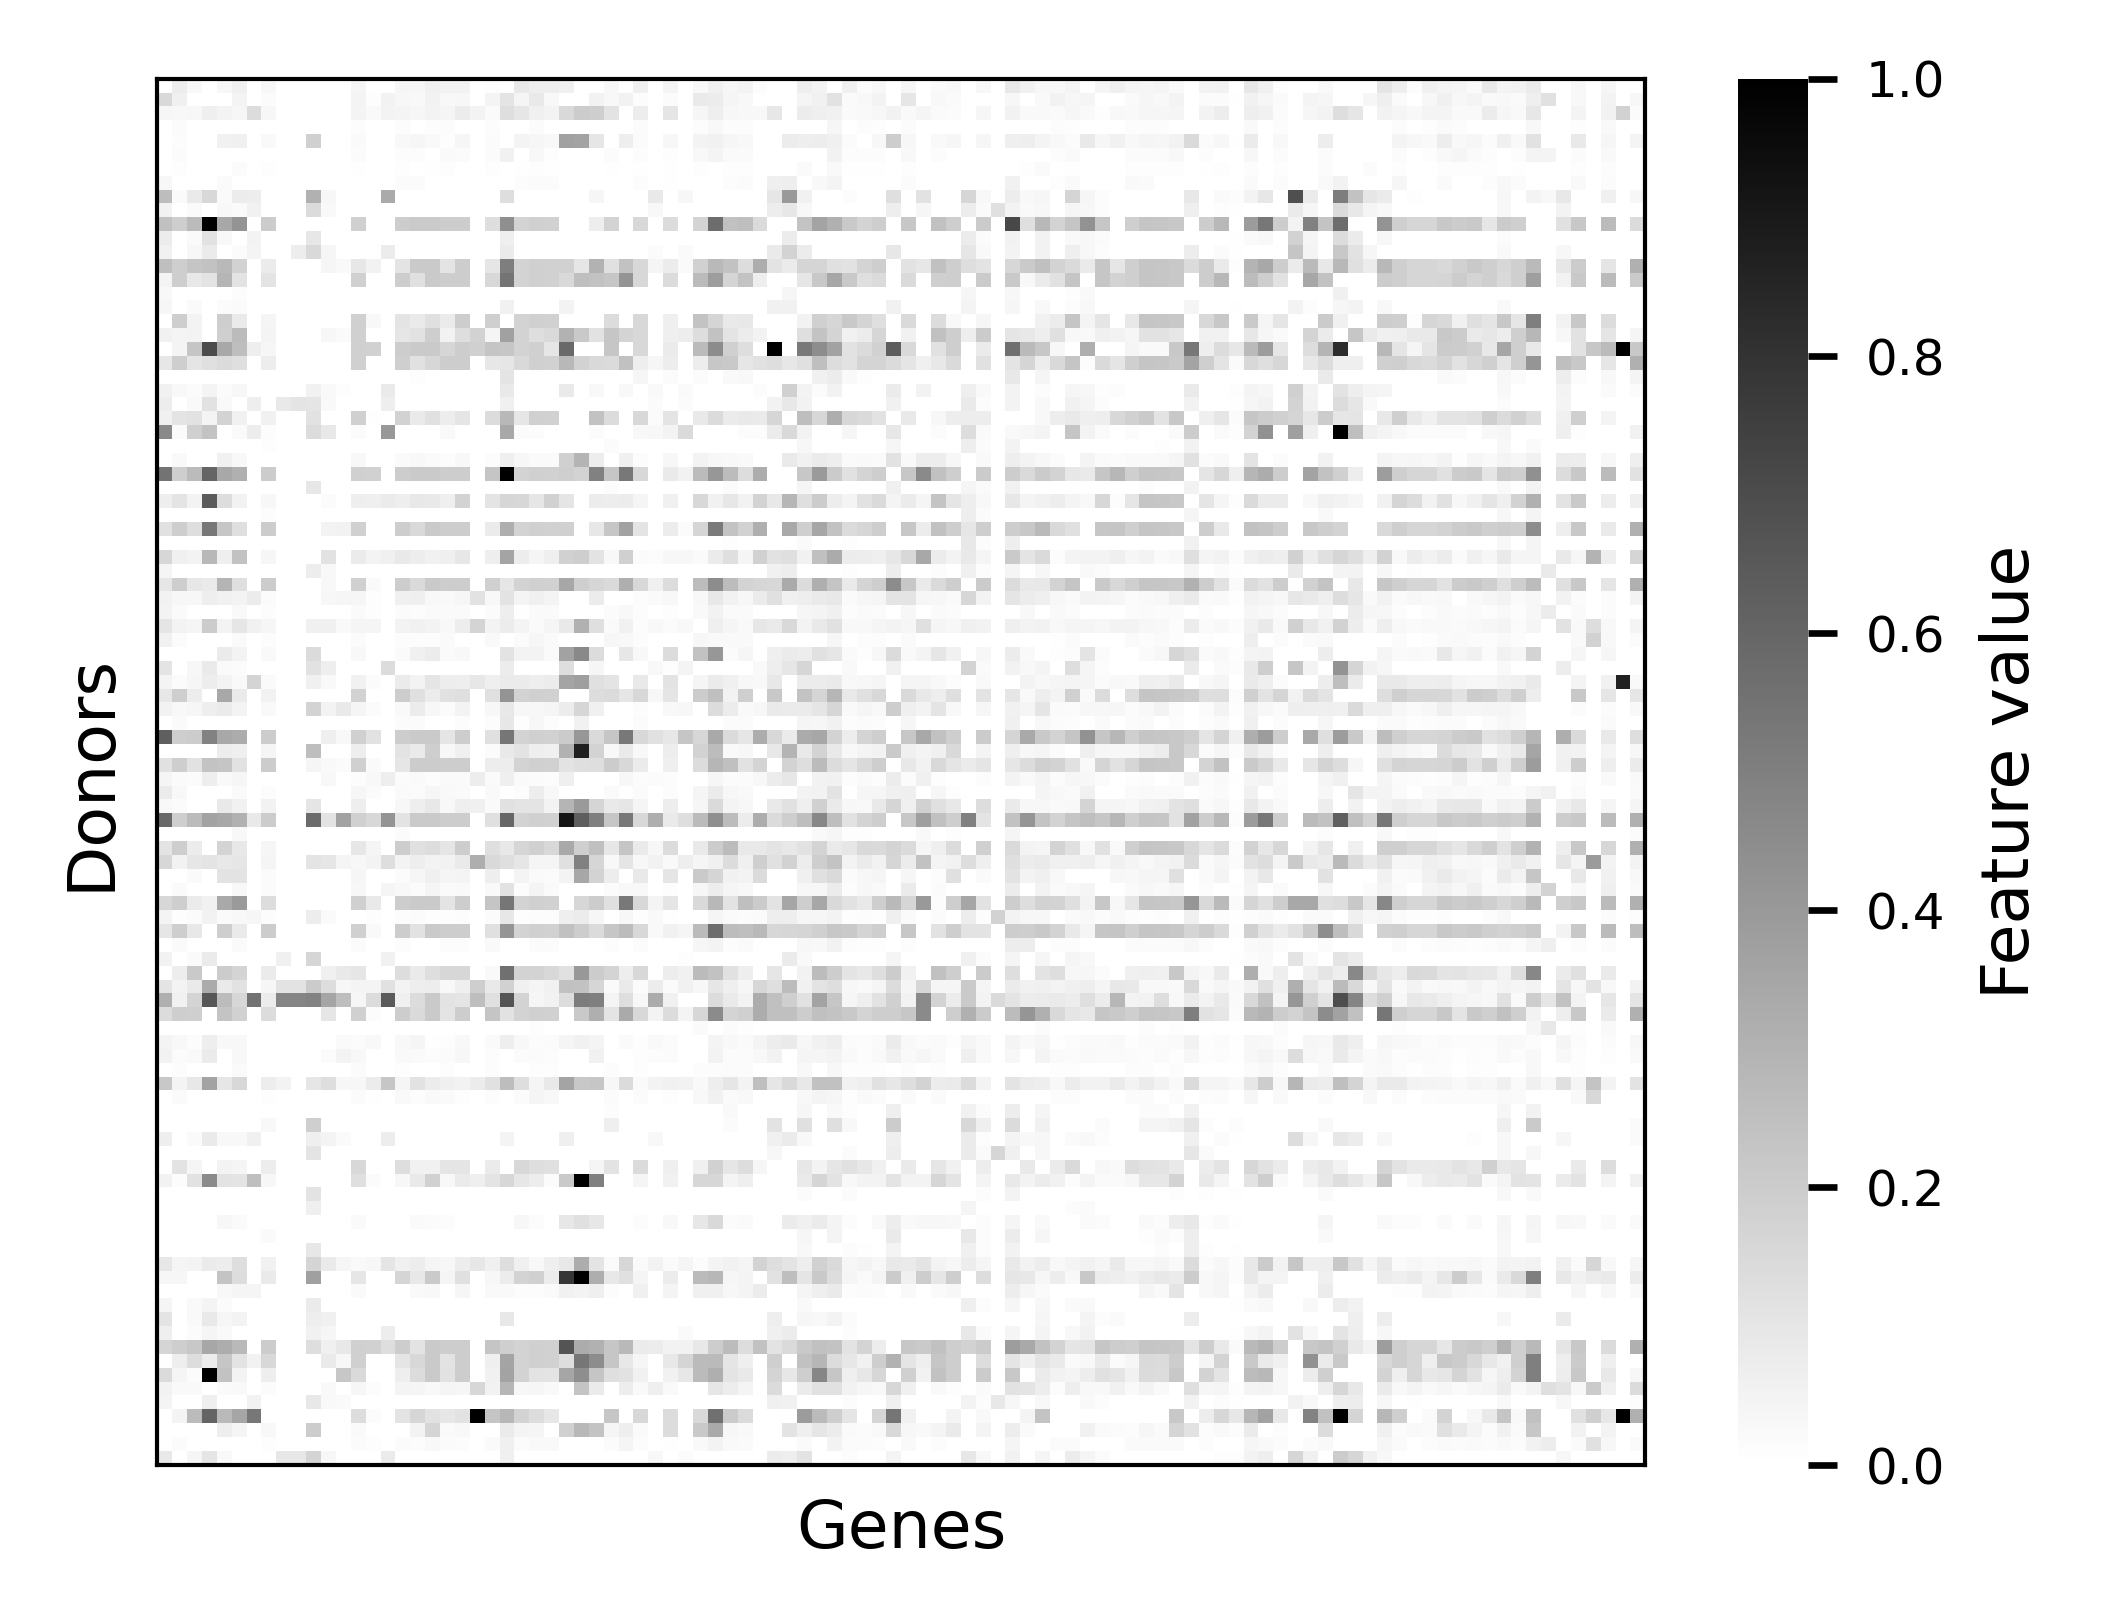

In [37]:
fig, ax = plt.subplots(1,1,figsize = (4, 3))
sns.heatmap(
    data = pan_epigenetic.combined_data_matrix.loc[pan_epigenetic.combined_data_matrix['histone_mark'] != 'methylation'].iloc[:100, :100], yticklabels=False, xticklabels=False,
    # use black and white color palette
    cmap = 'gray_r', ax = ax, cbar_kws = {'label': 'Feature value'}
    )
# add border to the heatmap
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
# make spines thinner
ax.spines['top'].set_linewidth(0.5)
ax.spines['right'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
# la
ax.set_xlabel('Genes')
ax.set_ylabel('Donors')
plt.show()
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/model_free/feature_creation_heatmap.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

# Supplementary

### Entropy

In [49]:
entropy_df = pan_epigenetic_filled.calculate_shannon_entropy(input_df = pan_epigenetic_filled.combined_data_matrix.iloc[:, :-26])
# join in the relevant metadata
entropy_df = entropy_df.to_frame().join(pan_epigenetic_filled.combined_data_matrix[['tissue', 'histone_mark', 'donor', 'age_years', 'species', 'dataset','general_tissue', 'age_scaled_loglog']])
entropy_df.rename(columns = {0: 'entropy_shannon'}, inplace = True)

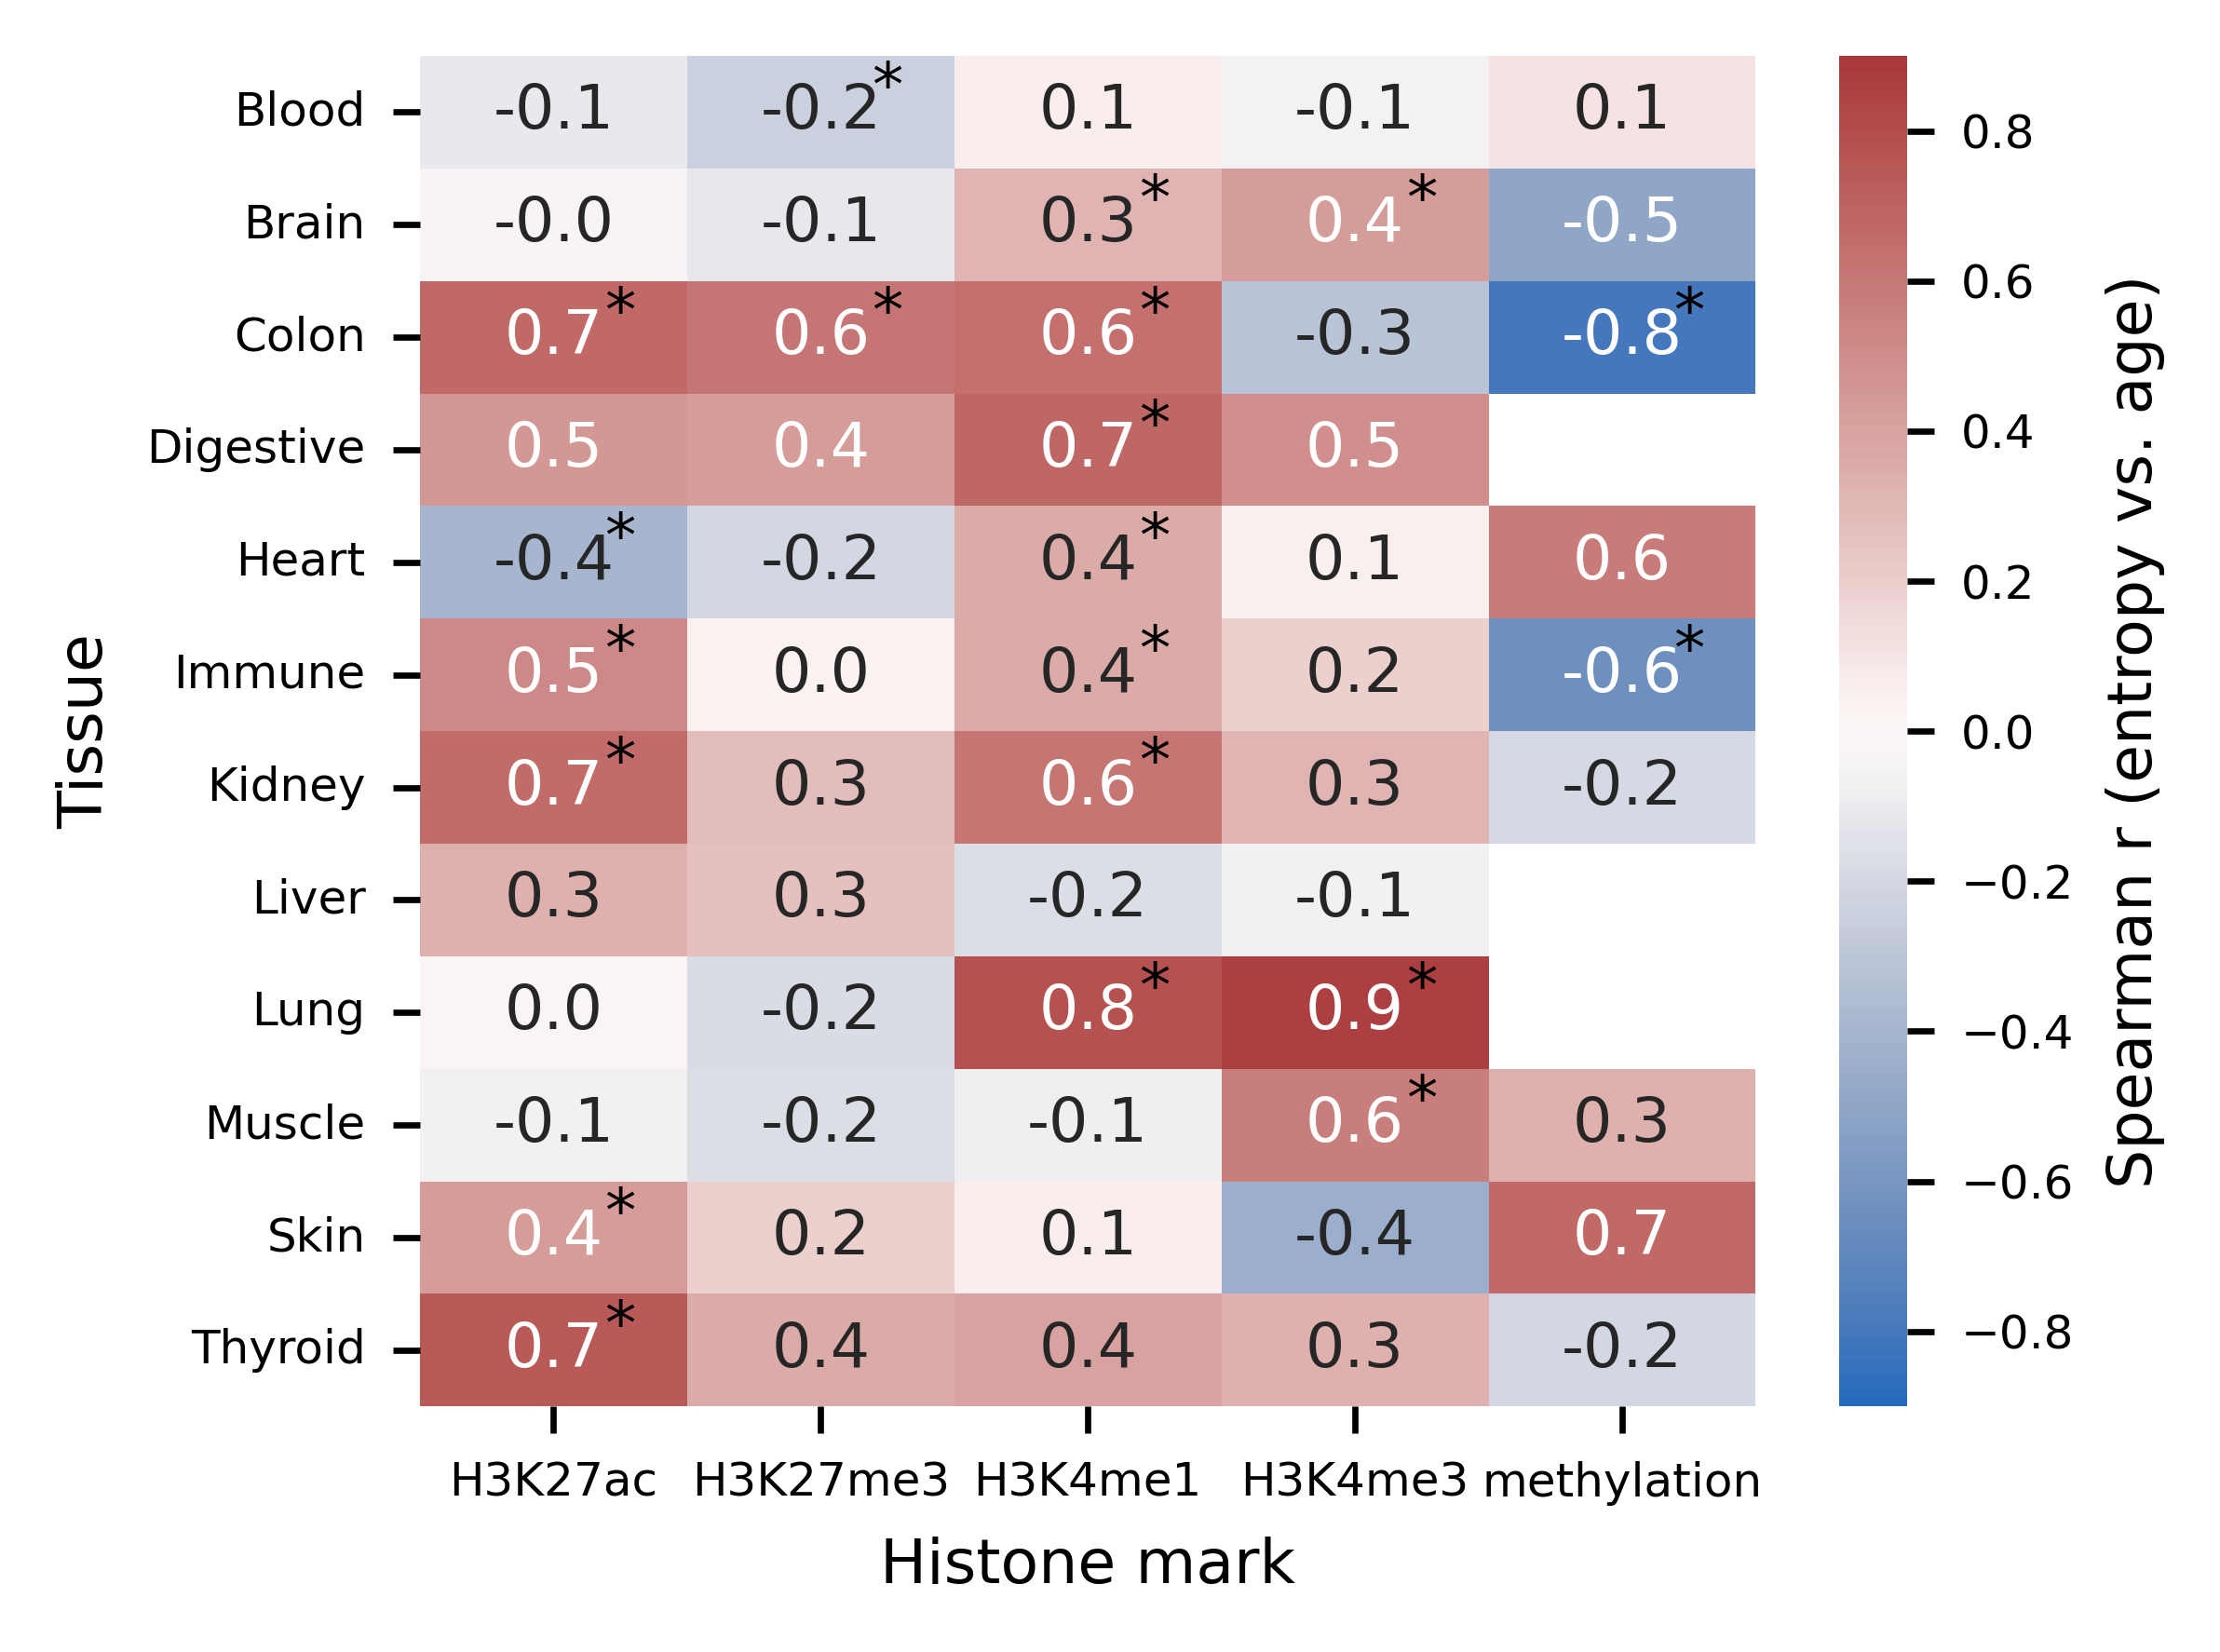

In [142]:
# filter to human, non-blueprint
df = entropy_df.query("species == 'human' ")

# get unique tissues and histone marks
tissues = sorted(df['general_tissue'].dropna().unique())
marks = sorted(df['histone_mark'].dropna().unique())

# create a matrix to store correlations
corr_matrix = np.full((len(tissues), len(marks)), np.nan)
pvals_matrix = np.full((len(tissues), len(marks)), np.nan)

for i, tissue in enumerate(tissues):
    for j, mark in enumerate(marks):
        sub = df[(df['general_tissue'] == tissue) & (df['histone_mark'] == mark)]
        if len(sub) > 5:
            corr, pval = spearmanr(sub['entropy_shannon'], sub['age_scaled_loglog'])
            corr_matrix[i, j] = corr
            pvals_matrix[i, j] = pval
# mask with nan where pval > 0.05
"""corr_matrix = np.ma.masked_where(pvals_matrix > 0.05, corr_matrix)
corr_matrix = corr_matrix.filled(np.nan)"""

fig, ax = plt.subplots(1,1,figsize = (4, 3))
# plot heatmap with lines around each box
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".1f", 
    cmap="vlag", 
    xticklabels=marks, 
    yticklabels=tissues, 
    cbar_kws={'label': "Spearman r (entropy vs. age)"},
    center = 0, 
    vmin = -.9,
    vmax = .9,
    rasterized = True,
    ax = ax,
)
# add a * as text to the heatmap where pval < 0.05
for i in range(len(tissues)):
    for j in range(len(marks)):
        if not np.isnan(pvals_matrix[i, j]) and pvals_matrix[i, j] < 0.05:
            ax.text(j+0.75, i + .3, '*', ha='center', va='center', color='black', fontsize=8, ) 
# capitalize first letter of tissues in axes labels
ax.set_yticklabels([tissue.capitalize() for tissue in tissues])

plt.xlabel('Histone mark')
plt.ylabel('Tissue')
plt.tight_layout()
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/supplementary/age_association/entropy_age_correlation.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

In [93]:
pvals_matrix

array([[1.86239513e-01, 5.05965651e-03, 4.92823488e-01, 4.83021218e-01,
        2.48058819e-01],
       [7.45439586e-01, 2.49943684e-01, 3.51116689e-02, 7.62084578e-06,
        1.00602632e-01],
       [1.38123837e-05, 2.09792324e-04, 3.55785001e-05, 6.38937452e-02,
        4.20969383e-06],
       [8.89668452e-02, 9.65658142e-02, 5.46770207e-03, 5.52580629e-02,
                   nan],
       [2.95527117e-02, 2.93378831e-01, 3.46552082e-02, 7.79955115e-01,
                   nan],
       [6.78421873e-04, 8.27410747e-01, 2.08018471e-02, 2.32365180e-01,
        4.04795807e-04],
       [           nan, 4.10510255e-01, 4.27882695e-02, 3.10142954e-01,
        5.45052703e-01],
       [           nan,            nan,            nan,            nan,
                   nan],
       [1.00000000e+00, 5.63393770e-01, 5.27476934e-04, 7.01773183e-05,
                   nan],
       [7.42270729e-01, 4.00308723e-01, 6.97051226e-01, 1.25346903e-03,
        2.86122903e-01],
       [1.63546155e-02,       

In [85]:
corr_matrix

array([[-0.11000502, -0.24084171,  0.05720448, -0.05850568,  0.10716775],
       [-0.03469671, -0.11732009,  0.32219501,  0.42699897, -0.4965035 ],
       [ 0.6714148 ,  0.61003087,  0.6393501 , -0.31658776, -0.80189   ],
       [ 0.45422562,  0.42984174,  0.67803372,  0.48781141,         nan],
       [-0.39763807, -0.20988276,  0.36337244,  0.05139979,         nan],
       [ 0.51472068,  0.03559022,  0.35994263,  0.19069635, -0.64218794],
       [        nan,  0.27647477,  0.6178516 ,  0.32027653, -0.19432508],
       [        nan,         nan,         nan,         nan,         nan],
       [ 0.        , -0.17679828,  0.78495128,  0.86314307,         nan],
       [-0.06775024, -0.16538885, -0.07852127,  0.56977345,  0.33566434],
       [ 0.43476384,         nan,         nan, -0.44904429,         nan],
       [ 0.74483322,  0.35902944,  0.40378401,  0.33696807, -0.20666459]])

### Tissue counts

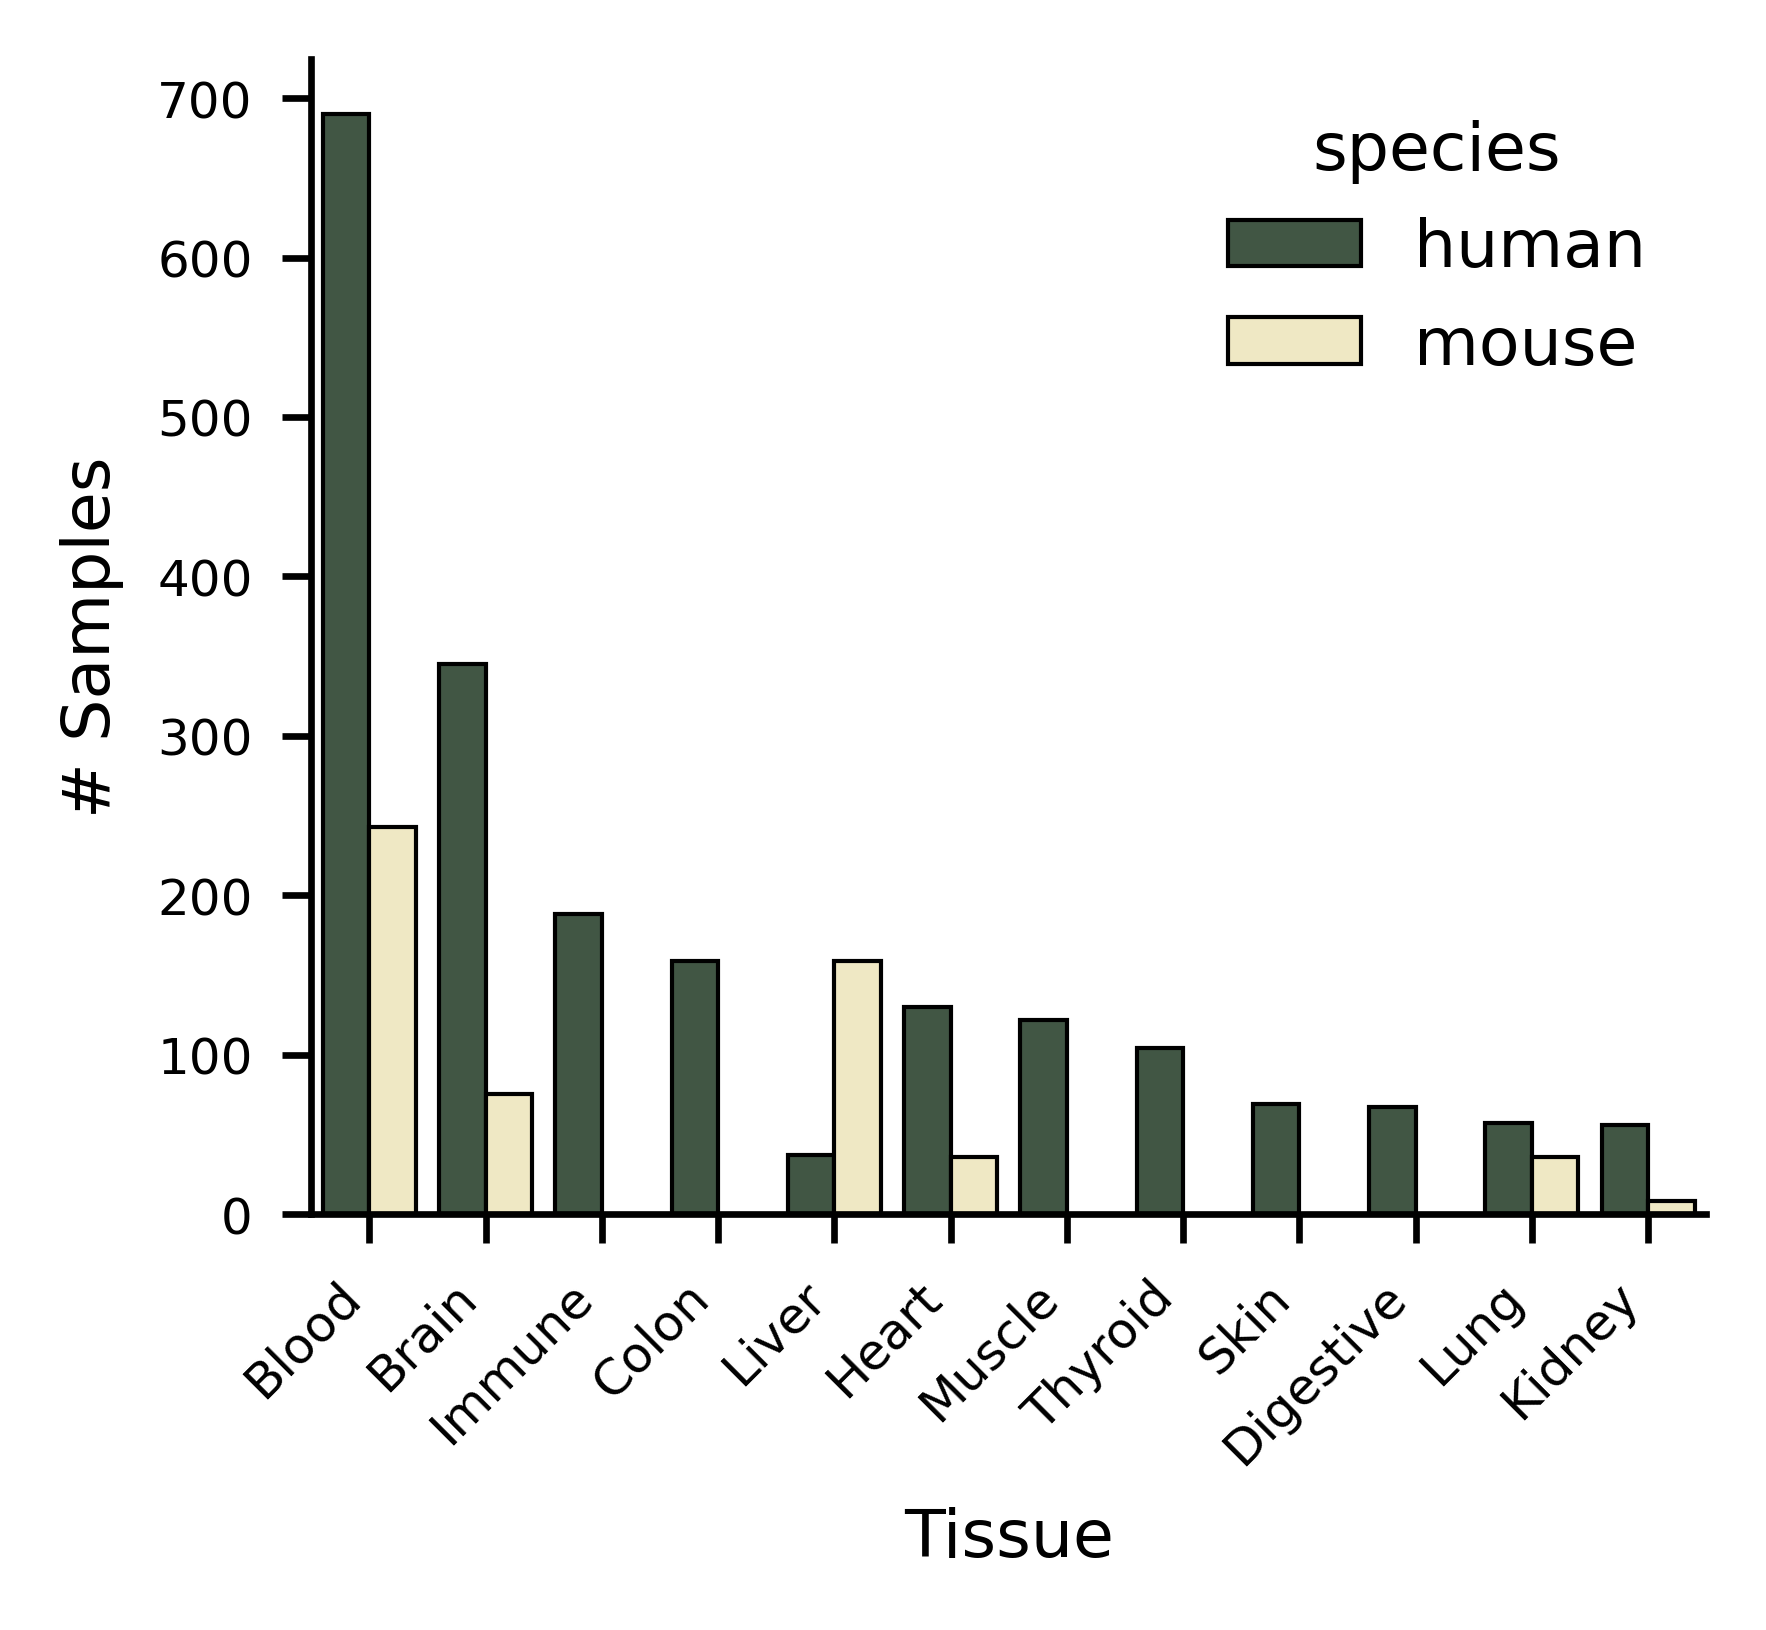

In [14]:
# group by both general_tissue and species, then count
tissue_species_counts = (
    pan_epigenetic_filled.combined_data_matrix
    .groupby(['general_tissue', 'species'])
    .size()
    .reset_index(name='count')
)
# sort by count in humans
tissue_species_counts = tissue_species_counts.sort_values(by = 'count', ascending = False)
# drop rows where tissue is special
tissue_species_counts = tissue_species_counts[tissue_species_counts['general_tissue'] != 'special']
# capitalize first letter
tissue_species_counts['general_tissue'] = tissue_species_counts['general_tissue'].str.capitalize()
fig, ax = plt.subplots(figsize = (3, 2.5))

sns.barplot(
    data = tissue_species_counts,
    x = 'general_tissue', y = 'count', hue='species', ax = ax, palette = Fall_3.mpl_colors, edgecolor = 'black', linewidth = 0.5
)
# angle x tick labels and capitalize first letter
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
ax.set_xlabel('Tissue')
ax.set_ylabel('# Samples')
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/supplementary/data_characteristics/tissue_counts.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

In [4]:
pan_epigenetic_filled.combined_data_matrix['general_tissue'].value_counts()

general_tissue
blood        933
brain        420
liver        196
immune       188
heart        166
colon        159
muscle       122
thyroid      104
lung          93
skin          69
digestive     67
kidney        64
special       12
Name: count, dtype: int64

### Supp: radar + scatter for indiv

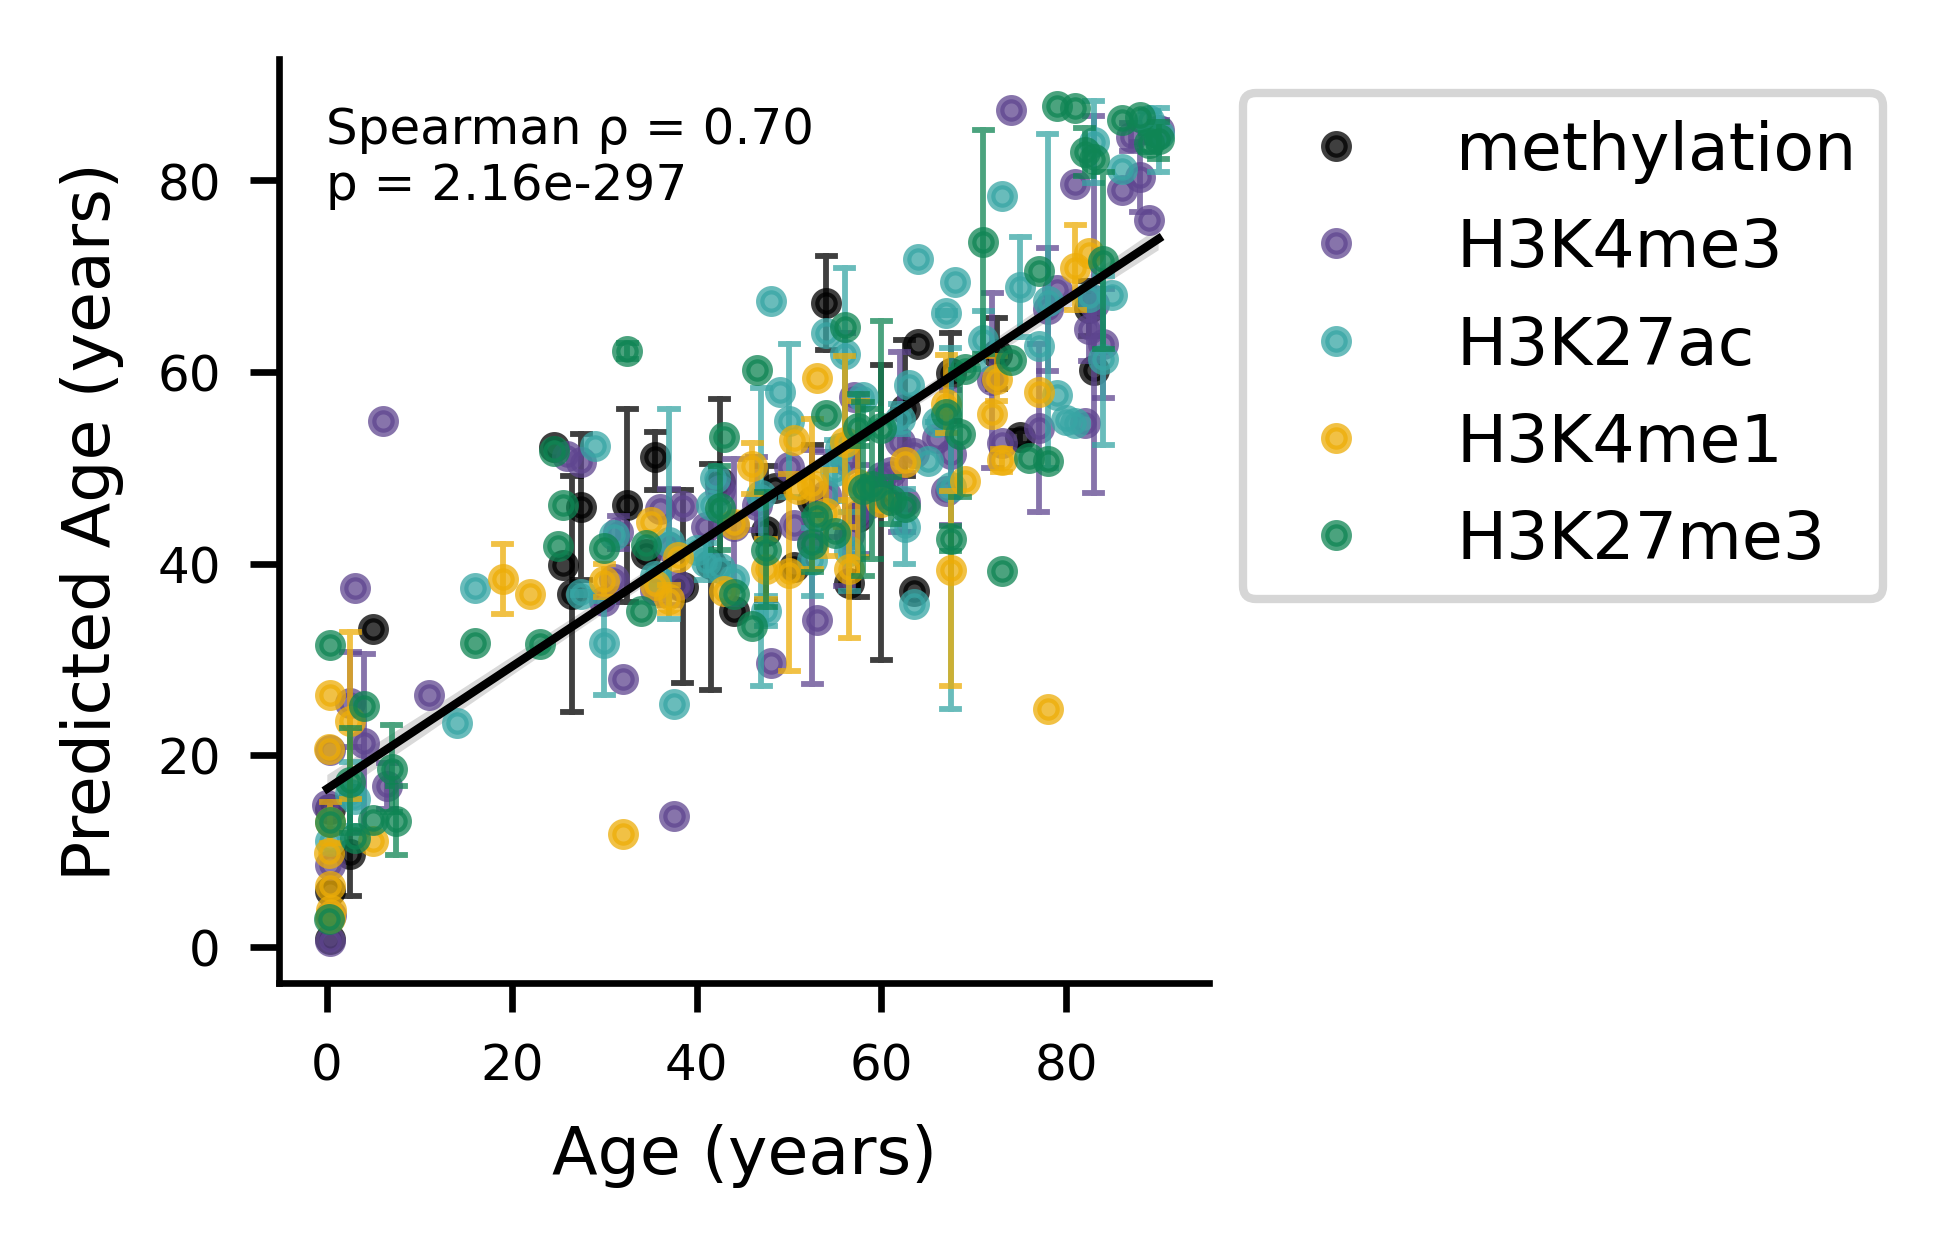

In [138]:
fig, ax = plt.subplots(figsize = (2, 2))
mean_df = pan_epigenetic_indiv_clocks.combined_data_matrix.loc[
    (pan_epigenetic_indiv_clocks.combined_data_matrix['species'] == 'human')
    ].groupby('donor')[['age_years', 'pred_age']].mean()
mean_df['histone_mark'] = mean_df.index.map(pan_epigenetic_indiv_clocks.combined_data_matrix.set_index('donor')['histone_mark'].to_dict())
# map in histone mark
sns.pointplot(
    data = mean_df,
    x = 'age_years', y = 'pred_age', hue = 'histone_mark',
    ax = ax, palette=hmark_colors,# s = 13, 
    alpha = 0.75, legend = True, join = False, native_scale=True,
    errwidth = .7, capsize = 1000, scale = 0.5
    )
# move legend to the right and put in box
ax.legend(loc = 'upper left', bbox_to_anchor = (1, 1), frameon = True)
sns.regplot(
    data = pan_epigenetic_indiv_clocks.combined_data_matrix.loc[pan_epigenetic_indiv_clocks.combined_data_matrix['species'] == 'human'],
    x = 'age_years', y = 'pred_age', color = 'black', ax = ax, scatter = False, robust = True,
    line_kws = {'linewidth': 1}
    )
# add pearson correlation
r, p = spearmanr(
    pan_epigenetic_indiv_clocks.combined_data_matrix.loc[pan_epigenetic_indiv_clocks.combined_data_matrix['species'] == 'human'].dropna(subset = ['age_years', 'pred_age'])['age_years'],
    pan_epigenetic_indiv_clocks.combined_data_matrix.loc[pan_epigenetic_indiv_clocks.combined_data_matrix['species'] == 'human'].dropna(subset = ['age_years', 'pred_age'])['pred_age']
    )
ax.text(0.05, 0.95, f'Spearman ρ = {r:.2f}\np = {p:.2e}', transform=ax.transAxes, fontsize=6, verticalalignment='top')
# rename axes
ax.set_xlabel('Age (years)')
ax.set_ylabel('Predicted Age (years)')
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/supplementary/prediction_scatters/scatter_plot_indiv_clocks_human.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

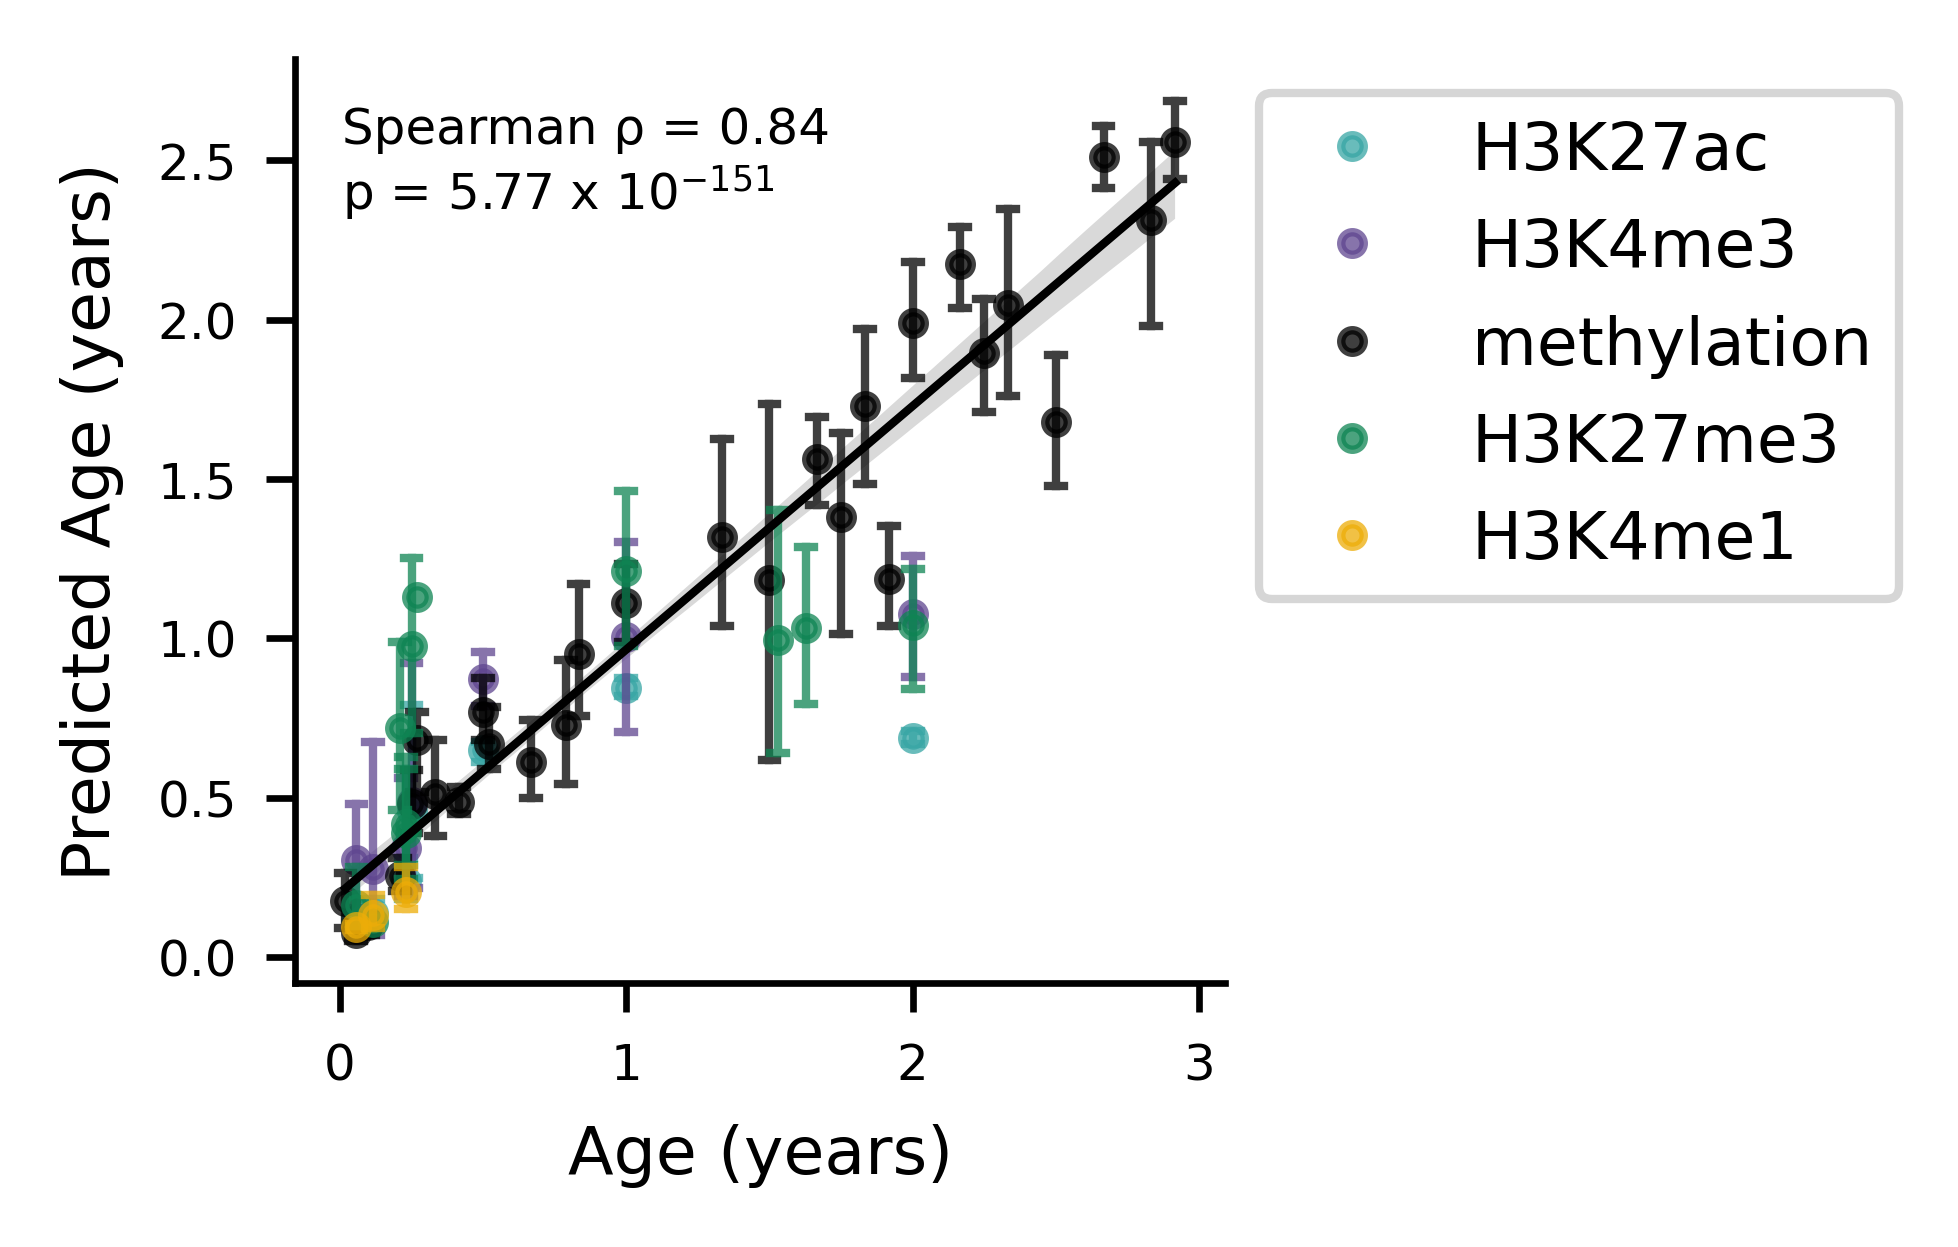

In [140]:
fig, ax = plt.subplots(figsize = (2, 2))
mean_df = pan_epigenetic_indiv_clocks.combined_data_matrix.loc[(pan_epigenetic_indiv_clocks.combined_data_matrix['species'] == 'mouse')].groupby('donor')[['age_years', 'pred_age']].mean()
mean_df['histone_mark'] = mean_df.index.map(pan_epigenetic_indiv_clocks.combined_data_matrix.set_index('donor')['histone_mark'].to_dict())
# map in histone mark
sns.pointplot(
    data = mean_df,
    x = 'age_years', y = 'pred_age', hue = 'histone_mark',
    ax = ax, palette=hmark_colors,# s = 13, 
    alpha = 0.75, legend = True, join = False, native_scale=True,
    errwidth = 1, capsize = 50, scale = 0.5,
    )
# move legend to the right and put in box
ax.legend(loc = 'upper left', bbox_to_anchor = (1, 1), frameon = True)
sns.regplot(
    data = pan_epigenetic_indiv_clocks.combined_data_matrix.loc[pan_epigenetic_indiv_clocks.combined_data_matrix['species'] == 'mouse'], x = 'age_years', y = 'pred_age', color = 'black', ax = ax, scatter = False, robust = True, line_kws = {'linewidth': 1}
    )
# add pearson correlation
r, p = spearmanr(
    pan_epigenetic_indiv_clocks.combined_data_matrix.loc[pan_epigenetic_indiv_clocks.combined_data_matrix['species'] == 'mouse'].dropna(subset = ['age_years', 'pred_age'])['age_years'],
    pan_epigenetic_indiv_clocks.combined_data_matrix.loc[pan_epigenetic_indiv_clocks.combined_data_matrix['species'] == 'mouse'].dropna(subset = ['age_years', 'pred_age'])['pred_age']
    )
p_str = f"{p:.2e}".split('e')[0] + " x 10$^{" + f"{p:.2e}".split('e')[1] + "}$"
ax.text(0.05, 0.95, f'Spearman ρ = {r:.2f}\np = {p_str}', transform=ax.transAxes, fontsize=6, verticalalignment='top')
# rename axes
ax.set_xlabel('Age (years)')
ax.set_ylabel('Predicted Age (years)')
fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/supplementary/prediction_scatters/scatter_plot_indiv_clocks_mouse.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)

In [10]:
pan_epigenetic_indiv_clocks.combined_data_matrix.dropna(
    subset = ['pred_age', 'age_years']
    ).groupby(['histone_mark'])[['pred_age', 'age_years']].apply(lambda x: spearmanr(x['pred_age'], x['age_years'])).reset_index()

histone_mark                                              0
0      H3K27ac   (0.7794552770584171, 7.985207910406787e-104)
1     H3K27me3  (0.8565365054681116, 1.3100102139844943e-146)
2      H3K4me1    (0.6245482786672736, 1.999434730930943e-48)
3      H3K4me3   (0.7567973913382413, 1.1207261555523566e-95)
4  methylation  (0.9134101968505738, 1.3900377474642916e-253)

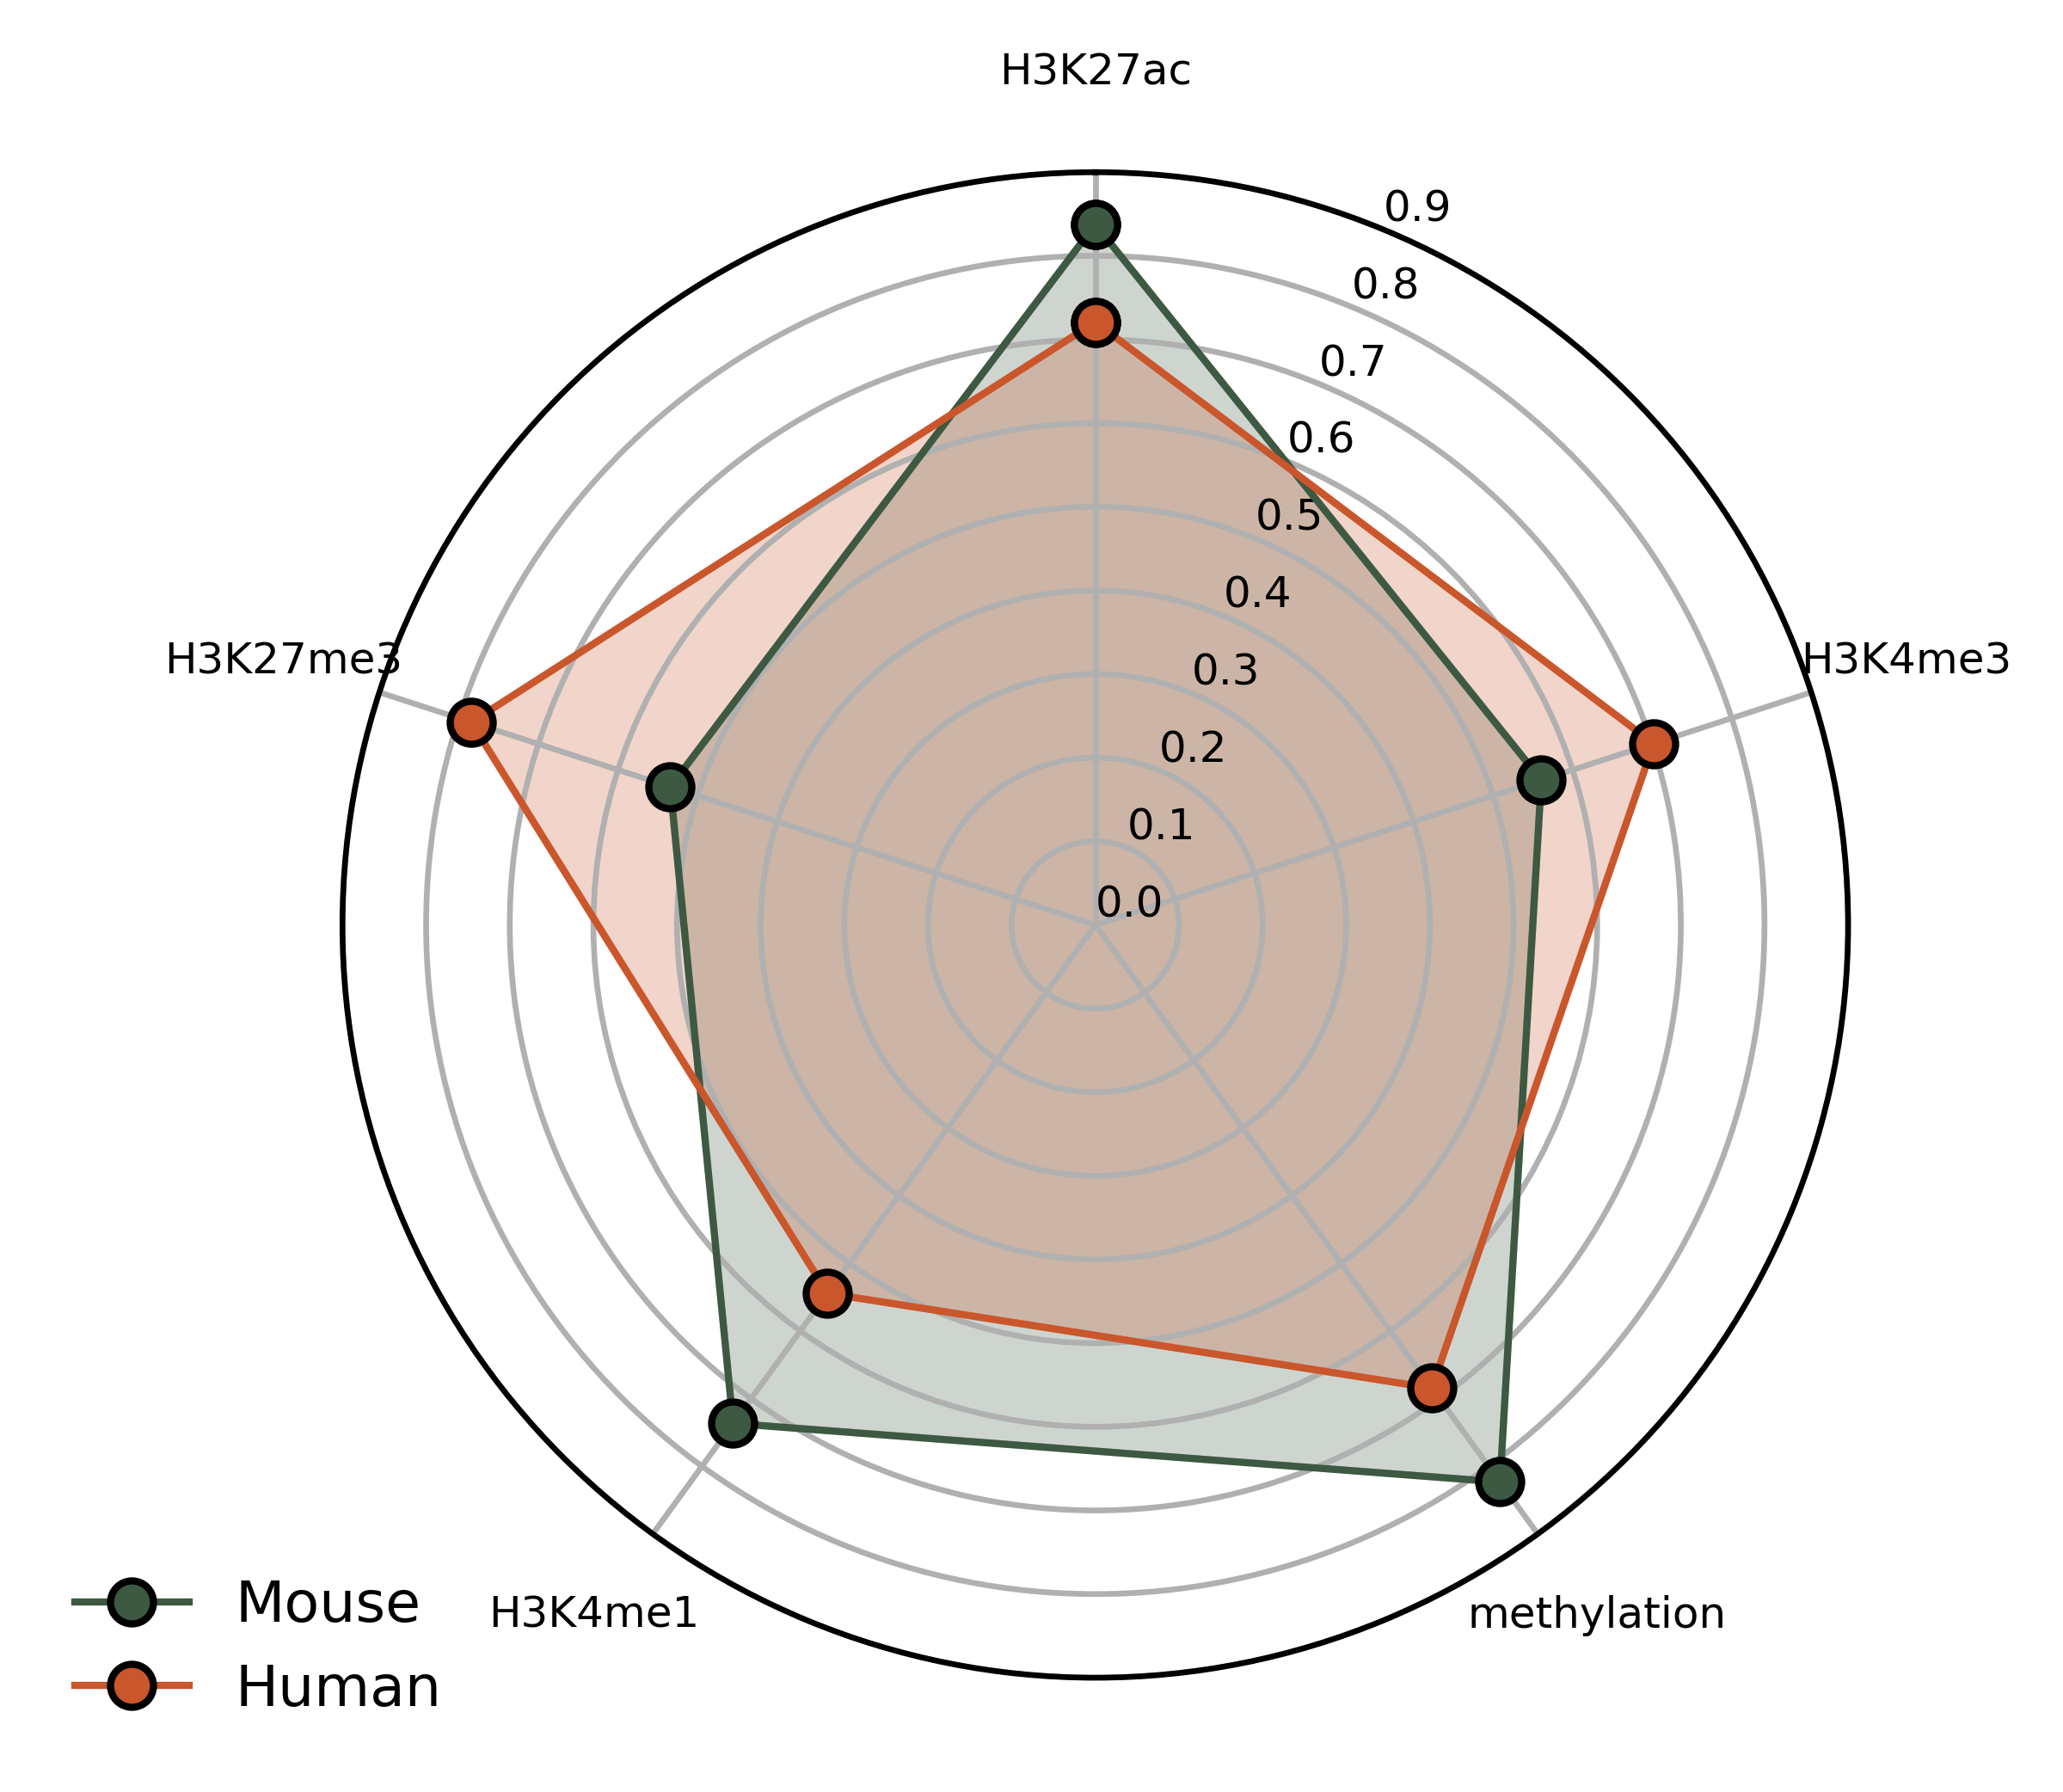

In [7]:
# compute the correlation between predicted and actual age for each mark and species
correlations_indiv_clocks = pan_epigenetic_indiv_clocks.combined_data_matrix.dropna(
    subset = ['pred_age', 'age_years']
    ).groupby(['histone_mark', 'species'])[['pred_age', 'age_years']].apply(lambda x: spearmanr(x['pred_age'], x['age_years'])).reset_index()
# split 0 column into r and pvalue
correlations_indiv_clocks['r'] = correlations_indiv_clocks[0].apply(lambda x: x[0])
correlations_indiv_clocks['pvalue'] = correlations_indiv_clocks[0].apply(lambda x: x[1])
correlations_indiv_clocks.drop(columns = [0], inplace = True)
# create dictionary of correlations for each mark
mouse_corrs = correlations_indiv_clocks.query("species == 'mouse'").set_index('histone_mark')['r'].to_dict()
human_corrs = correlations_indiv_clocks.query("species == 'human'").set_index('histone_mark')['r'].to_dict()

# reorder mouse and human correlations
mouse_corrs = {mark: mouse_corrs[mark] for mark in order}
human_corrs = {mark: human_corrs[mark] for mark in order}

fig, ax = pan_epigenetic_indiv_clocks.plot_correlation_radar(
    correlations_1 = mouse_corrs,
    correlations_2 = human_corrs,
    mark_order = order,
    label_1 = 'Mouse',
    label_2 = 'Human',
    color_1 = Fall_3.mpl_colors[0],
    color_2 = Fall_3.mpl_colors[2],
    value_range = (0,.9)
    )


fig.savefig('/cellar/users/zkoch/histone_mark_proj/figures/supplementary/prediction_scatters/radar_plot_indiv_clocks.svg', dpi = 300, bbox_inches = 'tight', format = 'svg', transparent = True)